## Noneに関して同時生起行列を求める

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

import csv

import pickle
import copy
import cv2
import random
import glob

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)
import keras
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
import keras.backend.tensorflow_backend as tfback


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU') memory growth: True
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


Using TensorFlow backend.


['LSWMD.pkl']


### 定義

In [3]:
# Define
max_size = 300
random.seed(1)

### Noneのウエハのみを抽出する

In [4]:
df=pd.read_pickle("../input/LSWMD.pkl")

df = df.drop(['waferIndex'], axis = 1)

def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)

In [5]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

tol_wafers = df.shape[0]

df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]

In [6]:
df_nonpattern

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
...,...,...,...,...,...,...,...,...
811438,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Test]],[[none]],"(26, 30)",8,1
811439,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,[[Test]],[[none]],"(26, 30)",8,1
811442,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",600.0,lot47542,[[Test]],[[none]],"(26, 30)",8,1
811445,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,[[Test]],[[none]],"(26, 30)",8,1


In [7]:
uni_waferDim=np.unique(df_nonpattern.waferMapDim, return_counts=True)
uni_waferDim[0]

array([(15, 3), (18, 4), (18, 44), (22, 50), (24, 13), (24, 18), (25, 26),
       (25, 27), (26, 25), (26, 26), (26, 28), (26, 30), (27, 15),
       (27, 25), (27, 27), (28, 26), (29, 26), (29, 27), (30, 30),
       (30, 31), (30, 34), (30, 35), (31, 28), (31, 31), (31, 32),
       (32, 32), (33, 29), (33, 32), (33, 35), (33, 37), (34, 31),
       (34, 34), (35, 31), (35, 34), (35, 37), (35, 40), (36, 34),
       (37, 37), (37, 55), (38, 38), (38, 40), (38, 42), (39, 31),
       (39, 37), (39, 39), (39, 50), (41, 33), (41, 38), (41, 40),
       (41, 41), (41, 42), (41, 43), (41, 45), (41, 57), (42, 43),
       (42, 44), (43, 42), (43, 43), (43, 44), (44, 41), (44, 43),
       (44, 44), (44, 45), (45, 42), (45, 43), (45, 45), (45, 48),
       (47, 32), (47, 47), (47, 52), (48, 48), (50, 43), (50, 49),
       (50, 51), (50, 54), (51, 30), (51, 44), (51, 50), (52, 55),
       (53, 58), (53, 71), (54, 71), (55, 56), (55, 66), (58, 59),
       (61, 60), (62, 62), (62, 64), (62, 75), (63, 64

In [8]:
df_nonpattern.iloc[0,:]

waferMap          [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
dieSize                                                        1683
lotName                                                        lot1
trianTestLabel                                         [[Training]]
failureType                                                [[none]]
waferMapDim                                                (45, 48)
failureNum                                                        8
trainTestNum                                                      0
Name: 0, dtype: object

In [12]:
sub_df = df_nonpattern.loc[df_nonpattern['waferMapDim'] == (26, 26)]

In [123]:
sub_df

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
150,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
152,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
153,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
154,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
...,...,...,...,...,...,...,...,...
679251,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot42179,[[Test]],[[none]],"(26, 26)",8,1
679252,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot42179,[[Test]],[[none]],"(26, 26)",8,1
679253,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",533.0,lot42179,[[Test]],[[none]],"(26, 26)",8,1
679254,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1,...",533.0,lot42179,[[Test]],[[none]],"(26, 26)",8,1


In [104]:
wafer = np.empty((len(sub_df), 26, 26))
for i in range(len(sub_df)):
    wafer[i] = sub_df.iloc[i,:]['waferMap']

スタンプサイズ:2x2, 平均14.016
スタンプサイズ:3x2, 平均13.674
スタンプサイズ:4x2, 平均13.674
wafer_id:6889, ウエハサイズ:26x26, スタンプサイズ:2x3, oDefects:59, nDefects:160, p=36.875


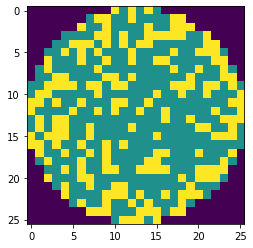

スタンプサイズ:2x3, 平均13.498
wafer_id:6889, ウエハサイズ:26x26, スタンプサイズ:3x3, oDefects:56, nDefects:148, p=37.838


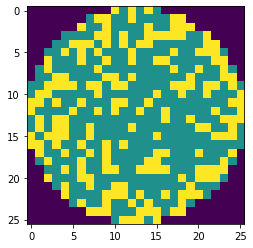

スタンプサイズ:3x3, 平均13.309
wafer_id:6889, ウエハサイズ:26x26, スタンプサイズ:4x3, oDefects:56, nDefects:148, p=37.838


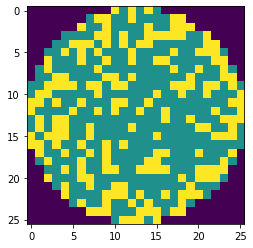

スタンプサイズ:4x3, 平均13.309
wafer_id:6131, ウエハサイズ:26x26, スタンプサイズ:2x4, oDefects:54, nDefects:143, p=37.762


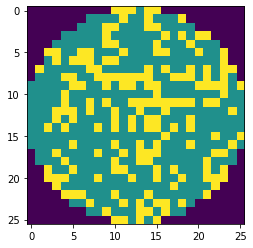

スタンプサイズ:2x4, 平均13.095
wafer_id:6131, ウエハサイズ:26x26, スタンプサイズ:3x4, oDefects:52, nDefects:135, p=38.519


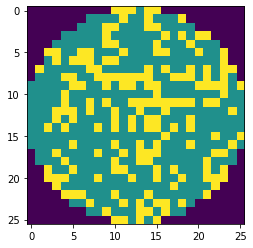

wafer_id:6285, ウエハサイズ:26x26, スタンプサイズ:3x4, oDefects:35, nDefects:100, p=35.000


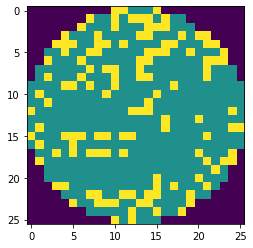

スタンプサイズ:3x4, 平均13.087
wafer_id:6131, ウエハサイズ:26x26, スタンプサイズ:4x4, oDefects:52, nDefects:135, p=38.519


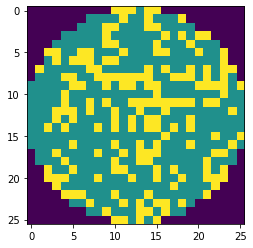

wafer_id:6285, ウエハサイズ:26x26, スタンプサイズ:4x4, oDefects:35, nDefects:100, p=35.000


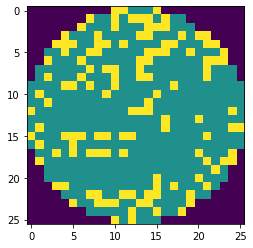

スタンプサイズ:4x4, 平均13.087


In [127]:
DEFECT = 2
waferW = 26
waferH = 26
wafer = wafer26x26
for w in range(2, 5):
    for h in range(2, 5):
        mean_p = 0
        for w_id in range(wafer.shape[0]):
            nDefects = 0
            oDefects = 0
            max_H = waferH if waferH % h == 0 else waferH - h
            max_W = waferW - w if waferW % w == 0 else waferW - 2 * w
            for l in range(0, max_H, h):
                for k in range(0, max_W, w):
                    for j in range(h):
                        for i in range(w):
                            if wafer[w_id][l + j][k + i] == DEFECT:
                                nDefects += 1
                                if wafer[w_id][l + j][k + i + w] == DEFECT:
                                    oDefects += 1
            p = (100.0 * oDefects / nDefects) if nDefects != 0 else -1.0
            if p >= 35: 
                print(f"wafer_id:{w_id}, ウエハサイズ:{waferH}x{waferW}, スタンプサイズ:{h}x{w}, oDefects:{oDefects}, nDefects:{nDefects}, p={p:.3f}")
                plt.imshow(wafer[w_id])
                plt.show()
            mean_p += p
        
        print(f"スタンプサイズ:{h}x{w}, 平均{mean_p / wafer.shape[0]:.3f}")

In [16]:
DEFECT = 2

def detectShotDefects(x, w_id, w, h):
    nDefects = 0
    oDefects = 0
    waferH = x.shape[0]
    waferW = x.shape[1]
    max_H = waferH if waferH % h == 0 else waferH - h
    max_W = waferW - w if waferW % w == 0 else waferW - 2 * w
    for l in range(0, max_H, h):
        for k in range(0, max_W, w):
            for j in range(h):
                for i in range(w):
                    if x[l + j][k + i] == DEFECT:
                        nDefects += 1
                        if x[l + j][k + i + w] == DEFECT:
                            oDefects += 1
    p = (100.0 * oDefects / nDefects) if nDefects != 0 else 0.0
#     if p >= 0: 
#         print(f"wafer_id:{w_id}, ウエハサイズ:{waferH}x{waferW}, スタンプサイズ:{h}x{w}, oDefects:{oDefects}, nDefects:{nDefects}, p={p:.3f}")
#         plt.imshow(x)
#         plt.show()
        
    return p

(45, 48)
(26, 26)
(26, 26)
(26, 26)
(26, 26)
(26, 26)
(26, 26)
(51, 50)
(50, 49)
(64, 60)
(47, 52)
(61, 60)
wafer_id:11035, ウエハサイズ:35x40, スタンプサイズ:2x3, oDefects:100, nDefects:203, p=49.261


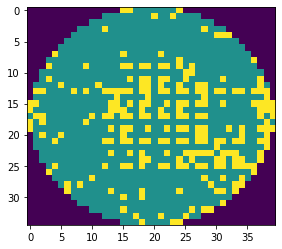

wafer_id:11035, ウエハサイズ:35x40, スタンプサイズ:3x3, oDefects:100, nDefects:200, p=50.000


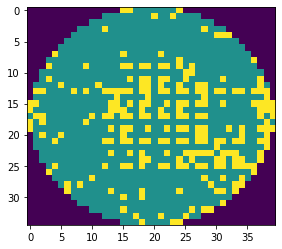

wafer_id:11035, ウエハサイズ:35x40, スタンプサイズ:4x3, oDefects:99, nDefects:196, p=50.510


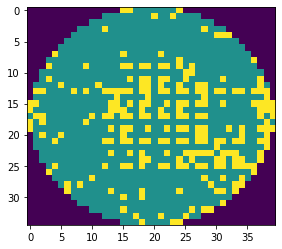

(26, 26)
(26, 26)
(26, 26)
(26, 26)
(26, 26)
(26, 26)
(30, 34)
(30, 34)
(30, 34)
(30, 34)
(30, 34)
(30, 34)
(30, 34)
(30, 34)
(30, 34)
(30, 34)
(29, 27)
(29, 27)
(29, 27)
(26, 26)
(35, 31)
(35, 31)
(35, 31)
(35, 31)
(38, 42)
(41, 38)
(41, 38)
(41, 38)
(41, 38)
(39, 37)
(39, 37)
(39, 37)
(38, 38)
(32, 32)
(31, 28)
(25, 27)
(25, 27)
(25, 27)
(25, 27)
(25, 27)
(25, 27)
(25, 27)
(25, 27)
(25, 27)
(25, 27)
(25, 27)
(25, 27)
(25, 27)
(25, 27)
(25, 27)
(25, 27)
(45, 42)
(45, 42)
(45, 42)
(41, 40)
(41, 40)
(34, 31)
(25, 26)
(25, 26)
(25, 26)
(25, 26)
(30, 34)
(30, 34)
(42, 43)
(33, 29)
(33, 29)
(33, 29)
(33, 29)
(33, 29)
(33, 29)
(33, 29)
(43, 44)
(43, 44)
(43, 44)
(43, 42)
(22, 50)
(27, 25)
(27, 25)
(27, 25)
(27, 25)
(27, 25)
(27, 25)
(27, 25)
(27, 25)
(27, 25)
wafer_id:96151, ウエハサイズ:27x15, スタンプサイズ:2x4, oDefects:1, nDefects:2, p=50.000


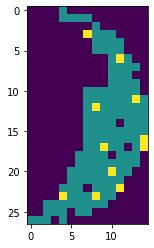

wafer_id:96151, ウエハサイズ:27x15, スタンプサイズ:3x4, oDefects:1, nDefects:2, p=50.000


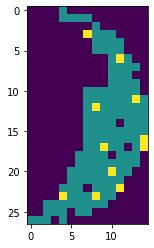

wafer_id:96151, ウエハサイズ:27x15, スタンプサイズ:4x4, oDefects:1, nDefects:2, p=50.000


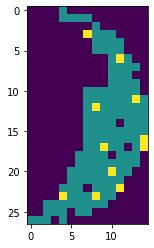

(27, 25)
(39, 37)
(39, 37)
(39, 37)
(39, 37)
(39, 37)
(39, 37)
(39, 37)
(34, 34)
(44, 41)
(44, 41)
(44, 41)
(44, 41)
(44, 41)
(44, 41)
(41, 42)
wafer_id:112405, ウエハサイズ:41x45, スタンプサイズ:2x3, oDefects:169, nDefects:391, p=43.223


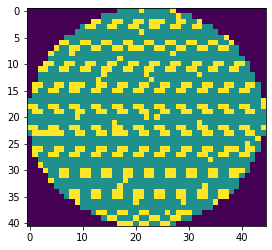

wafer_id:112405, ウエハサイズ:41x45, スタンプサイズ:3x3, oDefects:167, nDefects:384, p=43.490


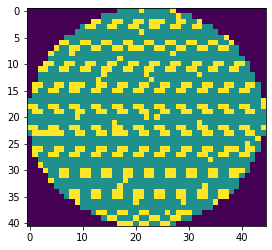

wafer_id:112405, ウエハサイズ:41x45, スタンプサイズ:4x3, oDefects:169, nDefects:391, p=43.223


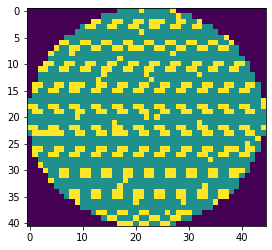

wafer_id:112405, ウエハサイズ:41x45, スタンプサイズ:2x4, oDefects:315, nDefects:376, p=83.777


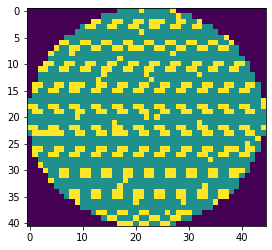

wafer_id:112405, ウエハサイズ:41x45, スタンプサイズ:3x4, oDefects:311, nDefects:369, p=84.282


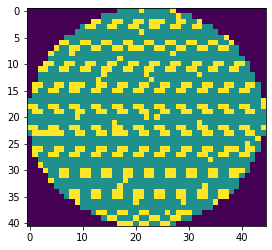

wafer_id:112405, ウエハサイズ:41x45, スタンプサイズ:4x4, oDefects:315, nDefects:376, p=83.777


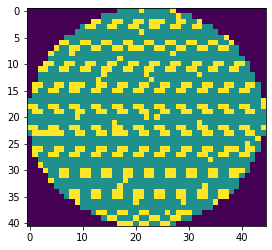

(41, 45)
wafer_id:113340, ウエハサイズ:41x45, スタンプサイズ:2x3, oDefects:165, nDefects:377, p=43.767


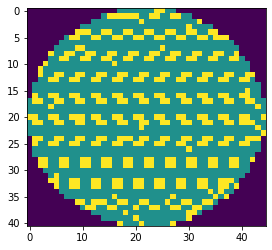

wafer_id:113340, ウエハサイズ:41x45, スタンプサイズ:3x3, oDefects:165, nDefects:375, p=44.000


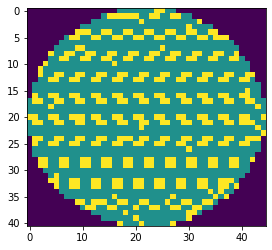

wafer_id:113340, ウエハサイズ:41x45, スタンプサイズ:4x3, oDefects:165, nDefects:377, p=43.767


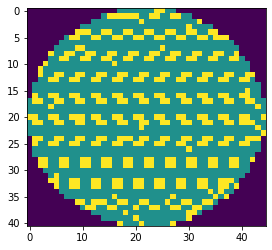

wafer_id:113340, ウエハサイズ:41x45, スタンプサイズ:2x4, oDefects:305, nDefects:363, p=84.022


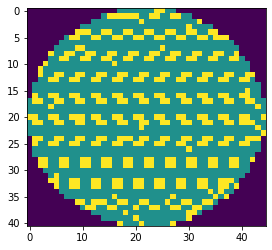

wafer_id:113340, ウエハサイズ:41x45, スタンプサイズ:3x4, oDefects:305, nDefects:361, p=84.488


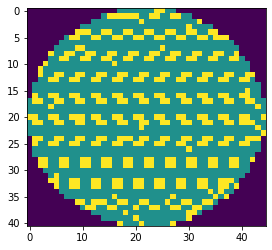

wafer_id:113340, ウエハサイズ:41x45, スタンプサイズ:4x4, oDefects:305, nDefects:363, p=84.022


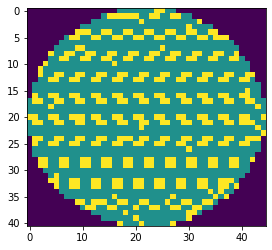

(41, 45)
(39, 50)
wafer_id:115087, ウエハサイズ:22x50, スタンプサイズ:2x2, oDefects:133, nDefects:305, p=43.607


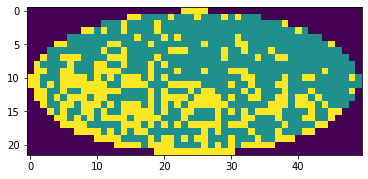

wafer_id:115087, ウエハサイズ:22x50, スタンプサイズ:3x2, oDefects:123, nDefects:293, p=41.980


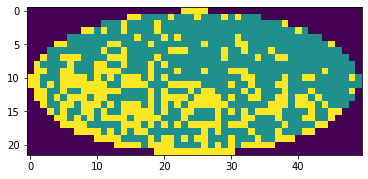

wafer_id:115087, ウエハサイズ:22x50, スタンプサイズ:4x2, oDefects:112, nDefects:277, p=40.433


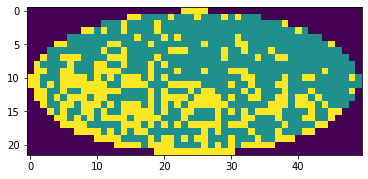

wafer_id:115087, ウエハサイズ:22x50, スタンプサイズ:2x4, oDefects:124, nDefects:298, p=41.611


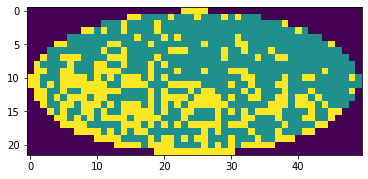

wafer_id:115087, ウエハサイズ:22x50, スタンプサイズ:3x4, oDefects:116, nDefects:286, p=40.559


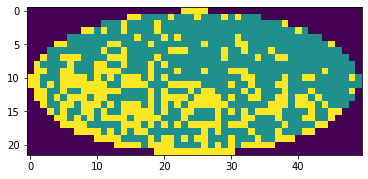

wafer_id:115087, ウエハサイズ:22x50, スタンプサイズ:4x4, oDefects:109, nDefects:270, p=40.370


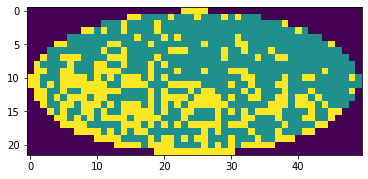

(42, 44)
(42, 44)
(42, 44)
(42, 44)
(42, 44)
(42, 44)
(42, 44)
(33, 37)
(33, 37)
(33, 37)
(33, 37)
(51, 30)
(51, 30)
(45, 43)
(29, 26)
(29, 26)
(29, 26)
(29, 26)
(29, 26)
(29, 26)
(29, 26)
(29, 26)
(29, 26)
(29, 26)
(29, 26)
(33, 35)
(41, 33)
(41, 33)
(41, 33)
(41, 33)
(41, 33)
(26, 30)


In [122]:
for w_id in range(len(df_nonpattern)):
    x = df_nonpattern.iloc[w_id, :]['waferMap']
    if w_id % 1000 == 0: print(x.shape)
    for w in range(2, 5):
        for h in range(2, 5):
            detectShotDefects(x, w_id, w, h)

In [30]:
for wdim in uni_waferDim[0]:
    sub_df = df_nonpattern.loc[df_nonpattern['waferMapDim'] == wdim]
    mean_p_list = []
    for w in range(2, 5):
        for h in range(2, 5):
            mean_p = 0
            for w_id in range(len(sub_df)):
                x = sub_df.iloc[w_id, :]['waferMap']
                mean_p += detectShotDefects(x, w_id, w, h)
            mean_p_list.append(mean_p / len(sub_df))
    
#     print(f"ウエハサイズ:{wdim[0]}x{wdim[1]}, 枚数:{len(sub_df)}, 平均:{mean_p_list}")
    print(f"{wdim[0]}x{wdim[1]}, {len(sub_df)}, {mean_p_list}")

15x3, 1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
18x4, 1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
18x44, 1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
22x50, 831, [9.780940063120312, 8.825664033008097, 8.757746299357997, 8.767116937316006, 7.9094246845337715, 7.857669656346792, 7.7431643502850696, 6.851345316625148, 6.805425288684582]
24x13, 1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 20.0, 20.0]
24x18, 1, [0.0, 0.0, 0.0, 8.333333333333334, 8.333333333333334, 8.333333333333334, 0.0, 0.0, 0.0]
25x26, 3907, [12.864599143289539, 12.864599143289539, 12.864599143289539, 12.090512262996903, 12.090512262996903, 12.090512262996903, 11.960723406689745, 11.960723406689745, 11.960723406689745]
25x27, 15881, [16.552976892819302, 16.552976892819302, 16.552976892819302, 14.9964999610086, 14.9964999610086, 14.9964999610086, 15.217600168330817, 15.217600168330817, 15.217600168330817]
26x25, 1, [10.526315789473685, 11.11111111111111, 11.11111111111111, 8.108108108108109, 8.571428571428571, 8

41x41, 936, [5.642849797874699, 5.549318910016519, 5.642849797874699, 4.161483645802762, 4.112060839520236, 4.161483645802762, 3.3136866461326115, 3.241629897302894, 3.3136866461326115]
41x42, 1041, [10.00847897225481, 9.95743260397421, 10.00847897225481, 9.628100429151992, 9.589090085282416, 9.628100429151992, 9.155525249008893, 9.135981975445524, 9.155525249008893]
41x43, 117, [5.914641108209897, 5.827665724098167, 5.914641108209897, 4.394296593964268, 4.331147666423778, 4.394296593964268, 3.5851886635278616, 3.483167133212781, 3.5851886635278616]
41x45, 2179, [4.120080034313105, 4.0424882213921975, 4.120080034313105, 4.046658447809457, 3.9860240574441437, 4.046658447809457, 3.8833492547504838, 3.8498968596060057, 3.8833492547504838]
41x57, 20, [3.710373396248287, 3.8094172033523273, 3.710373396248287, 2.648881822787154, 2.59862990488548, 2.648881822787154, 2.191035615105111, 2.103667279989648, 2.191035615105111]
42x43, 431, [5.9847869456440534, 5.9847869456440534, 5.708272037080008,

71x60, 22, [4.834115407805531, 4.6302998593633315, 4.636854822703612, 4.306238036249928, 4.282635199204578, 4.31938313681673, 2.7964313336406126, 2.675687354290268, 2.697820360173217]
72x44, 1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
75x63, 21, [4.728526715862175, 4.725732645204329, 4.709613814090177, 3.5602583856174213, 3.5257855293858853, 3.611491264662009, 4.030497142120664, 4.027471691729771, 4.0530422446078145]
80x77, 113, [3.947482835648637, 3.770746438106243, 3.947482835648637, 3.227960230196053, 3.2089521287953295, 3.227960230196053, 2.741628722732758, 2.7005271336381074, 2.741628722732758]
82x83, 98, [4.030152608742919, 3.9313310860495823, 3.9068890484328374, 3.1775998744766034, 3.1044123358468867, 3.0703437076389712, 2.714513536005425, 2.6571137960118247, 2.651337850639102]
84x74, 20, [3.1222659123469003, 3.1222659123469003, 3.1222659123469003, 1.7226930518716745, 1.7226930518716745, 1.7226930518716745, 0.9889224834077777, 0.9889224834077777, 0.9889224834077777]
86x82, 

In [26]:
uni_lot=np.unique(df_nonpattern.lotName, return_counts=True)
uni_lot[0]

array(['lot1', 'lot10', 'lot100', ..., 'lot97', 'lot98', 'lot99'],
      dtype=object)

In [31]:
for wlot in uni_lot[0]:
    sub_df = df_nonpattern.loc[df_nonpattern['lotName'] == wlot]
    mean_p_list = []
    for w in range(2, 5):
        for h in range(2, 5):
            mean_p = 0
            for w_id in range(len(sub_df)):
                x = sub_df.iloc[w_id, :]['waferMap']
                mean_p += detectShotDefects(x, w_id, w, h)
            mean_p_list.append(mean_p / len(sub_df))
    
#     print(f"ウエハサイズ:{wdim[0]}x{wdim[1]}, 枚数:{len(sub_df)}, 平均:{mean_p_list}")
    print(f"{wlot}, {wdim[0]}x{wdim[1]}, {len(sub_df)}, {mean_p_list}")

lot1, 155x175, 24, [5.392535096620375, 5.973946118024589, 5.392535096620375, 4.58705495751813, 5.234620856789284, 4.58705495751813, 3.899797745428391, 4.704221778359055, 3.899797745428391]
lot10, 155x175, 24, [14.871457594579171, 14.617653890870509, 14.617653890870509, 13.866720948250247, 13.727501920554204, 13.727501920554204, 12.561805004702414, 12.254699431474334, 12.254699431474334]
lot100, 155x175, 24, [13.383576900550954, 12.92798841517722, 12.92798841517722, 12.899332389080842, 12.839782529648891, 12.839782529648891, 13.0051988305665, 13.027738819778344, 13.027738819778344]
lot101, 155x175, 24, [13.884380082840357, 13.702321872790755, 13.702321872790755, 13.258992518805416, 12.887279641546199, 12.887279641546199, 12.628479840437691, 12.817759253228227, 12.817759253228227]
lot102, 155x175, 18, [13.733988740394846, 13.24186107793258, 13.24186107793258, 14.136376839006344, 13.95051174080614, 13.95051174080614, 12.927412696795775, 12.656062796658944, 12.656062796658944]
lot103, 155x

lot132, 155x175, 21, [13.460873956062755, 13.385749738329485, 13.385749738329485, 14.05266933493438, 13.766414581013278, 13.766414581013278, 14.424258060366165, 14.464228636738195, 14.464228636738195]
lot133, 155x175, 21, [14.725140981395, 14.72638237214359, 14.72638237214359, 14.849596809114663, 14.760404962656294, 14.760404962656294, 14.391373378264294, 14.442538022854462, 14.442538022854462]
lot134, 155x175, 22, [14.404709089947003, 14.053807528772671, 14.053807528772671, 12.86479075943381, 12.955653021179701, 12.955653021179701, 12.180697237666266, 12.30046622485839, 12.30046622485839]
lot135, 155x175, 21, [12.448191885791713, 12.266816076275344, 12.266816076275344, 12.353334769688756, 12.408188907921627, 12.408188907921627, 11.026191127250591, 10.551699905757626, 10.551699905757626]
lot136, 155x175, 23, [14.123796010012981, 14.045150800717192, 14.045150800717192, 14.096740558180311, 13.500503863203202, 13.500503863203202, 13.291079403846524, 12.76526015877464, 12.76526015877464]
l

lot15088, 155x175, 19, [3.2554860890444446, 3.209767148995178, 3.2554860890444446, 2.8809477915840986, 2.8815563086885168, 2.8809477915840986, 2.6470907421661853, 2.6396291217224017, 2.6470907421661853]
lot15089, 155x175, 22, [6.473799822245891, 5.636851902705477, 6.473799822245891, 4.129202316538064, 3.9586456773386534, 4.129202316538064, 2.9212598140512585, 2.6830522263122996, 2.9212598140512585]
lot15090, 155x175, 23, [3.0461660055381024, 3.107231523734602, 3.0461660055381024, 2.4143551492028608, 2.4557077953919184, 2.4143551492028608, 2.404625941547887, 2.45100489017108, 2.404625941547887]
lot15091, 155x175, 25, [3.794923073639112, 3.7648847111464634, 3.794923073639112, 3.4127932553014015, 3.5179143693190684, 3.4127932553014015, 2.937583311939594, 2.8931904958610875, 2.937583311939594]
lot15092, 155x175, 24, [3.2022014032786523, 3.1462327912924715, 3.2022014032786523, 3.263710299750736, 3.180944885847888, 3.263710299750736, 2.77065109185105, 2.8031912057936643, 2.77065109185105]
lo

lot15355, 155x175, 25, [2.1085130227057833, 2.0127436554125735, 2.1085130227057833, 1.2655155055582183, 1.2087833133967492, 1.2655155055582183, 1.7694976544793681, 1.7231867356381425, 1.7694976544793681]
lot15356, 155x175, 25, [2.121883245815027, 2.117513630182494, 2.121883245815027, 1.5203197232813606, 1.4995202156294223, 1.5203197232813606, 1.622454551503755, 1.5603123635285803, 1.622454551503755]
lot15357, 155x175, 24, [2.425399936864225, 2.3865401509637203, 2.425399936864225, 1.950850659477214, 1.8807802556647644, 1.950850659477214, 1.8602025234348059, 1.8532489274587594, 1.8602025234348059]
lot15360, 155x175, 19, [8.590319706072867, 8.701419358934125, 8.590319706072867, 6.930257829591833, 7.038931442187835, 6.930257829591833, 6.652809464813592, 6.543947754034098, 6.652809464813592]
lot15361, 155x175, 19, [3.561429687414872, 3.6543985180064986, 3.6543985180064986, 3.0902844677622645, 2.829344961855481, 2.829344961855481, 2.710597061500447, 2.7810284990090124, 2.7810284990090124]
lo

lot15459, 155x175, 25, [2.160723516065944, 2.1474925863941476, 2.1510714930982378, 1.967263921330444, 1.9705585345495065, 1.9734895800804848, 1.8202019567821583, 1.8233629902478352, 1.8187271187483949]
lot15460, 155x175, 18, [30.265209693322262, 30.264592173145097, 30.264592173145097, 29.551036495608344, 29.68504915460688, 29.68504915460688, 29.062780536443036, 29.2723839942932, 29.2723839942932]
lot15471, 155x175, 25, [3.2040112926076687, 3.1473427700172216, 3.1781809174374196, 2.8698027012206215, 2.809596495248838, 2.835387913173638, 2.442305147290503, 2.4547717988452535, 2.476031667334816]
lot15473, 155x175, 23, [4.550300902841923, 4.425739028582709, 4.351664152782611, 3.052364367800474, 2.9584505700303794, 2.846126747009952, 2.8375297064346428, 2.6701731921923915, 2.70900072528227]
lot15474, 155x175, 21, [4.0336377086793, 3.952691806596475, 3.952691806596475, 2.6831643679670356, 2.7986033136898043, 2.7986033136898043, 2.729303126030171, 2.565132547991758, 2.565132547991758]
lot1547

lot15570, 155x175, 24, [5.1183375374567435, 5.023153606684727, 5.023153606684727, 4.313344996629067, 4.233389237962837, 4.233389237962837, 4.8842031419965135, 4.620366631174411, 4.620366631174411]
lot15571, 155x175, 25, [3.4618146149984663, 3.5458157114125766, 3.5458157114125766, 3.08192040017729, 3.074051247515728, 3.074051247515728, 3.9661054552426354, 3.9578044660030476, 3.9578044660030476]
lot15572, 155x175, 24, [5.311883025368023, 5.407381203396902, 5.407381203396902, 4.1521232418873355, 4.222845477242573, 4.222845477242573, 4.2280717680366795, 4.215670043488575, 4.215670043488575]
lot15573, 155x175, 25, [3.2360511388429347, 3.0631532439747673, 3.0631532439747673, 2.153095919363215, 1.9765038569015716, 1.9765038569015716, 2.6252842192838575, 2.639160462084283, 2.639160462084283]
lot15574, 155x175, 24, [3.694706548083227, 3.6446574172634847, 3.6446574172634847, 5.058336331556503, 5.110171990339874, 5.110171990339874, 3.971360008127933, 4.087534394486078, 4.087534394486078]
lot15575

lot15644, 155x175, 21, [14.72852581928154, 14.72852581928154, 14.738617708268437, 14.977557096984212, 14.977557096984212, 15.127936537593, 14.495988090817237, 14.495988090817237, 14.499885688735633]
lot15645, 155x175, 23, [7.693249300350942, 7.625460500631215, 7.693249300350942, 5.932004372862858, 5.772324092665722, 5.932004372862858, 7.031354870764715, 6.878750127775311, 7.031354870764715]
lot15646, 155x175, 20, [4.9175996826848465, 5.20200369041892, 4.943230053326433, 3.4689534078744138, 3.752302460308986, 3.425542170017728, 3.5916275433999445, 3.797313037121217, 3.489673621726685]
lot15649, 155x175, 24, [0.9121413717001953, 0.7876131221719458, 0.7876131221719458, 2.0049437069277336, 1.9590852690855998, 1.9590852690855998, 1.5069887549726257, 1.0614308530975198, 1.0614308530975198]
lot15650, 155x175, 24, [4.491904614309331, 4.424023330649176, 4.277193679088611, 4.665225911465947, 4.6385626831890905, 4.428283000486239, 4.108702719025792, 4.1449889002216, 4.073761847224534]
lot15651, 1

lot164, 155x175, 23, [14.536011057937722, 13.460984332784463, 13.460984332784463, 15.181401933255048, 14.909543886472628, 14.909543886472628, 12.82845194117599, 12.970741157408384, 12.970741157408384]
lot165, 155x175, 19, [14.895993545989505, 14.829678221631175, 14.829678221631175, 13.187045823386043, 12.990732650441265, 12.990732650441265, 11.621890564936047, 11.717558764454516, 11.717558764454516]
lot166, 155x175, 23, [13.748369677674033, 13.586520208674283, 13.586520208674283, 15.482235650740622, 15.642500778366978, 15.642500778366978, 14.43468910846525, 14.787669738140652, 14.787669738140652]
lot167, 155x175, 21, [12.638741835434939, 12.084136217777358, 12.084136217777358, 13.271729081929044, 13.163721472891734, 13.163721472891734, 11.605213909205181, 11.529932555356366, 11.529932555356366]
lot168, 155x175, 21, [15.129570124998311, 14.79644640881121, 14.79644640881121, 14.482378197545545, 13.873116705368702, 13.873116705368702, 15.038661125079912, 15.121844398152053, 15.12184439815

lot198, 155x175, 22, [13.844530217048304, 13.579742691281274, 13.579742691281274, 14.968718269021997, 14.627511250393809, 14.627511250393809, 13.89669073535344, 14.168856201501647, 14.168856201501647]
lot199, 155x175, 23, [13.820301365286186, 13.440750003282702, 13.440750003282702, 12.610505325369905, 12.513878010197573, 12.513878010197573, 12.32475475401161, 12.152737232976897, 12.152737232976897]
lot2, 155x175, 11, [7.680138076473103, 7.242583882337066, 7.680138076473103, 6.328924090667746, 6.184371862235761, 6.328924090667746, 6.489752900865363, 6.1148872326200765, 6.489752900865363]
lot20, 155x175, 22, [16.235280307394735, 15.740212585919913, 15.740212585919913, 15.284033040688325, 14.783424561557501, 14.783424561557501, 16.391988874703838, 16.37873341587722, 16.37873341587722]
lot200, 155x175, 23, [13.24394690663981, 12.756128130831534, 12.756128130831534, 13.443178036200456, 13.236817024336087, 13.236817024336087, 13.789163820822528, 13.833064433061054, 13.833064433061054]
lot200

lot232, 155x175, 23, [12.646741555764278, 12.515094965888395, 12.515094965888395, 12.047517301931384, 12.421753117284833, 12.421753117284833, 12.416049625691931, 12.628276322395582, 12.628276322395582]
lot233, 155x175, 24, [14.24849429450832, 14.583287394981319, 14.583287394981319, 11.864499662508324, 11.898967605344565, 11.898967605344565, 13.359763930417481, 13.461698693230714, 13.461698693230714]
lot234, 155x175, 18, [12.065896422786922, 11.801306638596522, 11.801306638596522, 12.741663564000806, 12.332341262110173, 12.332341262110173, 11.308474111751842, 11.445657130343715, 11.445657130343715]
lot235, 155x175, 23, [13.8608476781196, 13.727622730438156, 13.727622730438156, 13.014694753122791, 12.60705942936535, 12.60705942936535, 12.02198886430331, 11.63558668426541, 11.63558668426541]
lot236, 155x175, 25, [13.336799258139878, 13.204830386325545, 13.204830386325545, 13.0461157436681, 13.03386730180953, 13.03386730180953, 13.5004411582545, 13.42608126551974, 13.42608126551974]
lot237

lot267, 155x175, 22, [11.732930835800575, 11.683301924194511, 11.683301924194511, 12.208047386105761, 11.751689012583453, 11.751689012583453, 12.794071173808327, 12.949771056366217, 12.949771056366217]
lot26713, 155x175, 22, [4.834115407805531, 4.6302998593633315, 4.636854822703612, 4.306238036249928, 4.282635199204578, 4.31938313681673, 2.7964313336406126, 2.675687354290268, 2.697820360173217]
lot26714, 155x175, 14, [5.740090723953644, 5.740090723953644, 5.855662536952734, 6.811555694637764, 6.811555694637764, 6.743874427469018, 4.27035743253705, 4.27035743253705, 4.429899763721777]
lot268, 155x175, 21, [13.592084021872752, 13.148409166236867, 13.148409166236867, 12.947957115784723, 12.429026499137851, 12.429026499137851, 9.994330057348138, 9.8820880433773, 9.8820880433773]
lot269, 155x175, 23, [14.153869820239118, 13.864592582441825, 13.864592582441825, 11.393204210476446, 11.393157149506438, 11.393157149506438, 11.193858274137273, 11.546033787856365, 11.546033787856365]
lot27, 155x1

lot40329, 155x175, 22, [14.849947435112584, 15.009892187450527, 15.009892187450527, 14.438120809594075, 14.275131724151002, 14.275131724151002, 13.239148685025212, 13.54703954985589, 13.54703954985589]
lot40330, 155x175, 23, [15.551474490613371, 15.380058609170892, 15.380058609170892, 14.290058779758485, 14.273397221698621, 14.273397221698621, 14.78352621729444, 15.024773846914078, 15.024773846914078]
lot40331, 155x175, 24, [13.997274100873739, 13.871362363459403, 13.871362363459403, 14.375118126202116, 14.238102416682347, 14.238102416682347, 14.195704777605888, 14.362404901305974, 14.362404901305974]
lot40332, 155x175, 24, [14.959779519442591, 14.801056542789953, 14.801056542789953, 13.420465541373297, 13.414975572262778, 13.414975572262778, 13.691687043056, 13.699315629789583, 13.699315629789583]
lot40333, 155x175, 23, [16.4470929525189, 15.951099577291018, 15.951099577291018, 15.263327712807342, 15.104137730097912, 15.104137730097912, 16.265449191878385, 16.262763509592453, 16.26276

lot40372, 155x175, 23, [16.000181611056433, 15.799209960540963, 15.799209960540963, 16.126715445276094, 15.9673084819159, 15.9673084819159, 15.502667442213598, 15.57407600485209, 15.57407600485209]
lot40373, 155x175, 18, [17.440120777683344, 17.671201444775637, 17.671201444775637, 14.042316812310466, 14.163000441436237, 14.163000441436237, 15.099165990916937, 15.231696841548048, 15.231696841548048]
lot40375, 155x175, 20, [13.640515933037111, 13.291632721854517, 13.291632721854517, 14.07241776828639, 13.24119434613444, 13.24119434613444, 14.672196185075375, 14.208439058692264, 14.208439058692264]
lot40376, 155x175, 19, [14.376824415229727, 14.223390446203702, 14.223390446203702, 14.648648605133959, 14.629429346198824, 14.629429346198824, 13.759441157231903, 13.65481214472988, 13.65481214472988]
lot40377, 155x175, 19, [14.255716242992365, 13.911887336801538, 13.911887336801538, 16.481304705308837, 15.895927807496468, 15.895927807496468, 14.61452589742521, 14.537670026534347, 14.537670026

lot40414, 155x175, 20, [13.894464005285087, 14.031037216683908, 14.031037216683908, 13.623658423068397, 13.571180645497185, 13.571180645497185, 14.623390019666044, 14.633827010973022, 14.633827010973022]
lot40415, 155x175, 18, [15.110767089733018, 15.160058016484896, 15.160058016484896, 14.714180444206809, 14.64314942652572, 14.64314942652572, 13.755285751063596, 13.489899390061263, 13.489899390061263]
lot40416, 155x175, 20, [16.163826440324478, 16.158564183397225, 16.158564183397225, 15.21359177188916, 15.195317141078814, 15.195317141078814, 14.095338067527758, 13.653562244449152, 13.653562244449152]
lot40417, 155x175, 19, [14.4573297753899, 13.891908282927096, 13.891908282927096, 15.564823451275243, 15.387034548407637, 15.387034548407637, 13.66234239863097, 13.284276739700779, 13.284276739700779]
lot40418, 155x175, 20, [14.78896905244007, 14.451964348382557, 14.451964348382557, 14.387892506327635, 14.296221645933022, 14.296221645933022, 15.328699902676508, 15.389081553013105, 15.3890

lot40456, 155x175, 23, [11.84722285749215, 11.804370194099889, 11.804370194099889, 11.784288058447144, 11.134517847655875, 11.134517847655875, 12.282924884846471, 12.24371691624989, 12.24371691624989]
lot40457, 155x175, 22, [13.445916097074434, 12.323962454149967, 12.323962454149967, 14.41303819003656, 13.865523865474076, 13.865523865474076, 13.743537569398297, 13.173359337367314, 13.173359337367314]
lot40458, 155x175, 22, [12.251018853483219, 11.683017138530591, 11.683017138530591, 14.199790299998405, 14.430691876991501, 14.430691876991501, 12.010746368639257, 11.830628871886477, 11.830628871886477]
lot40459, 155x175, 22, [13.727338298781403, 13.566654523133991, 13.566654523133991, 14.28894178354863, 14.28728527126808, 14.28728527126808, 12.113048861258818, 12.478032294444732, 12.478032294444732]
lot40460, 155x175, 25, [13.309058666975238, 13.087641662115177, 13.087641662115177, 14.660224261774694, 14.550219682151951, 14.550219682151951, 13.308834379257274, 13.640505477455276, 13.6405

lot40497, 155x175, 23, [12.408887487428178, 11.932335873359978, 11.932335873359978, 14.347141666774249, 14.259994520397406, 14.259994520397406, 12.167526777832942, 12.10775766646595, 12.10775766646595]
lot40498, 155x175, 25, [12.379910297377451, 12.217456345935846, 12.217456345935846, 13.321113384228228, 13.48239226303218, 13.48239226303218, 11.018634232618343, 10.954179290875391, 10.954179290875391]
lot40499, 155x175, 24, [13.127579703580606, 12.919368105807871, 12.919368105807871, 14.037656332821081, 14.115003730617508, 14.115003730617508, 13.116151324267946, 12.903504160016178, 12.903504160016178]
lot40500, 155x175, 21, [14.43652803657908, 14.068092686086393, 14.068092686086393, 14.865235056068169, 15.011391030761366, 15.011391030761366, 14.872816688425454, 14.802225744485114, 14.802225744485114]
lot40501, 155x175, 24, [13.31248339790983, 13.012278726321611, 13.012278726321611, 14.098823628045004, 14.09900643112298, 14.09900643112298, 13.146687719911517, 13.1601365780731, 13.1601365

lot40540, 155x175, 14, [12.500790977038173, 12.717318954688452, 12.717318954688452, 14.362674972693153, 14.593615087810972, 14.593615087810972, 13.779833619045643, 14.061067712668516, 14.061067712668516]
lot40541, 155x175, 13, [14.121024808697525, 13.929893674935744, 13.929893674935744, 13.933144239935078, 14.133832403238426, 14.133832403238426, 13.106428667336884, 12.70220605223864, 12.70220605223864]
lot40542, 155x175, 13, [16.12033584749006, 15.38120639741339, 15.38120639741339, 14.922324997227483, 15.083154513590454, 15.083154513590454, 13.706811703182204, 13.780198251287546, 13.780198251287546]
lot40543, 155x175, 13, [14.347433368018699, 14.009165098120347, 14.009165098120347, 13.959568125400105, 14.16989085249094, 14.16989085249094, 13.843937570146808, 13.77399712732253, 13.77399712732253]
lot40544, 155x175, 16, [15.1186379653354, 14.758354583491716, 14.758354583491716, 13.0893933851966, 13.2572112904774, 13.2572112904774, 13.787430021278734, 14.291739070394499, 14.29173907039449

lot40583, 155x175, 18, [14.396541850954094, 13.713921902107698, 13.713921902107698, 14.985323405704817, 14.507055172446131, 14.507055172446131, 13.106814345004562, 12.945084870001969, 12.945084870001969]
lot40584, 155x175, 18, [13.410331003253807, 12.939260692619811, 12.939260692619811, 13.653191926086642, 13.876250634816612, 13.876250634816612, 15.189622313841406, 15.464627491070452, 15.464627491070452]
lot40585, 155x175, 17, [13.915534564761051, 13.42991567165503, 13.42991567165503, 13.66054144312349, 13.510632759627125, 13.510632759627125, 12.815403561182405, 13.06428466533703, 13.06428466533703]
lot40586, 155x175, 15, [15.172420491899402, 14.883685311871043, 14.883685311871043, 13.929811647891645, 13.287136653769664, 13.287136653769664, 13.35607561136574, 12.933915145270634, 12.933915145270634]
lot40587, 155x175, 19, [15.021526990985526, 14.370720122439117, 14.370720122439117, 14.29980752330839, 13.807573478649195, 13.807573478649195, 13.471712305386895, 13.055732399334444, 13.0557

lot40626, 155x175, 17, [13.323249772288667, 12.810068353637163, 12.810068353637163, 13.30773231060135, 13.056955559785411, 13.056955559785411, 12.471527831495187, 12.315885897804236, 12.315885897804236]
lot40627, 155x175, 17, [14.573948187388723, 14.285654775515273, 14.285654775515273, 11.932485411605448, 11.505167798519981, 11.505167798519981, 11.912043981713987, 12.059651673192786, 12.059651673192786]
lot40628, 155x175, 17, [14.930505291310253, 14.318471955565583, 14.318471955565583, 12.015781087288264, 11.163156414338284, 11.163156414338284, 14.750944610375132, 14.772810825509838, 14.772810825509838]
lot40629, 155x175, 16, [13.809283144934373, 13.114683354922624, 13.114683354922624, 13.915809624036111, 13.574781103863069, 13.574781103863069, 12.8918358340407, 12.901477522163777, 12.901477522163777]
lot40630, 155x175, 20, [14.740368453904399, 14.195703776692378, 14.195703776692378, 13.203549388947687, 13.241300996205013, 13.241300996205013, 14.211772326332772, 14.214049875850193, 14.

lot40670, 155x175, 12, [12.4204603287138, 11.40887352159883, 11.40887352159883, 12.475438017730637, 11.979117080762785, 11.979117080762785, 9.680931032563175, 10.021504917992704, 10.021504917992704]
lot40671, 155x175, 10, [10.43642525109215, 9.824436172631128, 9.824436172631128, 11.345793655681101, 11.082155707167328, 11.082155707167328, 10.363955699241576, 10.81582162418027, 10.81582162418027]
lot40673, 155x175, 21, [13.21083178894661, 12.866504545128246, 12.866504545128246, 12.28343537630778, 11.604679565986302, 11.604679565986302, 10.575978367254057, 9.985347609921961, 9.985347609921961]
lot40674, 155x175, 23, [10.836191889380983, 10.480652602356194, 10.480652602356194, 9.534107060095712, 9.641393034478865, 9.641393034478865, 10.682482059703998, 10.66711038355096, 10.66711038355096]
lot40675, 155x175, 19, [11.237268860660716, 10.796682292738312, 10.796682292738312, 11.399347936735836, 11.149840976827676, 11.149840976827676, 11.172407287543331, 11.073511714085381, 11.073511714085381]

lot40720, 155x175, 6, [9.40920403836005, 9.363129909770665, 9.499059445257437, 9.149702313886708, 8.872190137187243, 9.007523192974013, 6.555205872840254, 6.760885059848441, 6.883255661405388]
lot40721, 155x175, 7, [9.62139876973505, 9.537720421641154, 8.950533676651352, 9.218218580826683, 9.108155526065973, 8.79763563449234, 8.770489168502156, 8.883225609279874, 8.41664541834321]
lot40722, 155x175, 8, [6.859254190365729, 6.357692723797859, 5.710199840765387, 7.7650135129923585, 7.654405570469806, 6.488376046453118, 8.302794646944466, 8.183320020816154, 8.157732915406758]
lot40723, 155x175, 5, [12.829420674053935, 13.062258275763735, 12.51308192874458, 6.699635713720221, 6.812056346316524, 6.758984689766318, 11.004061019220813, 10.942900436127237, 10.351699908883726]
lot40724, 155x175, 9, [7.266041933634461, 7.152932202198231, 7.171059506932859, 8.577472176278718, 7.919869286283928, 7.783896051758723, 5.350717348720923, 5.3456308618782415, 5.539005979568711]
lot40725, 155x175, 8, [7.99

lot40764, 155x175, 22, [13.102072793683373, 13.102072793683373, 12.638531558309213, 11.777506150860763, 11.777506150860763, 11.460010838485612, 10.330366122452064, 10.330366122452064, 9.960466527859515]
lot40765, 155x175, 19, [12.35408449805077, 12.35408449805077, 10.642116207856017, 13.140439923649671, 13.140439923649671, 12.437632859978308, 11.89989864259201, 11.89989864259201, 11.243268358763231]
lot40766, 155x175, 22, [11.62466698463259, 11.62466698463259, 10.931790132647372, 9.45328713901705, 9.45328713901705, 9.35487394024818, 9.014964329104355, 9.014964329104355, 8.829537650790002]
lot40767, 155x175, 19, [12.646815492940247, 12.646815492940247, 11.618235014330983, 12.184513472604417, 12.184513472604417, 11.159860022385997, 11.210415063180578, 11.210415063180578, 10.95398255417153]
lot40768, 155x175, 20, [10.397146350843016, 10.397146350843016, 9.707731926357782, 10.665221349088041, 10.665221349088041, 9.88957759420757, 10.806626974721635, 10.806626974721635, 10.676538607060518]


lot40806, 155x175, 21, [12.06877069811303, 12.06877069811303, 11.646820922069976, 10.22188711180309, 10.22188711180309, 9.635176607439174, 11.660040044480114, 11.660040044480114, 10.867878281744284]
lot40807, 155x175, 21, [11.769038358134633, 11.769038358134633, 11.269918434366993, 10.951510259553762, 10.951510259553762, 10.720218552210774, 9.33319088995308, 9.33319088995308, 8.865857419528597]
lot40808, 155x175, 20, [11.68347627963424, 11.68347627963424, 11.25462800870763, 9.923643228164908, 9.923643228164908, 9.441792040347284, 10.062428267738495, 10.062428267738495, 9.950505853167433]
lot40809, 155x175, 22, [12.573382116614676, 12.573382116614676, 12.189619210416849, 12.208220248181533, 12.208220248181533, 11.432659820257397, 11.411035892106353, 11.411035892106353, 11.119916113356952]
lot40810, 155x175, 21, [12.61654082076685, 12.61654082076685, 12.104122415470087, 11.170583581643085, 11.170583581643085, 11.075379348031568, 11.050405807135983, 11.050405807135983, 10.51483068121023]


lot40848, 155x175, 21, [10.184892014582424, 10.184892014582424, 9.906726926278658, 9.660843134324956, 9.660843134324956, 9.532489883368614, 10.272741073714352, 10.272741073714352, 10.179708434343215]
lot40849, 155x175, 21, [11.186269782751161, 11.186269782751161, 10.723582994980948, 11.355412186935403, 11.355412186935403, 10.752011318570887, 9.487318986526864, 9.487318986526864, 9.232775920416847]
lot40850, 155x175, 20, [10.597927321572495, 10.597927321572495, 10.23574247838528, 9.439677151032962, 9.439677151032962, 9.01681538449345, 9.509924622970743, 9.509924622970743, 9.341819215653654]
lot40851, 155x175, 20, [10.577925580830952, 10.577925580830952, 10.207510960107154, 10.24497593820114, 10.24497593820114, 10.195862473758137, 9.443726485879258, 9.443726485879258, 9.253729648511221]
lot40852, 155x175, 21, [10.34951216319707, 10.34951216319707, 9.756250371515492, 10.661902567140112, 10.661902567140112, 10.161839893810747, 11.001575558722458, 11.001575558722458, 10.457443969928613]
lot

lot40891, 155x175, 21, [11.073356324872403, 11.073356324872403, 10.59833402315644, 9.706890511304985, 9.706890511304985, 9.299099227658155, 9.2530625301625, 9.2530625301625, 9.092325581521223]
lot40892, 155x175, 22, [11.367769262943392, 11.367769262943392, 10.998078645484524, 11.345909896719347, 11.345909896719347, 11.042519485459698, 10.318978860634372, 10.318978860634372, 10.188376874971295]
lot40893, 155x175, 22, [11.184288941102915, 11.184288941102915, 10.759833833129086, 11.340729137354202, 11.340729137354202, 11.144102015683622, 9.225818830216673, 9.225818830216673, 9.124279546968372]
lot40894, 155x175, 21, [10.129696815645675, 10.129696815645675, 10.08077704658692, 10.359243866934607, 10.359243866934607, 10.03764240458273, 10.21140120283188, 10.21140120283188, 9.67611697685755]
lot40895, 155x175, 21, [11.841559776851764, 11.841559776851764, 11.729788723460533, 10.38308845091595, 10.38308845091595, 10.481401715340102, 9.738421848295433, 9.738421848295433, 9.52974494434245]
lot408

lot40934, 155x175, 23, [10.928338873946885, 10.928338873946885, 10.422135050937449, 10.304717625058053, 10.304717625058053, 10.100196739450675, 9.062334980137006, 9.062334980137006, 8.673490271332552]
lot40935, 155x175, 25, [10.779118144758467, 10.779118144758467, 10.19743080473373, 11.232417513270164, 11.232417513270164, 10.91585478423697, 10.891156718923748, 10.891156718923748, 10.680860442149418]
lot40936, 155x175, 22, [9.78502480541154, 9.78502480541154, 9.482711370125571, 9.629747361026368, 9.629747361026368, 9.45137326460074, 10.57822160594563, 10.57822160594563, 10.521607359523756]
lot40937, 155x175, 23, [9.652118656694716, 9.652118656694716, 9.38685515868291, 9.087659738008028, 9.087659738008028, 9.020430165767555, 9.849068473312917, 9.849068473312917, 9.595015147261392]
lot40938, 155x175, 23, [10.387423459925367, 10.387423459925367, 9.930026509013766, 9.037270766067826, 9.037270766067826, 8.857047691162796, 9.669686229209177, 9.669686229209177, 9.45510904352459]
lot40939, 155x

lot40978, 155x175, 14, [10.745812518518816, 10.745812518518816, 10.660645699296252, 8.87109368102428, 8.87109368102428, 8.595246246158846, 7.785193261789983, 7.785193261789983, 7.810991763593235]
lot40979, 155x175, 16, [11.107392924359704, 11.107392924359704, 10.78084624688728, 8.881640730216912, 8.881640730216912, 8.649026516356678, 9.061577709138808, 9.061577709138808, 8.90611535906188]
lot40980, 155x175, 17, [9.578665291603992, 9.578665291603992, 9.620300967209443, 10.014415335336937, 10.014415335336937, 9.854665368284826, 9.965307762500478, 9.965307762500478, 9.751574486748572]
lot40981, 155x175, 20, [10.431915353880587, 10.431915353880587, 10.007083839246324, 10.279515654583733, 10.279515654583733, 9.955290831345538, 9.884306577014454, 9.884306577014454, 9.69316971250241]
lot40982, 155x175, 14, [10.968535741005867, 10.968535741005867, 10.219887224263365, 8.72219398816072, 8.72219398816072, 8.217234064957037, 8.068825323704102, 8.068825323704102, 7.89329869483892]
lot40983, 155x175

lot41020, 155x175, 19, [11.428706915047432, 11.428706915047432, 10.519625072527406, 10.863029248229145, 10.863029248229145, 10.5384293077024, 9.007054938519266, 9.007054938519266, 8.877050472483921]
lot41021, 155x175, 25, [10.854104679347328, 10.854104679347328, 10.262810082633644, 9.205715318063108, 9.205715318063108, 9.059656485222655, 8.061809539709342, 8.061809539709342, 7.638353403398786]
lot41022, 155x175, 22, [9.835431501968078, 9.835431501968078, 9.552069001931129, 10.000297283832921, 10.000297283832921, 9.931897209866447, 9.495847831961823, 9.495847831961823, 9.491450333369118]
lot41023, 155x175, 19, [10.119491692249653, 10.119491692249653, 9.915201147066178, 10.21196759653994, 10.21196759653994, 10.145276548438366, 7.563156659501817, 7.563156659501817, 7.521412142147033]
lot41024, 155x175, 21, [11.74959335268037, 11.74959335268037, 10.759814939837508, 10.590941167700853, 10.590941167700853, 10.207277643942302, 8.274074895779844, 8.274074895779844, 7.5941814520740465]
lot41025

lot41063, 155x175, 16, [8.652158974413844, 8.652158974413844, 8.517458067329505, 8.0910111191815, 8.0910111191815, 8.041326993145317, 7.110798716565955, 7.110798716565955, 6.818925071071727]
lot41064, 155x175, 19, [9.72002437449991, 9.72002437449991, 9.039708296334723, 10.095953045193802, 10.095953045193802, 9.457670099831672, 7.997976580304204, 7.997976580304204, 7.496355486056873]
lot41065, 155x175, 18, [9.102400195611178, 9.102400195611178, 8.553609179846582, 9.196394884546358, 9.196394884546358, 8.730065481199134, 8.9837553128226, 8.9837553128226, 8.971765757032307]
lot41066, 155x175, 22, [10.51294185936802, 10.51294185936802, 9.441328080811987, 9.381697204115646, 9.381697204115646, 9.018284189100727, 8.518474372990212, 8.518474372990212, 8.106578228756517]
lot41067, 155x175, 21, [9.164879699250756, 9.164879699250756, 8.069358157609612, 9.42248043586282, 9.42248043586282, 8.545634914899138, 7.4837768090481696, 7.4837768090481696, 6.963001567717542]
lot41068, 155x175, 18, [10.180896

lot41107, 155x175, 21, [11.077587880542927, 11.077587880542927, 10.337501501858933, 10.250454899087767, 10.250454899087767, 9.606187082255033, 8.067520852377353, 8.067520852377353, 7.430862403272897]
lot41108, 155x175, 20, [9.031870483363445, 9.031870483363445, 8.750498339742833, 9.109822176788455, 9.109822176788455, 8.576220535082044, 8.395977750941686, 8.395977750941686, 8.462951644851355]
lot41109, 155x175, 18, [9.803762450987556, 9.803762450987556, 9.519742212338805, 7.409618241282382, 7.409618241282382, 7.3264777684593, 9.335913047423482, 9.335913047423482, 8.804375415516132]
lot41110, 155x175, 21, [11.443445862720134, 11.443445862720134, 11.1520975294103, 10.69539465693272, 10.69539465693272, 10.876721615303405, 9.977826403160645, 9.977826403160645, 9.711188779186633]
lot41111, 155x175, 19, [11.392055406866767, 11.392055406866767, 10.536371957626619, 9.303372080246064, 9.303372080246064, 8.642807144809083, 9.302824719340839, 9.302824719340839, 9.084379009569501]
lot41112, 155x175

lot41150, 155x175, 24, [10.10669818263794, 10.10669818263794, 9.752766966717866, 8.868158473032315, 8.868158473032315, 8.516968279326525, 9.439592555798656, 9.439592555798656, 8.931251083500573]
lot41151, 155x175, 23, [10.759596162948101, 10.759596162948101, 10.361744614056267, 9.092520295158845, 9.092520295158845, 8.471956207790862, 8.449298088422244, 8.449298088422244, 8.280099302115694]
lot41152, 155x175, 23, [9.376388305371915, 9.376388305371915, 8.800922949334504, 9.508662714334841, 9.508662714334841, 9.168255906406584, 8.065419590532844, 8.065419590532844, 7.691398309967625]
lot41153, 155x175, 21, [10.776994932820438, 10.776994932820438, 10.261432171619251, 11.309357709083235, 11.309357709083235, 10.745328315013355, 9.184108579172145, 9.184108579172145, 8.93339228403498]
lot41154, 155x175, 22, [10.031492139679457, 10.031492139679457, 9.801737674795127, 8.835993312766643, 8.835993312766643, 8.262650077907503, 9.516995718485688, 9.516995718485688, 9.522112493204078]
lot41155, 155x1

lot41971, 155x175, 18, [14.263775163324071, 13.898422318170844, 14.04904241957422, 12.826828223221032, 12.908801830587052, 12.894120281382358, 12.77708425015248, 12.695664388298473, 12.843945101491018]
lot41972, 155x175, 24, [10.598272613715539, 10.317719032254267, 10.217548267620147, 7.197995984927608, 6.916671209819456, 6.83370387794324, 6.787705734335957, 6.725362181520559, 6.835970264006392]
lot42, 155x175, 18, [14.201772936827842, 14.428597793699415, 14.428597793699415, 14.598332132862652, 14.484673044925172, 14.484673044925172, 13.56384435419962, 13.510368373964432, 13.510368373964432]
lot42010, 155x175, 24, [2.2930263198932495, 2.31924381570083, 2.2930263198932495, 1.4750821375792296, 1.4873689028726609, 1.4750821375792296, 1.6508667324233544, 1.5836548683834915, 1.6508667324233544]
lot42011, 155x175, 23, [3.9541595576249366, 4.037349708722311, 3.9541595576249366, 4.747815024071633, 4.754104692952747, 4.747815024071633, 4.023166290555641, 3.9439259454622957, 4.023166290555641]
l

lot42050, 155x175, 25, [6.024668166215824, 5.872264233889757, 6.024668166215824, 6.889365810845674, 7.02211079650239, 6.889365810845674, 6.144315327073947, 6.232817468499627, 6.144315327073947]
lot42051, 155x175, 24, [4.250717898324967, 4.060004754817391, 4.250717898324967, 3.9785123487794394, 4.089483074077669, 3.9785123487794394, 5.301189961853415, 5.2514705320233, 5.301189961853415]
lot42052, 155x175, 25, [5.81381167763344, 5.721496028548959, 5.81381167763344, 5.348285714409798, 5.187405704104046, 5.348285714409798, 5.584817017900677, 5.091664781410698, 5.584817017900677]
lot42053, 155x175, 24, [5.217187364242964, 5.209215288917243, 5.217187364242964, 3.6988631718066505, 3.785922328373092, 3.6988631718066505, 5.161851501197453, 5.327952557297147, 5.161851501197453]
lot42054, 155x175, 25, [5.843978515756708, 5.659700280067522, 5.843978515756708, 4.372213235223175, 4.2429881713123265, 4.372213235223175, 5.005479311373783, 5.165722205834954, 5.005479311373783]
lot42055, 155x175, 25, [4

lot42093, 155x175, 25, [5.740439078502748, 5.6738883721987206, 5.740439078502748, 4.124978590132043, 3.8796062391714567, 4.124978590132043, 3.329808620857214, 3.0220130915783083, 3.329808620857214]
lot42094, 155x175, 25, [5.509477999822245, 5.450424448957162, 5.509477999822245, 4.618510129127696, 4.553153319896163, 4.618510129127696, 3.9349775737391837, 3.809908588143882, 3.9349775737391837]
lot42095, 155x175, 25, [4.91113815615255, 5.060337259994011, 4.91113815615255, 3.6080205973170583, 3.6805952014762084, 3.6080205973170583, 3.0203271556818465, 2.864696002312101, 3.0203271556818465]
lot42096, 155x175, 25, [4.780901232226788, 4.865678006204322, 4.780901232226788, 3.914635842928526, 3.8343004948268113, 3.914635842928526, 3.0216594456009305, 3.0582395321810174, 3.0216594456009305]
lot42097, 155x175, 25, [4.68609110415702, 4.719694207452829, 4.68609110415702, 3.9432214072890432, 3.919984569255982, 3.9432214072890432, 2.7644221663315345, 2.7297105193656916, 2.7644221663315345]
lot42098, 

lot42136, 155x175, 24, [10.5547037144861, 9.937449663853329, 9.937449663853329, 9.678254108741719, 9.251727462357612, 9.251727462357612, 10.709351914334347, 10.455160782646361, 10.455160782646361]
lot42137, 155x175, 25, [11.317921881872481, 10.854901109511735, 10.854901109511735, 10.188820211183133, 10.362596105273763, 10.362596105273763, 10.632537760540293, 10.875302303454752, 10.875302303454752]
lot42138, 155x175, 25, [11.017901161173462, 10.69003523058775, 10.69003523058775, 11.35148721528926, 10.990610180395592, 10.990610180395592, 10.928449020534913, 11.330957470266101, 11.330957470266101]
lot42139, 155x175, 23, [11.936559820934841, 11.7752191708968, 11.7752191708968, 11.600524478297611, 11.734958882654716, 11.734958882654716, 10.587520811214585, 10.458233544189406, 10.458233544189406]
lot42140, 155x175, 25, [11.828438893543723, 11.929793606667708, 11.929793606667708, 11.621789949973579, 11.294012511808662, 11.294012511808662, 10.924813829350331, 10.639219184715534, 10.63921918471

lot42179, 155x175, 25, [12.663849441418073, 12.103762472603508, 12.103762472603508, 9.715762618006332, 9.307443791872924, 9.307443791872924, 11.753109172915611, 12.018849304689272, 12.018849304689272]
lot42181, 155x175, 23, [12.407355273393812, 12.490881284899029, 12.459675411764586, 9.227692394701814, 9.205227410207737, 9.303112537719104, 9.415506588810342, 9.189394610307259, 9.199453163542689]
lot42182, 155x175, 22, [9.505939116643537, 9.056144562851205, 8.983758607120533, 9.623932015523675, 9.596530188688632, 9.46858337940018, 8.822370051007509, 8.706068860485415, 8.752850230632477]
lot42183, 155x175, 23, [10.429512842282165, 10.339241868494458, 10.4303901171775, 9.551395456174927, 9.499622488485834, 9.543116688028329, 9.68296398643859, 9.699397865568253, 9.810816878519017]
lot42184, 155x175, 22, [10.597366133933212, 10.58275623330995, 10.640665872889786, 8.52341826114907, 8.50729147062278, 8.478712481843164, 8.14269017148909, 8.102457017934714, 8.198101143382457]
lot42185, 155x175,

lot42222, 155x175, 25, [11.403270829881533, 11.175777871101511, 11.00297456228652, 10.120896545897864, 10.02436869599358, 10.002353012966298, 10.47101003194644, 10.113791864005634, 10.044183755606339]
lot42223, 155x175, 25, [10.973379248092364, 10.957909672750858, 10.932108076252137, 10.765844653084757, 10.799199323092726, 10.841620986782003, 9.496359335900836, 9.506865006668129, 9.569219040291088]
lot42225, 155x175, 20, [12.776507765842792, 12.732072024927902, 12.78317084816546, 9.959117100253733, 10.036081191116688, 10.049206703806272, 11.114187848358437, 11.153334228445072, 11.323771051848443]
lot42226, 155x175, 18, [10.93773126179262, 10.825948154138471, 10.97392864030661, 9.709665927698216, 9.880400311087781, 9.845818714368642, 10.100283658282585, 10.163445574194288, 10.278411906301336]
lot42227, 155x175, 19, [12.230611137783228, 12.307879543893122, 12.431861835768858, 9.690293483765704, 9.701735357920866, 9.600017663875468, 10.529616040186573, 10.548714815476005, 10.7105223560591

lot42266, 155x175, 17, [10.586845873658302, 10.695842068381971, 10.9646740126988, 8.91799276187255, 8.896958233740216, 9.121213962080711, 10.616293535065447, 10.645618662793238, 10.972998696948178]
lot42267, 155x175, 15, [10.595115579867219, 10.436269322139312, 10.366328050539293, 8.108045735622833, 7.902933632986465, 7.981906682864233, 8.95127055980657, 8.821137505391555, 8.939261561336846]
lot42268, 155x175, 19, [13.368204758063044, 13.26984259080223, 13.459735059981895, 9.945597892946282, 9.468046145304447, 9.607338698021147, 11.020367714399702, 10.805028644548187, 10.683488192102171]
lot42269, 155x175, 17, [9.77212408091272, 9.871598223467947, 9.967696668617297, 9.115000557231172, 9.151769027268784, 9.114045903049272, 8.356348901458562, 8.318587360833398, 8.430293994527082]
lot42270, 155x175, 21, [12.558391268579918, 12.587322387734108, 12.735325953006745, 10.276342971860029, 10.303222535696078, 10.38826094280208, 8.712430093819997, 8.837840011354801, 9.048287501691565]
lot42271, 1

lot42309, 155x175, 15, [10.380395870218372, 10.30780688411346, 10.31068445910697, 9.232098726424303, 9.1214206507659, 9.356644219948874, 8.949110696941343, 8.921352289255564, 9.121840022915112]
lot42310, 155x175, 10, [13.078619022036312, 12.950482753277566, 12.689084194647759, 9.503594457598233, 9.722302871017794, 9.957536412975216, 8.818627330445953, 9.022625198362215, 9.236479131761774]
lot42311, 155x175, 12, [12.038742521331352, 12.056727104594797, 12.032236228255945, 8.668715766927741, 8.356420821563951, 8.481100291105982, 9.209602135895643, 9.081990825056703, 9.029441039591775]
lot42312, 155x175, 16, [12.097957773980813, 11.957030962770697, 11.992736841172409, 9.848497209531851, 9.979187640652235, 9.744181217895363, 8.477378805379264, 8.61220676724882, 8.72349858930863]
lot42313, 155x175, 13, [11.26606667615507, 10.789079838640994, 10.939770907800476, 7.96664388313229, 7.907073582693144, 8.060414882650775, 9.347861616570478, 9.281090635272461, 9.449264526959904]
lot42314, 155x175,

lot42352, 155x175, 18, [12.109504034026576, 12.169773391671363, 12.243121975020594, 11.257959112950498, 11.056161132274857, 11.119434957299076, 10.457129869541108, 10.51006522871669, 10.639500278550399]
lot42353, 155x175, 21, [10.842227966575924, 10.776756980526438, 10.926719077735939, 8.103583369736786, 8.125689780626828, 8.224186556251592, 9.59738766574423, 9.392952531301624, 9.584336789590889]
lot42354, 155x175, 25, [10.261455181196254, 10.299857043192933, 10.37293383502344, 9.96429764113333, 9.952321298709748, 9.928206869082166, 8.28801461271463, 8.225089499801973, 8.174947540207286]
lot42355, 155x175, 25, [10.770881753283279, 10.359664017328168, 10.428449520939797, 8.836943414602796, 8.520647604806525, 8.44982128528622, 8.314762792421547, 8.11488776643889, 8.21250285379253]
lot42356, 155x175, 23, [10.829444744217204, 10.776358764335203, 10.814457887462158, 8.47306975148726, 8.320554698872067, 8.380951436867958, 8.962531418727616, 9.199568850570646, 9.17689224509286]
lot42357, 155x

lot42397, 155x175, 23, [4.2988716752622365, 3.648927899212132, 3.648927899212132, 4.457155034700777, 4.290054131287466, 4.290054131287466, 2.4653089708018365, 2.4885811420912494, 2.4885811420912494]
lot42398, 155x175, 24, [3.9926471206172764, 3.5095775189084097, 3.5095775189084097, 3.8233918032382768, 3.5730369983021135, 3.5730369983021135, 3.80198301539798, 3.252211014892948, 3.252211014892948]
lot42399, 155x175, 24, [4.7365030882464305, 3.9530537009549054, 3.9530537009549054, 4.227222335675571, 3.777158620145414, 3.777158620145414, 4.200588580316796, 3.866927087665335, 3.866927087665335]
lot42400, 155x175, 24, [5.100108691788951, 4.532812912026331, 4.532812912026331, 4.236694840802891, 4.106482081432547, 4.106482081432547, 2.942009374228149, 2.680459517271274, 2.680459517271274]
lot42401, 155x175, 25, [4.376644176240188, 3.925416206046326, 3.925416206046326, 3.443041895714949, 3.092551234374191, 3.092551234374191, 2.7587617878752866, 2.346662045148838, 2.346662045148838]
lot42402, 15

lot42440, 155x175, 25, [4.764798031344231, 4.777279347128828, 4.764798031344231, 3.918340223285358, 3.9392964966697037, 3.918340223285358, 3.870198528125028, 3.9645647362265004, 3.870198528125028]
lot42441, 155x175, 24, [4.6469804602786065, 4.726710490250854, 4.6469804602786065, 4.807853356277769, 4.8075346054054675, 4.807853356277769, 4.615727780372592, 4.611598138692112, 4.615727780372592]
lot42442, 155x175, 24, [4.980091297254769, 5.047178200159208, 4.980091297254769, 4.722358271242991, 4.714844171325659, 4.722358271242991, 4.238069400449545, 4.328319207041733, 4.238069400449545]
lot42443, 155x175, 24, [3.4881244625293006, 3.3019792996329236, 3.4881244625293006, 4.565075005177005, 4.508160641806394, 4.565075005177005, 3.4336266892923475, 3.5054594976895364, 3.4336266892923475]
lot42444, 155x175, 24, [4.677973770160372, 4.489563680504134, 4.677973770160372, 4.498543458386605, 4.434218464530129, 4.498543458386605, 4.059419555917708, 4.1455287661224975, 4.059419555917708]
lot42445, 155

lot42484, 155x175, 24, [4.815402923591679, 4.738905862784411, 4.815402923591679, 3.4893726738029938, 3.4970345546755213, 3.4893726738029938, 5.19283201870971, 5.266643597676001, 5.19283201870971]
lot42485, 155x175, 25, [5.605901899434087, 5.5722198964401, 5.605901899434087, 4.2253648012368465, 4.227750890843648, 4.2253648012368465, 4.537911005434224, 4.648391977435508, 4.537911005434224]
lot42487, 155x175, 24, [4.218358689790866, 4.163807088774969, 4.218358689790866, 3.4191990531687346, 3.4090190777680682, 3.4191990531687346, 4.619005599145461, 4.605062229621317, 4.619005599145461]
lot42488, 155x175, 25, [4.333015398396452, 4.1659389070717046, 4.333015398396452, 3.402658189771346, 3.445939090392098, 3.402658189771346, 3.651243721615847, 3.41426099052604, 3.651243721615847]
lot42489, 155x175, 23, [5.416943341346935, 5.383674892190826, 5.416943341346935, 2.859711879181532, 2.8251481938659877, 2.859711879181532, 4.019781660347595, 3.931686097694105, 4.019781660347595]
lot42490, 155x175, 2

lot42529, 155x175, 25, [3.483385752358409, 3.4296705001982337, 3.483385752358409, 4.891595068202687, 5.033433856908337, 4.891595068202687, 2.8771859038191265, 2.8948021829475024, 2.8771859038191265]
lot42530, 155x175, 25, [4.3895609281174615, 4.399046736592723, 4.3895609281174615, 3.7444419434966245, 3.807639913567516, 3.7444419434966245, 3.966038132684778, 3.938815907532355, 3.966038132684778]
lot42531, 155x175, 25, [5.126292549140423, 5.180068917234962, 5.126292549140423, 4.2236637055967865, 4.212223255214134, 4.2236637055967865, 3.6013853552902386, 3.6462116410489567, 3.6013853552902386]
lot42532, 155x175, 25, [4.117487693274835, 3.902039026862902, 4.117487693274835, 3.811560522117678, 3.5845253033402122, 3.811560522117678, 4.198517405014229, 4.182062634211123, 4.198517405014229]
lot42533, 155x175, 25, [5.296946322180701, 5.168685149874876, 5.296946322180701, 4.322495458972541, 3.8980666270056306, 4.322495458972541, 3.4916834906658982, 3.2430980206635884, 3.4916834906658982]
lot4253

lot42576, 155x175, 25, [4.30296870877186, 4.3447549248079005, 4.30296870877186, 3.2623910843152855, 3.1143758078021477, 3.2623910843152855, 3.412406793501447, 3.374839192161214, 3.412406793501447]
lot42577, 155x175, 24, [4.010061969972061, 3.7737395231410744, 4.010061969972061, 3.2183422235443206, 2.842085400825248, 3.2183422235443206, 4.290220299217373, 3.8271248602153936, 4.290220299217373]
lot42578, 155x175, 25, [4.093491041377864, 3.791822224875011, 4.093491041377864, 4.792287422745851, 4.338949035573895, 4.792287422745851, 3.54781205837981, 3.4449823172756004, 3.54781205837981]
lot42579, 155x175, 25, [5.254176099295091, 5.186909647777294, 5.254176099295091, 5.188277898526141, 5.2570493689978495, 5.188277898526141, 4.415065952377378, 4.333834463329393, 4.415065952377378]
lot42580, 155x175, 25, [4.01488981978925, 4.070879483026726, 4.01488981978925, 4.461410626706871, 4.436518035661853, 4.461410626706871, 3.453256783385464, 3.433293796778453, 3.453256783385464]
lot42581, 155x175, 25

lot42622, 155x175, 21, [10.6401186605199, 11.115185534219727, 10.715714102104437, 8.77071328554424, 8.946554915380867, 8.98567406481495, 9.021809762386697, 9.102930813493396, 9.101258029818505]
lot42623, 155x175, 22, [8.725448627293495, 8.997946049312274, 8.455800928886218, 7.787901019935794, 7.933371571027274, 7.812357005229782, 7.79761596574404, 7.809787602313256, 7.7148498612134375]
lot42624, 155x175, 24, [11.090462066005093, 11.147119255269331, 10.637860404830528, 9.095112826757068, 9.20720150403587, 9.13067717984779, 9.043270933844859, 9.08024531022579, 9.09386495137367]
lot42626, 155x175, 24, [9.708069050528037, 9.887918343137011, 9.509105597433035, 8.72157663510765, 8.88718418339659, 8.456650479352648, 7.197627031858797, 7.356653469193354, 7.288148178089529]
lot42627, 155x175, 22, [7.9041764039874804, 8.12414446725057, 7.730267745355067, 6.861221055684206, 7.250916316081631, 7.070846451524182, 6.151134622155127, 6.284247589532362, 6.109065259894601]
lot42628, 155x175, 24, [6.590

lot42671, 155x175, 25, [6.542780053089005, 6.93584116500568, 6.262149701815158, 6.727998707044438, 7.001001524659054, 6.768825374283217, 6.831830255710188, 7.186045282293816, 6.5795462856028015]
lot42672, 155x175, 25, [7.739697063943874, 7.914534043451737, 7.483735117840991, 6.527434775908607, 6.849985787372426, 6.572646905846939, 5.758642458147947, 5.937512088244561, 5.555653868884615]
lot42673, 155x175, 23, [7.248392336754726, 7.52945493508513, 7.088186129212425, 6.968732250788935, 7.271975151135066, 6.989205086549108, 6.653781425318553, 6.9030220116474394, 6.595584516900263]
lot42674, 155x175, 24, [7.042977700626358, 7.22769322616404, 7.109971214038192, 6.017109221813282, 6.122899719916396, 5.945627562674937, 6.181128269382889, 6.3073663504463005, 6.082133771062641]
lot42675, 155x175, 22, [9.16222674519792, 9.57697503580551, 8.735509626495398, 8.106088351556263, 8.414683424430864, 7.856165586273129, 7.9034428639199765, 8.08342621966383, 7.817519224321635]
lot42676, 155x175, 22, [7.1

lot42717, 155x175, 24, [8.786250842683517, 9.335932640963682, 8.849008098870721, 8.146192259773803, 8.526424649033029, 8.07438775484706, 8.145066151521934, 8.497208148640594, 8.260889709202432]
lot42718, 155x175, 23, [8.924649136655889, 9.372243466923022, 8.508411407766687, 7.480290993858744, 7.805096304399794, 7.276472915677618, 6.008429870953308, 6.301636878831942, 5.598390461053561]
lot42719, 155x175, 23, [8.521680120850277, 8.775497365545876, 8.146899957345363, 7.4739883393029, 7.550898480407202, 7.5341584872915375, 6.817927460050351, 6.872185386754956, 6.759272517827921]
lot42720, 155x175, 20, [6.3027954920993015, 8.510184831676824, 6.208670469226979, 5.500746682428383, 6.367136429412462, 5.374614206259933, 5.342619106746241, 6.69236881957452, 5.309112280081707]
lot42721, 155x175, 20, [6.614602482161624, 7.679832472887331, 6.371227995858287, 6.656922618679516, 7.577895413208142, 6.61148847255569, 6.395770047607744, 7.3100573519942715, 6.138110236805771]
lot42722, 155x175, 23, [9.9

lot42760, 155x175, 23, [4.422870550818572, 4.55151207227601, 4.55151207227601, 3.802290153491798, 3.6032836229825596, 3.6032836229825596, 3.6446378259953547, 3.657626200062134, 3.657626200062134]
lot42761, 155x175, 25, [4.047991739994669, 3.9193419516682506, 3.9193419516682506, 3.632891691349585, 3.6033180455988862, 3.6033180455988862, 3.6055289654634293, 3.2704753278772913, 3.2704753278772913]
lot42762, 155x175, 25, [4.014626871950017, 3.996076913351564, 3.996076913351564, 3.9035069403415106, 3.8659879327350204, 3.8659879327350204, 3.930804493828118, 4.064780680413543, 4.064780680413543]
lot42763, 155x175, 24, [4.537592719184753, 4.563852312157127, 4.563852312157127, 3.9495058952966144, 3.9456566857688737, 3.9456566857688737, 4.642333496004775, 4.842399164275517, 4.842399164275517]
lot42764, 155x175, 25, [3.7778564205383045, 3.795337878980645, 3.795337878980645, 2.527975989275781, 1.9732659901451808, 1.9732659901451808, 3.8287181606469556, 3.734416775009058, 3.734416775009058]
lot4276

lot42804, 155x175, 23, [3.45718073598312, 3.160037489704506, 3.160037489704506, 3.5398930813937297, 3.7033656403243573, 3.7033656403243573, 3.1752490447920314, 3.1391383802443267, 3.1391383802443267]
lot42805, 155x175, 24, [2.986864769638382, 2.7909573760058266, 2.7909573760058266, 3.9854620546223685, 3.9855597774931444, 3.9855597774931444, 2.6340283557960813, 2.590420744433065, 2.590420744433065]
lot42806, 155x175, 25, [4.360938828024777, 4.08104210352413, 4.08104210352413, 4.647489055724665, 4.624035383895299, 4.624035383895299, 3.838125986887953, 3.917396246733348, 3.917396246733348]
lot42808, 155x175, 24, [7.308886564573455, 6.631669774153568, 7.308886564573455, 7.831758036988787, 7.307278058075834, 7.831758036988787, 6.5078958947494385, 6.017966267810674, 6.5078958947494385]
lot42809, 155x175, 25, [6.578370710629215, 5.98477170729123, 6.578370710629215, 8.503753466972361, 8.294760870588442, 8.503753466972361, 9.435471926879405, 9.042338656552467, 9.435471926879405]
lot42810, 155x1

lot42851, 155x175, 23, [6.255677188719345, 5.708408478248175, 5.708408478248175, 5.894832997550257, 5.444479009802561, 5.444479009802561, 5.837940602673106, 5.531754485855659, 5.531754485855659]
lot42852, 155x175, 24, [6.8839008150404775, 6.6590582348877305, 6.6590582348877305, 6.5279697302404145, 6.1557603943448305, 6.1557603943448305, 6.111457024739589, 5.732042564007714, 5.732042564007714]
lot42853, 155x175, 25, [6.435683249654875, 6.030215451844645, 6.030215451844645, 5.719005214830694, 5.294539603997506, 5.294539603997506, 5.276164409212986, 4.96587100658993, 4.96587100658993]
lot42854, 155x175, 25, [7.248277528261987, 7.090396074045699, 7.090396074045699, 5.976828413934394, 5.725850443128324, 5.725850443128324, 4.738557443607518, 4.5200910944126225, 4.5200910944126225]
lot42855, 155x175, 25, [6.506918800089057, 6.190455146492176, 6.190455146492176, 5.952405724792286, 5.664118704314383, 5.664118704314383, 6.068912263606812, 5.850740071027787, 5.850740071027787]
lot42856, 155x175, 

lot42895, 155x175, 20, [17.9775931257907, 17.9775931257907, 17.9775931257907, 17.790236491410163, 17.790236491410163, 17.790236491410163, 17.085352512893955, 17.085352512893955, 17.085352512893955]
lot42896, 155x175, 23, [17.77870908219722, 17.77870908219722, 17.77870908219722, 16.138298942641644, 16.138298942641644, 16.138298942641644, 15.655895395164762, 15.655895395164762, 15.655895395164762]
lot42897, 155x175, 21, [18.468450721882398, 18.468450721882398, 18.468450721882398, 17.856634837147876, 17.856634837147876, 17.856634837147876, 16.889784888008627, 16.889784888008627, 16.889784888008627]
lot42898, 155x175, 22, [17.908954427554306, 17.908954427554306, 17.908954427554306, 16.240415731661994, 16.240415731661994, 16.240415731661994, 17.508047185724177, 17.508047185724177, 17.508047185724177]
lot42899, 155x175, 24, [17.513307276558397, 17.513307276558397, 17.513307276558397, 15.820025691178436, 15.820025691178436, 15.820025691178436, 17.087208511757698, 17.087208511757698, 17.087208

lot42937, 155x175, 22, [15.97130166888786, 15.97130166888786, 15.97130166888786, 14.942530866948932, 14.942530866948932, 14.942530866948932, 16.20286192200575, 16.20286192200575, 16.20286192200575]
lot42938, 155x175, 21, [17.158127858554707, 17.158127858554707, 17.158127858554707, 16.069121798229403, 16.069121798229403, 16.069121798229403, 16.993370451560438, 16.993370451560438, 16.993370451560438]
lot42939, 155x175, 21, [17.09154306114994, 17.09154306114994, 17.09154306114994, 17.351487869060705, 17.351487869060705, 17.351487869060705, 16.576748335703012, 16.576748335703012, 16.576748335703012]
lot42940, 155x175, 24, [17.942214901536058, 17.942214901536058, 17.942214901536058, 14.55640181519401, 14.55640181519401, 14.55640181519401, 16.952691364575504, 16.952691364575504, 16.952691364575504]
lot42941, 155x175, 22, [18.273703994462604, 18.273703994462604, 18.273703994462604, 16.30057934575825, 16.30057934575825, 16.30057934575825, 18.456119946486965, 18.456119946486965, 18.456119946486

lot42979, 155x175, 21, [18.44576956276851, 18.44576956276851, 18.44576956276851, 17.57133685872564, 17.57133685872564, 17.57133685872564, 16.70787010026916, 16.70787010026916, 16.70787010026916]
lot42980, 155x175, 19, [16.515551869128473, 16.515551869128473, 16.515551869128473, 17.35169341188206, 17.35169341188206, 17.35169341188206, 18.048933277151406, 18.048933277151406, 18.048933277151406]
lot42981, 155x175, 23, [18.271174387098213, 18.271174387098213, 18.271174387098213, 16.70339935941502, 16.70339935941502, 16.70339935941502, 17.77992318277423, 17.77992318277423, 17.77992318277423]
lot42982, 155x175, 17, [17.197083709080278, 17.197083709080278, 17.197083709080278, 17.17715085047523, 17.17715085047523, 17.17715085047523, 17.79998176614087, 17.79998176614087, 17.79998176614087]
lot42983, 155x175, 24, [17.673546320597293, 17.673546320597293, 17.673546320597293, 16.88233243190322, 16.88233243190322, 16.88233243190322, 17.208631084132318, 17.208631084132318, 17.208631084132318]
lot4298

lot43020, 155x175, 24, [18.73483643368152, 18.73483643368152, 18.73483643368152, 16.539490877156524, 16.539490877156524, 16.539490877156524, 16.804056626966382, 16.804056626966382, 16.804056626966382]
lot43021, 155x175, 22, [17.701848576307096, 17.701848576307096, 17.701848576307096, 15.187728481665044, 15.187728481665044, 15.187728481665044, 16.823686023334208, 16.823686023334208, 16.823686023334208]
lot43022, 155x175, 20, [18.181216616206836, 18.181216616206836, 18.181216616206836, 16.8197819560123, 16.8197819560123, 16.8197819560123, 15.134492919139092, 15.134492919139092, 15.134492919139092]
lot43023, 155x175, 21, [17.88530552719594, 17.88530552719594, 17.88530552719594, 15.617992683887653, 15.617992683887653, 15.617992683887653, 16.16214686088655, 16.16214686088655, 16.16214686088655]
lot43024, 155x175, 22, [17.88972594953785, 17.88972594953785, 17.88972594953785, 15.524461087192117, 15.524461087192117, 15.524461087192117, 15.670930486298984, 15.670930486298984, 15.670930486298984

lot43061, 155x175, 21, [15.974144885631066, 15.974144885631066, 15.974144885631066, 18.06021971803829, 18.06021971803829, 18.06021971803829, 17.28511399666101, 17.28511399666101, 17.28511399666101]
lot43062, 155x175, 19, [17.496108367127594, 17.496108367127594, 17.496108367127594, 15.550740264435463, 15.550740264435463, 15.550740264435463, 14.501745946892754, 14.501745946892754, 14.501745946892754]
lot43063, 155x175, 23, [16.375649902678582, 16.375649902678582, 16.375649902678582, 17.277177060946208, 17.277177060946208, 17.277177060946208, 15.944992346351855, 15.944992346351855, 15.944992346351855]
lot43064, 155x175, 20, [20.5374187687366, 20.5374187687366, 20.5374187687366, 18.06833469111192, 18.06833469111192, 18.06833469111192, 16.810345891522566, 16.810345891522566, 16.810345891522566]
lot43065, 155x175, 20, [17.235458806703445, 17.235458806703445, 17.235458806703445, 16.757761875349953, 16.757761875349953, 16.757761875349953, 17.00129153871868, 17.00129153871868, 17.00129153871868

lot43103, 155x175, 24, [17.09805262215167, 17.09805262215167, 17.09805262215167, 14.518329751244224, 14.518329751244224, 14.518329751244224, 15.759000716841262, 15.759000716841262, 15.759000716841262]
lot43104, 155x175, 24, [17.104211641048476, 17.104211641048476, 17.104211641048476, 16.61909206649303, 16.61909206649303, 16.61909206649303, 16.253773796701555, 16.253773796701555, 16.253773796701555]
lot43105, 155x175, 24, [15.81830420743483, 15.81830420743483, 15.81830420743483, 15.16720854600806, 15.16720854600806, 15.16720854600806, 14.842700284654663, 14.842700284654663, 14.842700284654663]
lot43106, 155x175, 22, [17.03224671603125, 17.03224671603125, 17.03224671603125, 16.3813925295569, 16.3813925295569, 16.3813925295569, 16.057514019835303, 16.057514019835303, 16.057514019835303]
lot43107, 155x175, 22, [18.76615735280692, 18.76615735280692, 18.76615735280692, 16.342092944693658, 16.342092944693658, 16.342092944693658, 17.11162480724628, 17.11162480724628, 17.11162480724628]
lot4310

lot43145, 155x175, 22, [17.075991714326946, 17.075991714326946, 17.075991714326946, 15.096691408057797, 15.096691408057797, 15.096691408057797, 17.630834587962685, 17.630834587962685, 17.630834587962685]
lot43146, 155x175, 24, [16.154595620032147, 16.154595620032147, 16.154595620032147, 15.413909004949874, 15.413909004949874, 15.413909004949874, 14.793726199604228, 14.793726199604228, 14.793726199604228]
lot43147, 155x175, 23, [16.476533545610195, 16.476533545610195, 16.476533545610195, 15.180510633246431, 15.180510633246431, 15.180510633246431, 14.741630533693675, 14.741630533693675, 14.741630533693675]
lot43148, 155x175, 20, [14.773246955579165, 14.773246955579165, 14.773246955579165, 15.40604759514736, 15.40604759514736, 15.40604759514736, 16.53171437875228, 16.53171437875228, 16.53171437875228]
lot43149, 155x175, 19, [16.35516900188698, 16.35516900188698, 16.35516900188698, 16.095449309607606, 16.095449309607606, 16.095449309607606, 14.871857797620521, 14.871857797620521, 14.871857

lot43186, 155x175, 22, [16.465099117398445, 16.465099117398445, 16.465099117398445, 13.91090074281428, 13.91090074281428, 13.91090074281428, 13.773934678816424, 13.773934678816424, 13.773934678816424]
lot43187, 155x175, 23, [15.098513358286121, 15.098513358286121, 15.098513358286121, 15.398710104247437, 15.398710104247437, 15.398710104247437, 15.533667150376186, 15.533667150376186, 15.533667150376186]
lot43188, 155x175, 20, [16.47719941939411, 16.47719941939411, 16.47719941939411, 13.939768840785472, 13.939768840785472, 13.939768840785472, 14.647325395868108, 14.647325395868108, 14.647325395868108]
lot43189, 155x175, 22, [15.927232785085344, 15.927232785085344, 15.927232785085344, 14.935747726887941, 14.935747726887941, 14.935747726887941, 15.041403323302724, 15.041403323302724, 15.041403323302724]
lot43190, 155x175, 24, [15.188744309231666, 15.188744309231666, 15.188744309231666, 15.535558700176045, 15.535558700176045, 15.535558700176045, 15.738916087211381, 15.738916087211381, 15.738

lot43228, 155x175, 24, [17.327436998918785, 17.327436998918785, 17.327436998918785, 17.050986774633135, 17.050986774633135, 17.050986774633135, 16.82870916704226, 16.82870916704226, 16.82870916704226]
lot43229, 155x175, 19, [17.823243835820175, 17.823243835820175, 17.823243835820175, 16.027909306081554, 16.027909306081554, 16.027909306081554, 15.60527398748638, 15.60527398748638, 15.60527398748638]
lot43230, 155x175, 22, [18.700071171362993, 18.700071171362993, 18.700071171362993, 16.963854547960345, 16.963854547960345, 16.963854547960345, 17.823901529222773, 17.823901529222773, 17.823901529222773]
lot43231, 155x175, 20, [18.131054100836792, 18.131054100836792, 18.131054100836792, 15.264497106622002, 15.264497106622002, 15.264497106622002, 17.199149769506022, 17.199149769506022, 17.199149769506022]
lot43232, 155x175, 22, [17.859347076943056, 17.859347076943056, 17.859347076943056, 17.653411288708835, 17.653411288708835, 17.653411288708835, 16.6200488497251, 16.6200488497251, 16.6200488

lot43269, 155x175, 23, [19.394983519431815, 19.394983519431815, 19.394983519431815, 17.17631717604762, 17.17631717604762, 17.17631717604762, 18.637428731026603, 18.637428731026603, 18.637428731026603]
lot43270, 155x175, 20, [18.993217791899273, 18.993217791899273, 18.993217791899273, 15.97553925675712, 15.97553925675712, 15.97553925675712, 15.983891276693944, 15.983891276693944, 15.983891276693944]
lot43271, 155x175, 22, [17.230538797597443, 17.230538797597443, 17.230538797597443, 15.065427454596305, 15.065427454596305, 15.065427454596305, 14.757342109632871, 14.757342109632871, 14.757342109632871]
lot43272, 155x175, 19, [17.274132943848027, 17.274132943848027, 17.274132943848027, 16.108859023669687, 16.108859023669687, 16.108859023669687, 15.764278335924487, 15.764278335924487, 15.764278335924487]
lot43273, 155x175, 23, [18.229004611611817, 18.229004611611817, 18.229004611611817, 17.21145280484019, 17.21145280484019, 17.21145280484019, 17.03290166989384, 17.03290166989384, 17.03290166

lot43311, 155x175, 21, [14.733045857743614, 14.733045857743614, 14.733045857743614, 13.957777122360714, 13.957777122360714, 13.957777122360714, 12.766356283096595, 12.766356283096595, 12.766356283096595]
lot43312, 155x175, 23, [14.715449416862832, 14.715449416862832, 14.715449416862832, 14.880271962238167, 14.880271962238167, 14.880271962238167, 12.796037991993925, 12.796037991993925, 12.796037991993925]
lot43313, 155x175, 23, [15.812703723362421, 15.812703723362421, 15.812703723362421, 12.191770919700492, 12.191770919700492, 12.191770919700492, 13.673493528983267, 13.673493528983267, 13.673493528983267]
lot43314, 155x175, 23, [16.094074662858855, 16.094074662858855, 16.094074662858855, 13.592053168257559, 13.592053168257559, 13.592053168257559, 14.152373425095371, 14.152373425095371, 14.152373425095371]
lot43315, 155x175, 22, [16.827602774130867, 16.827602774130867, 16.827602774130867, 14.229741040252634, 14.229741040252634, 14.229741040252634, 14.9286036341554, 14.9286036341554, 14.9

lot43353, 155x175, 24, [14.734008497559756, 14.734008497559756, 14.734008497559756, 12.27415326718625, 12.27415326718625, 12.27415326718625, 12.705542405139774, 12.705542405139774, 12.705542405139774]
lot43354, 155x175, 25, [14.148914465005289, 14.148914465005289, 14.148914465005289, 12.767774055249284, 12.767774055249284, 12.767774055249284, 13.752275572220581, 13.752275572220581, 13.752275572220581]
lot43355, 155x175, 23, [15.963465604916495, 15.963465604916495, 15.963465604916495, 13.492699568896336, 13.492699568896336, 13.492699568896336, 14.73210238790912, 14.73210238790912, 14.73210238790912]
lot43356, 155x175, 23, [16.092867522855546, 16.092867522855546, 16.092867522855546, 14.190341926471378, 14.190341926471378, 14.190341926471378, 12.610989511681307, 12.610989511681307, 12.610989511681307]
lot43357, 155x175, 23, [14.88415308422015, 14.88415308422015, 14.88415308422015, 13.579812554254705, 13.579812554254705, 13.579812554254705, 12.260362905099623, 12.260362905099623, 12.260362

lot43394, 155x175, 23, [14.079317711278016, 14.079317711278016, 14.079317711278016, 12.63924697879503, 12.63924697879503, 12.63924697879503, 13.097887615046613, 13.097887615046613, 13.097887615046613]
lot43395, 155x175, 23, [16.313747331218387, 16.313747331218387, 16.313747331218387, 13.951571896573665, 13.951571896573665, 13.951571896573665, 14.83231150450492, 14.83231150450492, 14.83231150450492]
lot43396, 155x175, 25, [12.50933948278692, 12.50933948278692, 12.50933948278692, 11.695092204651163, 11.695092204651163, 11.695092204651163, 12.354267627561745, 12.354267627561745, 12.354267627561745]
lot43397, 155x175, 25, [15.396404598627115, 15.396404598627115, 15.396404598627115, 12.305840404686682, 12.305840404686682, 12.305840404686682, 12.698623413350626, 12.698623413350626, 12.698623413350626]
lot43398, 155x175, 25, [15.506124331926813, 15.506124331926813, 15.506124331926813, 13.027353576349551, 13.027353576349551, 13.027353576349551, 14.288537736695602, 14.288537736695602, 14.288537

lot43435, 155x175, 23, [16.70724729719958, 16.70724729719958, 16.70724729719958, 13.058129005835731, 13.058129005835731, 13.058129005835731, 15.32165256943283, 15.32165256943283, 15.32165256943283]
lot43436, 155x175, 23, [16.24909833325665, 16.24909833325665, 16.24909833325665, 15.108485080481337, 15.108485080481337, 15.108485080481337, 14.943643310041953, 14.943643310041953, 14.943643310041953]
lot43437, 155x175, 22, [17.47942309133581, 17.47942309133581, 17.47942309133581, 14.865015612347252, 14.865015612347252, 14.865015612347252, 14.123467709747008, 14.123467709747008, 14.123467709747008]
lot43438, 155x175, 23, [15.112668693153827, 15.112668693153827, 15.112668693153827, 14.46032329591823, 14.46032329591823, 14.46032329591823, 12.012667203076845, 12.012667203076845, 12.012667203076845]
lot43439, 155x175, 23, [14.545305764804938, 14.545305764804938, 14.545305764804938, 11.61118644397287, 11.61118644397287, 11.61118644397287, 14.596856592021558, 14.596856592021558, 14.596856592021558

lot43477, 155x175, 23, [13.045622161405657, 13.045622161405657, 13.045622161405657, 10.283701504317268, 10.283701504317268, 10.283701504317268, 12.461533955535824, 12.461533955535824, 12.461533955535824]
lot43478, 155x175, 25, [14.158199547558533, 14.158199547558533, 14.158199547558533, 11.268895205591518, 11.268895205591518, 11.268895205591518, 11.679758173220641, 11.679758173220641, 11.679758173220641]
lot43479, 155x175, 25, [13.325304307722865, 13.325304307722865, 13.325304307722865, 11.034754683982255, 11.034754683982255, 11.034754683982255, 11.825402616594877, 11.825402616594877, 11.825402616594877]
lot43480, 155x175, 24, [15.749294342780132, 15.749294342780132, 15.749294342780132, 13.58981229576026, 13.58981229576026, 13.58981229576026, 13.167992529321301, 13.167992529321301, 13.167992529321301]
lot43481, 155x175, 23, [15.351108971939096, 15.351108971939096, 15.351108971939096, 13.767505804937855, 13.767505804937855, 13.767505804937855, 15.797126942210719, 15.797126942210719, 15.

lot43519, 155x175, 24, [12.716557668367374, 12.716557668367374, 12.716557668367374, 11.587000822129397, 11.587000822129397, 11.587000822129397, 12.184932508423687, 12.184932508423687, 12.184932508423687]
lot43520, 155x175, 24, [15.89296628603901, 15.89296628603901, 15.89296628603901, 12.539554484326272, 12.539554484326272, 12.539554484326272, 13.948752067839072, 13.948752067839072, 13.948752067839072]
lot43521, 155x175, 25, [16.54590860515119, 16.54590860515119, 16.54590860515119, 14.179536125403422, 14.179536125403422, 14.179536125403422, 15.518263760329463, 15.518263760329463, 15.518263760329463]
lot43522, 155x175, 25, [14.075596266568041, 14.075596266568041, 14.075596266568041, 11.81640770841272, 11.81640770841272, 11.81640770841272, 11.368103854453214, 11.368103854453214, 11.368103854453214]
lot43523, 155x175, 24, [19.13898849652433, 19.13898849652433, 19.13898849652433, 16.398727254805117, 16.398727254805117, 16.398727254805117, 16.968702209524462, 16.968702209524462, 16.968702209

lot43561, 155x175, 20, [15.015631858769387, 15.015631858769387, 15.015631858769387, 14.14987651858734, 14.14987651858734, 14.14987651858734, 13.652833168052059, 13.652833168052059, 13.652833168052059]
lot43562, 155x175, 25, [14.394903175134964, 14.394903175134964, 14.394903175134964, 14.65171361659786, 14.65171361659786, 14.65171361659786, 13.55441125860162, 13.55441125860162, 13.55441125860162]
lot43563, 155x175, 25, [16.044995084165176, 16.044995084165176, 16.044995084165176, 15.806296748143797, 15.806296748143797, 15.806296748143797, 15.366484839817637, 15.366484839817637, 15.366484839817637]
lot43564, 155x175, 25, [18.022378650439112, 18.022378650439112, 18.022378650439112, 15.542163028978916, 15.542163028978916, 15.542163028978916, 15.393899058046268, 15.393899058046268, 15.393899058046268]
lot43565, 155x175, 25, [15.970641412530938, 15.970641412530938, 15.970641412530938, 14.408626450448894, 14.408626450448894, 14.408626450448894, 13.53210599796164, 13.53210599796164, 13.53210599

lot43603, 155x175, 24, [6.0395428950380285, 5.934962865348762, 6.0395428950380285, 4.7348284067397435, 4.699542552410912, 4.7348284067397435, 3.3170121542914814, 3.3365265172194523, 3.3170121542914814]
lot43604, 155x175, 25, [5.714416952279025, 5.688928879145404, 5.714416952279025, 3.5632315128449994, 3.3544886706497237, 3.5632315128449994, 3.1509345470737333, 3.1377175018567676, 3.1509345470737333]
lot43605, 155x175, 25, [5.26755126998993, 5.112037165281063, 5.26755126998993, 4.107615145403926, 4.211938048940759, 4.107615145403926, 3.354451640704848, 3.3234247435061235, 3.354451640704848]
lot43606, 155x175, 25, [5.594384372953459, 5.5552084008751335, 5.594384372953459, 3.942105233484857, 3.9278409520449635, 3.942105233484857, 2.8781400876175325, 2.961292265967524, 2.8781400876175325]
lot43607, 155x175, 25, [4.490218829328047, 4.501074688955822, 4.490218829328047, 4.763090567726996, 4.7591329112742, 4.763090567726996, 2.9776312096203257, 2.792080292799783, 2.9776312096203257]
lot43608,

lot43646, 155x175, 25, [6.786271776001746, 6.9521067485503565, 6.786271776001746, 5.357925550855491, 5.511830368845132, 5.357925550855491, 4.932499261678496, 5.1064539508119635, 4.932499261678496]
lot43647, 155x175, 23, [7.432791822203188, 7.506552984835634, 7.432791822203188, 5.197375830440506, 5.360718983161851, 5.197375830440506, 5.144731263011629, 5.139068523091384, 5.144731263011629]
lot43649, 155x175, 25, [6.483542857893179, 6.584276138776095, 6.483542857893179, 5.116651165497407, 5.102034002944487, 5.116651165497407, 4.009564480966746, 3.9273194694681965, 4.009564480966746]
lot43650, 155x175, 24, [6.653953698704104, 6.735328764160535, 6.653953698704104, 5.336499604979316, 5.254121787275623, 5.336499604979316, 4.64250048716672, 4.642189694726918, 4.64250048716672]
lot43651, 155x175, 24, [7.477814634322126, 7.542749097091459, 7.477814634322126, 6.566616563815089, 6.5017671904606695, 6.566616563815089, 5.767442505922603, 5.706109358919533, 5.767442505922603]
lot43652, 155x175, 25, 

lot43690, 155x175, 25, [5.245754646816462, 5.248225078797206, 5.245754646816462, 4.489317773331421, 4.633717968865927, 4.489317773331421, 4.20372589145274, 4.270929401318045, 4.20372589145274]
lot43691, 155x175, 25, [5.515832549442472, 5.527242041195849, 5.515832549442472, 5.183205650875837, 5.312302343001945, 5.183205650875837, 4.598138268884607, 4.695060068660541, 4.598138268884607]
lot43692, 155x175, 25, [5.477585941981825, 5.5187380226430935, 5.477585941981825, 4.693603419339133, 4.593842548024418, 4.693603419339133, 5.344765147607331, 5.383465005391615, 5.344765147607331]
lot43693, 155x175, 24, [5.872065495525175, 6.105850416250353, 5.872065495525175, 5.857086080446307, 5.861155927510995, 5.857086080446307, 5.185128458416163, 5.253405650903719, 5.185128458416163]
lot43694, 155x175, 24, [7.2017281182184965, 7.360723837130583, 7.2017281182184965, 5.560347751391014, 5.7036373148418305, 5.560347751391014, 5.792091674196969, 5.967123065411172, 5.792091674196969]
lot43695, 155x175, 22, 

lot43733, 155x175, 24, [4.964665636708683, 5.149937032124723, 4.964665636708683, 4.135196066322, 4.146042585155567, 4.135196066322, 4.606837634421239, 4.7416072139732295, 4.606837634421239]
lot43734, 155x175, 24, [4.635860738126298, 5.023052322152866, 4.635860738126298, 4.921637765722693, 5.292479730042161, 4.921637765722693, 4.852956873108502, 5.39930919743838, 4.852956873108502]
lot43735, 155x175, 25, [4.698435741502537, 4.941056533548636, 4.698435741502537, 4.541084349274125, 4.5881148418789515, 4.541084349274125, 4.570891646537115, 4.5347990840052645, 4.570891646537115]
lot43736, 155x175, 25, [4.591008989503275, 4.661323842544027, 4.591008989503275, 4.5704536286074315, 4.48143890264474, 4.5704536286074315, 4.70008816507588, 4.637281500487092, 4.70008816507588]
lot43737, 155x175, 25, [6.735922383066526, 6.963085374297265, 6.735922383066526, 5.462488841113887, 5.611717510305211, 5.462488841113887, 4.126642854768884, 4.251721771358824, 4.126642854768884]
lot43738, 155x175, 25, [4.8392

lot43777, 155x175, 25, [10.046185033271101, 9.944373043118311, 10.046185033271101, 9.57856946648955, 9.42392738235776, 9.57856946648955, 8.712361673632461, 8.54263806836433, 8.712361673632461]
lot43778, 155x175, 22, [10.798416834503856, 10.685935551852667, 10.798416834503856, 9.390613403935774, 9.44477434295409, 9.390613403935774, 9.033976781086023, 9.014400025860054, 9.033976781086023]
lot43779, 155x175, 24, [10.678266892942757, 10.600502581367438, 10.678266892942757, 9.119459370201456, 9.191138090717486, 9.119459370201456, 9.393915516847331, 9.451512938314696, 9.393915516847331]
lot43780, 155x175, 25, [10.370701108735553, 10.155683061263158, 10.370701108735553, 10.084616872421204, 9.901386565503678, 10.084616872421204, 9.470948275649825, 9.427138037611009, 9.470948275649825]
lot43781, 155x175, 24, [10.349371874342578, 10.083903538750794, 10.349371874342578, 9.751627112618218, 9.772759103537282, 9.751627112618218, 8.020612908523468, 7.979740622773178, 8.020612908523468]
lot43782, 155x

lot43820, 155x175, 24, [12.194154781981773, 12.023870738191595, 12.194154781981773, 11.014236604192101, 10.925448118151932, 11.014236604192101, 9.617778744109641, 9.454595147603898, 9.617778744109641]
lot43821, 155x175, 25, [10.686420994198047, 10.502562895486825, 10.686420994198047, 10.477021043975975, 10.175814983508275, 10.477021043975975, 10.3112702790998, 10.060007797089066, 10.3112702790998]
lot43822, 155x175, 25, [11.06919654491322, 10.947858304936522, 11.06919654491322, 9.745501077462519, 9.681266108892324, 9.745501077462519, 9.447682261440063, 9.4467502019448, 9.447682261440063]
lot43823, 155x175, 25, [11.137567372469471, 11.004639446491444, 11.137567372469471, 9.807769215851353, 9.577526864011862, 9.807769215851353, 9.9916592832704, 9.791113572937727, 9.9916592832704]
lot43824, 155x175, 25, [12.08436700690815, 11.995480009067512, 12.08436700690815, 11.620669344825062, 11.42852956253545, 11.620669344825062, 10.757372902665697, 10.655559301262283, 10.757372902665697]
lot43825, 

lot43863, 155x175, 23, [9.188225983575588, 8.833168457600257, 8.365731029254077, 9.344371941968776, 9.014914625562183, 8.532282389315183, 8.11296787925458, 7.904493354504471, 7.857563436172763]
lot43864, 155x175, 24, [7.108472731124157, 6.862053340273843, 6.616401139974023, 7.734938413595098, 7.675484725813472, 7.640167777085748, 5.898107207173879, 5.819163101230749, 6.024448411688152]
lot43865, 155x175, 25, [8.202400171211275, 7.924945953612596, 7.941224158998469, 6.302954986045621, 6.159930634363871, 5.968897117643243, 7.863649673701342, 7.611264322519066, 7.387195156323311]
lot43866, 155x175, 22, [6.934453985498936, 6.658353887351458, 6.492575140825963, 7.618452263025549, 7.528914461555993, 7.545958735132595, 7.133393375567684, 6.710021906725111, 6.804030764606338]
lot43867, 155x175, 8, [7.780695420093977, 7.7078732311468, 7.441312119320372, 8.124280956497277, 8.020855912071294, 8.150595223502373, 5.97566642328751, 6.065602067387359, 5.955944518444519]
lot43869, 155x175, 25, [9.1802

lot43906, 155x175, 23, [11.803023665719307, 11.803023665719307, 11.803023665719307, 11.495481866131252, 11.495481866131252, 11.495481866131252, 10.83108279514594, 10.83108279514594, 10.83108279514594]
lot43907, 155x175, 24, [11.724052046457913, 11.724052046457913, 11.724052046457913, 11.25398518938298, 11.25398518938298, 11.25398518938298, 9.680901951861339, 9.680901951861339, 9.680901951861339]
lot43908, 155x175, 23, [12.508500729921105, 12.508500729921105, 12.508500729921105, 12.416257720471759, 12.416257720471759, 12.416257720471759, 11.80731432992113, 11.80731432992113, 11.80731432992113]
lot43909, 155x175, 24, [14.316634794578112, 14.316634794578112, 14.316634794578112, 12.282699093597644, 12.282699093597644, 12.282699093597644, 11.565683059458394, 11.565683059458394, 11.565683059458394]
lot43910, 155x175, 22, [13.251859017540626, 13.251859017540626, 13.251859017540626, 12.353014008481994, 12.353014008481994, 12.353014008481994, 14.039930045114353, 14.039930045114353, 14.039930045

lot43947, 155x175, 24, [12.65371964103432, 12.65371964103432, 12.65371964103432, 12.457790513982134, 12.457790513982134, 12.457790513982134, 11.607628873629352, 11.607628873629352, 11.607628873629352]
lot43948, 155x175, 25, [13.27876130476063, 13.27876130476063, 13.27876130476063, 12.589954832106576, 12.589954832106576, 12.589954832106576, 12.798484994315132, 12.798484994315132, 12.798484994315132]
lot43949, 155x175, 22, [12.929659801527324, 12.929659801527324, 12.929659801527324, 11.645502268607242, 11.645502268607242, 11.645502268607242, 11.067063830227545, 11.067063830227545, 11.067063830227545]
lot43950, 155x175, 24, [13.54135725604602, 13.54135725604602, 13.54135725604602, 12.454941732636513, 12.454941732636513, 12.454941732636513, 10.124576522026736, 10.124576522026736, 10.124576522026736]
lot43951, 155x175, 23, [13.588208811702613, 13.588208811702613, 13.588208811702613, 12.286315210140977, 12.286315210140977, 12.286315210140977, 11.830323222141228, 11.830323222141228, 11.830323

lot43990, 155x175, 25, [12.448209104787871, 12.448209104787871, 12.448209104787871, 13.806383136836308, 13.806383136836308, 13.806383136836308, 13.035784755624638, 13.035784755624638, 13.035784755624638]
lot43991, 155x175, 23, [11.787925282628143, 11.787925282628143, 11.787925282628143, 11.243883031986796, 11.243883031986796, 11.243883031986796, 9.996721707491067, 9.996721707491067, 9.996721707491067]
lot43992, 155x175, 25, [11.528170772843284, 11.528170772843284, 11.528170772843284, 10.35384229430283, 10.35384229430283, 10.35384229430283, 11.277804774312179, 11.277804774312179, 11.277804774312179]
lot43993, 155x175, 22, [11.795185054498694, 11.795185054498694, 11.795185054498694, 12.791971278610498, 12.791971278610498, 12.791971278610498, 12.19541000480294, 12.19541000480294, 12.19541000480294]
lot43994, 155x175, 22, [10.69922581370273, 10.69922581370273, 10.69922581370273, 11.630685698455455, 11.630685698455455, 11.630685698455455, 11.786210720453493, 11.786210720453493, 11.786210720

lot44030, 155x175, 22, [13.897895866641703, 13.897895866641703, 13.897895866641703, 13.665975028171376, 13.665975028171376, 13.665975028171376, 11.146010518857281, 11.146010518857281, 11.146010518857281]
lot44031, 155x175, 25, [13.120385999882965, 13.120385999882965, 13.120385999882965, 10.141388350883647, 10.141388350883647, 10.141388350883647, 10.240236263205476, 10.240236263205476, 10.240236263205476]
lot44032, 155x175, 22, [11.633037747418538, 11.633037747418538, 11.633037747418538, 10.5712658515721, 10.5712658515721, 10.5712658515721, 11.233778479753209, 11.233778479753209, 11.233778479753209]
lot44033, 155x175, 24, [11.57989761564005, 11.57989761564005, 11.57989761564005, 11.485461482532473, 11.485461482532473, 11.485461482532473, 12.407392013596017, 12.407392013596017, 12.407392013596017]
lot44035, 155x175, 23, [10.862441981449738, 10.862441981449738, 10.862441981449738, 11.522487002517753, 11.522487002517753, 11.522487002517753, 10.703119529963008, 10.703119529963008, 10.703119

lot44073, 155x175, 25, [9.39782154663773, 9.39782154663773, 8.622175920819734, 8.5035533715319, 8.5035533715319, 8.151547704868468, 8.674682985234472, 8.674682985234472, 8.426338853642989]
lot44074, 155x175, 25, [9.789309011317004, 9.789309011317004, 9.756927251715, 8.78428000939997, 8.78428000939997, 8.58876744431178, 7.313301222177173, 7.313301222177173, 6.979064600252961]
lot44075, 155x175, 25, [8.791639178863779, 8.791639178863779, 8.388225342083748, 9.108490842512445, 9.108490842512445, 9.012827616307444, 6.891381305454711, 6.891381305454711, 6.416791169160407]
lot44076, 155x175, 22, [12.147587987073907, 12.147587987073907, 10.648549381166069, 10.954049900970098, 10.954049900970098, 10.373802152447205, 10.53122254100772, 10.53122254100772, 9.982699693315881]
lot44077, 155x175, 23, [10.783559613729713, 10.783559613729713, 10.07524239966673, 10.12272336377652, 10.12272336377652, 9.6549539768331, 8.589433820318892, 8.589433820318892, 8.565457328906017]
lot44078, 155x175, 23, [8.78181

lot44116, 155x175, 23, [12.025012031175384, 12.025012031175384, 11.495312317477342, 12.112261734214238, 12.112261734214238, 11.929847395061165, 10.083342017207565, 10.083342017207565, 10.081206379800074]
lot44117, 155x175, 25, [10.033600529405614, 10.033600529405614, 9.557977512435393, 10.205557947029416, 10.205557947029416, 9.956617892684816, 8.947349724396359, 8.947349724396359, 8.64527640410977]
lot44118, 155x175, 24, [9.524119846861979, 9.524119846861979, 9.416175839836503, 8.787268694434752, 8.787268694434752, 8.779123986582691, 8.684232427710395, 8.684232427710395, 8.557558544140507]
lot44119, 155x175, 24, [11.568886464244978, 11.568886464244978, 11.40214485358492, 10.819628858085125, 10.819628858085125, 10.423500212449147, 10.17690873340008, 10.17690873340008, 9.956536771309388]
lot44120, 155x175, 25, [9.627519040660564, 9.627519040660564, 9.068664609644845, 8.9306590695982, 8.9306590695982, 8.617364710375536, 7.708650641661408, 7.708650641661408, 7.4037583060859165]
lot44121, 1

lot44160, 155x175, 23, [5.287465453575422, 5.287465453575422, 5.116924956099045, 5.468873216623764, 5.468873216623764, 5.462402400223766, 4.840402593969426, 4.840402593969426, 4.689495891219779]
lot44173, 155x175, 25, [10.38007116062124, 10.708880737093363, 10.38007116062124, 10.358945263436691, 10.370207553368227, 10.358945263436691, 9.368913696402258, 9.521501180597483, 9.368913696402258]
lot44174, 155x175, 24, [11.50968831545285, 11.763925123818643, 11.50968831545285, 10.68208468118974, 10.742650663554308, 10.68208468118974, 10.297765960500534, 10.32058551625738, 10.297765960500534]
lot44175, 155x175, 22, [10.092278743431082, 10.394105799384102, 10.092278743431082, 8.465257970358838, 8.778879214398556, 8.465257970358838, 9.574791858252139, 9.691035142638531, 9.574791858252139]
lot44176, 155x175, 22, [10.417264096697721, 10.702540470279011, 10.417264096697721, 9.680463588359387, 9.691328445876715, 9.680463588359387, 9.77161599081738, 9.852320068104014, 9.77161599081738]
lot44177, 155

lot44215, 155x175, 18, [10.284831111863806, 10.224122648196238, 10.284831111863806, 9.99962840194746, 9.928048989247076, 9.99962840194746, 8.515863385841643, 8.61300623649735, 8.515863385841643]
lot44216, 155x175, 19, [8.713546620781571, 8.927262456955484, 8.713546620781571, 8.81104256963459, 8.980142508281466, 8.81104256963459, 9.035199833658186, 9.141543845258187, 9.035199833658186]
lot44217, 155x175, 19, [9.779855770903625, 9.781859293747694, 9.779855770903625, 9.100391392744982, 9.313754099932941, 9.100391392744982, 9.871613099415313, 9.83587733798805, 9.871613099415313]
lot44218, 155x175, 20, [9.607434881542705, 9.580559456042664, 9.607434881542705, 8.967920212062463, 9.001277937752254, 8.967920212062463, 8.81038252892635, 8.816817651584733, 8.81038252892635]
lot44219, 155x175, 20, [11.911843978118258, 12.123157676320556, 11.911843978118258, 12.264286131782388, 12.094538228241955, 12.264286131782388, 9.872884988527115, 10.225893695532367, 9.872884988527115]
lot44221, 155x175, 20, 

lot44259, 155x175, 19, [8.765904458401037, 9.033748251325084, 8.765904458401037, 7.913901802510791, 8.058725475806776, 7.913901802510791, 8.484197441988314, 8.52664553264236, 8.484197441988314]
lot44260, 155x175, 19, [7.841622499841903, 7.936380553728915, 7.841622499841903, 7.5939027831311465, 7.567694498113968, 7.5939027831311465, 9.496601416922262, 9.437317579634618, 9.496601416922262]
lot44261, 155x175, 21, [10.028569291987107, 10.303918324605275, 10.028569291987107, 9.965571690453888, 10.341793695249613, 9.965571690453888, 9.012574864470102, 9.049051715857559, 9.012574864470102]
lot44262, 155x175, 22, [9.630449764764661, 9.483073692255477, 9.630449764764661, 9.273460918963671, 9.186592143889307, 9.273460918963671, 9.266444353873409, 9.453838991022947, 9.266444353873409]
lot44263, 155x175, 18, [9.751918607068696, 9.994183840654287, 9.751918607068696, 8.235636453239229, 8.361635854702307, 8.235636453239229, 8.354270423795226, 8.567148518222, 8.354270423795226]
lot44264, 155x175, 23, 

lot44303, 155x175, 17, [9.596717265930792, 9.775467031752699, 9.596717265930792, 9.274334998710875, 9.323547661663374, 9.274334998710875, 8.950582953802616, 8.993041461191517, 8.950582953802616]
lot44304, 155x175, 13, [10.69107669640539, 10.672515444171692, 10.69107669640539, 9.93580782910982, 9.8589972869235, 9.93580782910982, 8.652483147150631, 8.615539419297916, 8.652483147150631]
lot44305, 155x175, 17, [10.783621868778905, 10.986286229961728, 10.783621868778905, 10.054102203204735, 9.970294313243379, 10.054102203204735, 8.177825070558958, 8.087369201252816, 8.177825070558958]
lot44307, 155x175, 18, [11.503453052195399, 11.345081904627987, 11.503453052195399, 9.435181601581885, 9.33222750433125, 9.435181601581885, 9.633503538157917, 9.796341851701762, 9.633503538157917]
lot44308, 155x175, 14, [10.851652997237974, 11.243437306393565, 10.851652997237974, 11.966802179627795, 11.776271008273104, 11.966802179627795, 9.261554614327391, 9.340209362344192, 9.261554614327391]
lot44309, 155x1

lot44347, 155x175, 20, [11.162769382524761, 11.466903099153635, 11.162769382524761, 9.060283837302768, 9.361277551459375, 9.060283837302768, 9.202026861936224, 9.490561442745873, 9.202026861936224]
lot44348, 155x175, 20, [12.055614273871033, 12.153783546522458, 12.055614273871033, 9.192943040754074, 9.346456351284269, 9.192943040754074, 10.777389247542537, 10.740226356523007, 10.777389247542537]
lot44349, 155x175, 22, [9.575754488902232, 10.00891036904181, 9.575754488902232, 8.455707422342, 8.560814934813093, 8.455707422342, 8.849190309741841, 9.194914224369144, 8.849190309741841]
lot44350, 155x175, 21, [10.48606742172755, 10.692928362123082, 10.48606742172755, 11.368857666186344, 11.279870084631298, 11.368857666186344, 8.866493817482866, 9.051889167611282, 8.866493817482866]
lot44351, 155x175, 20, [11.017059053926781, 11.204789971353982, 11.017059053926781, 9.306526861525606, 9.564755195816392, 9.306526861525606, 9.127934878127592, 9.363178599976909, 9.127934878127592]
lot44352, 155x1

lot44390, 155x175, 20, [12.356210956828201, 12.406871360531188, 12.356210956828201, 10.486259736975859, 10.63253105658382, 10.486259736975859, 8.303012672846005, 8.199174439065317, 8.303012672846005]
lot44391, 155x175, 21, [10.473836904460056, 10.748945559256063, 10.473836904460056, 9.61315998466234, 9.987682757516867, 9.61315998466234, 8.285312821037143, 8.361784164221959, 8.285312821037143]
lot44392, 155x175, 22, [12.083938525962271, 12.039444679624648, 12.083938525962271, 11.455957967238543, 11.554502839649121, 11.455957967238543, 10.488654560896718, 10.558675735216902, 10.488654560896718]
lot44393, 155x175, 17, [10.785779792348237, 11.173268498355378, 10.785779792348237, 10.015047227714371, 10.49609109258937, 10.015047227714371, 9.226870476514918, 9.404173686535994, 9.226870476514918]
lot44394, 155x175, 17, [10.746084975363816, 10.966243661451816, 10.746084975363816, 9.490481716505872, 9.561716099107661, 9.490481716505872, 10.374074264208797, 10.145069682670584, 10.374074264208797]

lot44433, 155x175, 19, [9.840231909224494, 9.95734217646823, 9.840231909224494, 9.690884630591874, 9.701256384716785, 9.690884630591874, 8.76782127736891, 8.90628889196467, 8.76782127736891]
lot44434, 155x175, 20, [9.496827908688712, 9.874772676739369, 9.496827908688712, 11.125302621408677, 11.272826870955004, 11.125302621408677, 9.750779291115993, 9.816596969221008, 9.750779291115993]
lot44435, 155x175, 20, [10.404806412624037, 10.608371052406929, 10.404806412624037, 8.712128512858039, 8.865369734281177, 8.712128512858039, 8.033535056537742, 7.94809548760437, 8.033535056537742]
lot44437, 155x175, 18, [11.952364783291038, 12.111594273671981, 11.952364783291038, 11.96855709241904, 12.020282628900265, 11.96855709241904, 10.95600299963783, 11.011887842929687, 10.95600299963783]
lot44438, 155x175, 20, [11.217673303944725, 11.466387521711482, 11.217673303944725, 8.774443963005393, 9.0644274666249, 8.774443963005393, 9.925116691129224, 9.850142150643379, 9.925116691129224]
lot44439, 155x175,

lot44476, 155x175, 21, [11.5092343114683, 11.40217191763785, 11.5092343114683, 8.9649426063784, 9.10925140143408, 8.9649426063784, 10.316080966378262, 10.230838039148965, 10.316080966378262]
lot44477, 155x175, 22, [10.487178891252412, 10.812749520209694, 10.487178891252412, 9.515049040020806, 9.840326143910245, 9.515049040020806, 9.283712261779979, 9.65283955065078, 9.283712261779979]
lot44478, 155x175, 21, [11.139183131428334, 11.210087695888012, 11.139183131428334, 8.995133910174497, 9.191077725539262, 8.995133910174497, 9.463798128763223, 9.439300387717022, 9.463798128763223]
lot44479, 155x175, 20, [9.9870968643954, 10.293398405912141, 9.9870968643954, 10.654115298325198, 10.979519808283868, 10.654115298325198, 9.391017804138468, 9.523977816977578, 9.391017804138468]
lot44480, 155x175, 20, [9.288766105813142, 9.183595511434651, 9.288766105813142, 8.93125771818255, 8.997838301861535, 8.93125771818255, 9.65142238688787, 9.681958306828214, 9.65142238688787]
lot44482, 155x175, 25, [9.49

lot44521, 155x175, 24, [9.82173713547348, 10.199092544538908, 9.82173713547348, 8.267619710229196, 8.737482963542304, 8.267619710229196, 9.1732938701451, 9.420488425707168, 9.1732938701451]
lot44522, 155x175, 23, [8.906967075868684, 9.25411261857519, 8.906967075868684, 9.691124732692174, 10.054723975343906, 9.691124732692174, 8.99039437009897, 8.935138894169915, 8.99039437009897]
lot44523, 155x175, 24, [8.436507092534196, 8.597802975245108, 8.436507092534196, 8.100377457734988, 8.06819630350463, 8.100377457734988, 8.549418129696836, 8.53488011317497, 8.549418129696836]
lot44524, 155x175, 24, [9.478992915603389, 9.57424109245528, 9.478992915603389, 9.081609465764513, 9.162700510895354, 9.081609465764513, 9.4473293934467, 9.539252701535803, 9.4473293934467]
lot44525, 155x175, 25, [11.312216697552081, 11.40662711986266, 11.312216697552081, 9.53070380393728, 9.58223475351642, 9.53070380393728, 9.900162007496915, 10.039330692330669, 9.900162007496915]
lot44526, 155x175, 25, [10.247103692733

lot44567, 155x175, 25, [5.586282067176196, 5.586282067176196, 5.56408264796851, 4.290812635047149, 4.290812635047149, 4.030779998006275, 3.992710167993404, 3.992710167993404, 3.9971987665475903]
lot44568, 155x175, 25, [4.890035744496281, 4.890035744496281, 4.7279147712611165, 3.3798301599299827, 3.3798301599299827, 3.4558347442022153, 3.0543905308000756, 3.0543905308000756, 2.8719469315767605]
lot44569, 155x175, 25, [3.576252176182856, 3.576252176182856, 3.1122642530314706, 3.4265481392913357, 3.4265481392913357, 3.0597818101570478, 3.1441575639797605, 3.1441575639797605, 3.0292322665236027]
lot44570, 155x175, 23, [4.585686943473843, 4.585686943473843, 4.604584654601146, 4.13320769151328, 4.13320769151328, 3.905955891563104, 4.750952558142952, 4.750952558142952, 4.565825718309318]
lot44571, 155x175, 25, [5.2452685379681405, 5.2452685379681405, 5.224564222908263, 3.635043459053287, 3.635043459053287, 3.4728173904422284, 4.799346712574192, 4.799346712574192, 4.821477419645067]
lot44572, 

lot44610, 155x175, 25, [4.485403237145311, 4.485403237145311, 4.203752544893359, 4.32989624498715, 4.32989624498715, 4.225662179889816, 4.6228717627698686, 4.6228717627698686, 4.588315820377961]
lot44611, 155x175, 21, [7.033084259614996, 7.033084259614996, 6.567266615890436, 5.0327091871569705, 5.0327091871569705, 4.612795286628995, 4.261307210344242, 4.261307210344242, 3.80986619490046]
lot44612, 155x175, 25, [5.0554243980998255, 5.0554243980998255, 5.236754833181383, 4.831905228656662, 4.831905228656662, 4.575766309943084, 3.7738613156478595, 3.7738613156478595, 3.700144316691543]
lot44613, 155x175, 23, [4.444600892671006, 4.444600892671006, 4.14982029444832, 3.7668050624013256, 3.7668050624013256, 3.8644784005580037, 4.344598644093365, 4.344598644093365, 4.256700256549523]
lot44614, 155x175, 23, [4.443852021750291, 4.443852021750291, 4.105179630171167, 4.624552518465192, 4.624552518465192, 4.158523532595389, 4.897483302178803, 4.897483302178803, 4.43866148866277]
lot44615, 155x175, 

lot44653, 155x175, 25, [5.339938636614338, 5.339938636614338, 5.041979966404892, 4.076439637741186, 4.076439637741186, 3.952513587915183, 4.024604814758666, 4.024604814758666, 3.8899819386147]
lot44654, 155x175, 24, [4.505189230991214, 4.505189230991214, 4.343728151712765, 3.8810875820294126, 3.8810875820294126, 3.824420147872018, 3.2265262038588474, 3.2265262038588474, 3.338743610291171]
lot44655, 155x175, 23, [5.1437192335489135, 5.1437192335489135, 5.025141086506162, 4.013468322772669, 4.013468322772669, 3.665276068285369, 5.001988498877133, 5.001988498877133, 4.996207369534479]
lot44656, 155x175, 25, [5.0921012014482505, 5.0921012014482505, 4.778734662748164, 4.249167770230564, 4.249167770230564, 4.1025163007883645, 3.5195585507943172, 3.5195585507943172, 3.2084944299694653]
lot44657, 155x175, 25, [4.491154414282025, 4.491154414282025, 4.266746751620513, 4.58842170916422, 4.58842170916422, 4.426927680040039, 3.339123180344539, 3.339123180344539, 3.2273148063770964]
lot44658, 155x17

lot44779, 155x175, 21, [12.969558145675153, 12.969558145675153, 12.765863135790473, 13.474741645942732, 13.474741645942732, 13.282102136799743, 12.157178173857238, 12.157178173857238, 12.09783983958817]
lot44780, 155x175, 12, [15.189972035553723, 15.189972035553723, 14.725924086862646, 15.905463791881646, 15.905463791881646, 15.62382840006876, 15.069212332628625, 15.069212332628625, 14.625560436302086]
lot44781, 155x175, 22, [17.401473046883783, 17.401473046883783, 17.104672401422906, 16.84643968206855, 16.84643968206855, 16.579863571136457, 15.909936587653066, 15.909936587653066, 15.543980862469562]
lot44782, 155x175, 16, [14.083143728937321, 14.083143728937321, 13.769870384124344, 12.710098693717441, 12.710098693717441, 12.610599950423099, 11.849063394988969, 11.849063394988969, 11.725565686743694]
lot44783, 155x175, 3, [17.471333888918384, 17.471333888918384, 17.298786700009263, 17.285652746327127, 17.285652746327127, 17.30746931610192, 15.373053945909005, 15.373053945909005, 15.324

lot44825, 155x175, 23, [10.632501714160679, 10.350959403145275, 10.286856459016956, 9.509084278199467, 9.264343713085854, 8.750700145958065, 7.274969288531871, 7.08106425208216, 7.034593845914659]
lot44826, 155x175, 23, [12.105925577745735, 9.844713522684183, 10.089054450984628, 10.531132516867217, 8.423053418813533, 8.28724937911264, 8.661190217027196, 6.869278297572934, 6.9621038236808745]
lot44827, 155x175, 25, [7.604717214607168, 7.626893034356707, 7.767209947407476, 5.849960531631085, 5.788829983181086, 5.75939075690798, 4.715695203390115, 4.696695466440359, 4.759898474781073]
lot44828, 155x175, 25, [8.975369236341885, 8.604106181776793, 8.264646795251263, 7.297478733821388, 7.132987311945138, 7.242104809890347, 6.367319350273184, 6.1506843489153855, 6.152371448278285]
lot44829, 155x175, 25, [12.129539137354284, 9.248230703702548, 9.10087341255869, 10.697881894451703, 8.030183907483023, 8.212287331490268, 8.945777020095742, 6.4407417698304235, 6.662445453639715]
lot44830, 155x175,

lot44868, 155x175, 23, [13.7687014632508, 14.198831463676912, 13.88833130413036, 15.17736968233291, 15.225550566975409, 15.809299074208612, 12.77520776746351, 13.07205166369851, 12.542710103197534]
lot44869, 155x175, 24, [14.729227042706498, 15.041373930621845, 14.47774251524301, 12.297083406736503, 12.465030029231059, 12.543480798870254, 11.711428480277462, 12.045205072182723, 11.892249617954407]
lot44870, 155x175, 23, [13.245749668833925, 13.490407072404878, 13.344151103763428, 12.612418505251526, 12.876521350727133, 12.87670629420036, 12.441511099567354, 12.79180107321103, 12.552419282034565]
lot44871, 155x175, 24, [15.647510608551256, 15.58796295075426, 14.71023822567786, 13.103964225433515, 13.31523548485511, 12.673199209631617, 13.349788439459461, 13.786872016586146, 12.752844651443873]
lot44872, 155x175, 23, [13.695553698772535, 14.071909307611389, 13.738189547086163, 11.612656142847653, 11.730542710991518, 11.701386085872482, 13.90119103495323, 14.314917707399754, 14.2395246202

lot44909, 155x175, 24, [14.880259506410319, 15.005434823485652, 14.883684036183348, 12.399170470669288, 12.440392140050752, 12.179507172581602, 12.675277437300187, 12.76376352367169, 13.402248807370286]
lot44910, 155x175, 23, [14.603226326870905, 15.03003083731985, 14.935333810388954, 13.990788939713065, 14.266739949323386, 14.008978973683202, 13.126344361929943, 13.497355154642944, 13.311945964775866]
lot44911, 155x175, 19, [15.730439075010377, 15.611721246960576, 15.558967326418463, 12.215003988349572, 12.34617701307894, 12.511839055327277, 11.880603284095862, 12.460429318432471, 12.284313625295258]
lot44912, 155x175, 24, [15.198932165150488, 15.240127641073451, 14.84821312288328, 13.407005856390503, 13.613939226934574, 13.784139876587716, 13.294199545259872, 13.66961480215492, 13.741577895598319]
lot44913, 155x175, 24, [13.376201311249261, 13.603197267217292, 12.998716590142003, 13.610050384970128, 13.57749047284535, 13.793013000008015, 13.400253304669286, 13.638701724345289, 13.391

lot44951, 155x175, 20, [15.223130680432257, 15.465148549805699, 15.310055178885747, 14.61082922295617, 14.822495018593404, 13.97745636036797, 12.88313559428011, 13.300114871538188, 12.679184038984648]
lot44952, 155x175, 25, [14.560829379880918, 14.83339817959845, 14.039806070967401, 14.074867051815467, 14.402017758054551, 13.981764194825551, 12.930437597044977, 13.456643509235443, 13.204614562601455]
lot44953, 155x175, 25, [13.071536920312893, 13.468504184450696, 12.736577999659517, 13.371377390495859, 13.56468808199823, 13.659971984022786, 13.743505225836405, 14.197086676760707, 13.920711018033202]
lot44954, 155x175, 24, [15.09982566054608, 15.455554417347999, 15.310851709841847, 13.81570405844672, 13.81160642823554, 13.728653470129247, 13.696578445289376, 13.771140332271282, 13.915647953429577]
lot44955, 155x175, 25, [13.589503051801728, 14.224748779259265, 13.377499873401899, 12.6802868764296, 13.255015529278676, 12.414905299476485, 12.663036522425612, 12.993977149474844, 12.4950409

lot44993, 155x175, 22, [11.51960917689463, 11.650539475593805, 11.5321989608399, 11.307298412654148, 11.407043871086678, 11.072897123993718, 10.4754015359771, 11.066403465339048, 9.938386936058889]
lot44994, 155x175, 23, [11.061056579286536, 11.10612208679421, 10.683021806956392, 12.453280468705058, 12.43821789019582, 12.358732792608832, 13.964258863449265, 14.119126183449573, 13.89901349780465]
lot44995, 155x175, 23, [10.931318729493855, 11.119438834123311, 10.734360640502544, 11.707030773581236, 11.934995143926958, 11.685679957665432, 11.156920010450706, 11.44264141228167, 11.112827166642804]
lot44996, 155x175, 25, [12.125866684479425, 12.261985793135773, 12.577078766884242, 12.021152697554937, 12.027092248578164, 11.978592787497984, 11.373635776717752, 11.455106744373222, 11.317932045146337]
lot44997, 155x175, 25, [10.763374686027701, 11.261176636574607, 10.516010903981133, 11.198160182449618, 11.665983739568041, 11.291960460133264, 13.173445909567823, 13.491179400472836, 13.3881221

lot45034, 155x175, 23, [9.006052846140078, 9.475845094872287, 8.869410606593549, 8.13984541084107, 8.152810844667371, 7.943620225405612, 7.735696370260002, 7.753738065846805, 7.779326539081667]
lot45035, 155x175, 25, [8.462654947557937, 9.316966064128462, 7.836668340370178, 8.151508270206897, 8.423312016889309, 8.143621985457555, 7.837115536402714, 8.226335484755003, 7.348027426009102]
lot45036, 155x175, 25, [8.36670839529038, 9.06045866445665, 7.544559885927168, 8.046197759959627, 8.503750091390316, 8.312265383167071, 8.25353767582766, 8.498762320026938, 8.478023852770797]
lot45037, 155x175, 23, [9.42582758904727, 9.471504775075669, 9.340967134822625, 7.9786700402989625, 8.343634704643227, 8.069855240820258, 9.66020300029654, 9.375506967840629, 10.215330874143536]
lot45038, 155x175, 25, [7.194512780417106, 8.32533693789961, 7.0415407504631835, 8.664866596901597, 9.113869522938844, 8.36805905431535, 6.771698807044455, 7.481109522595853, 6.683849626742815]
lot45039, 155x175, 24, [9.3313

lot45077, 155x175, 25, [8.42771948942862, 8.252224441977495, 8.25334625652683, 8.116213678335107, 8.176211032162689, 7.999063418388992, 8.998808226375667, 9.119507747539558, 8.96287906098063]
lot45078, 155x175, 25, [8.384206028098603, 8.512764506209573, 8.392748537343756, 7.513778808777897, 7.489007113722802, 7.409461085063835, 8.502578441833988, 8.388142604174117, 9.028606992938485]
lot45079, 155x175, 24, [7.37219982621556, 7.716169182838154, 7.0631324729688965, 8.01879908606077, 7.925359431239934, 8.034325749492808, 9.757283328311454, 9.780831954091061, 10.087202363256102]
lot45080, 155x175, 24, [8.760984038905248, 8.90209295715522, 9.059136922192021, 7.271473668817182, 7.2554245754379565, 7.428068910374782, 9.286115667982415, 9.953784476092943, 9.298074196981736]
lot45081, 155x175, 24, [7.797187505967982, 8.15947646411169, 7.718603713131952, 8.424414186959808, 8.48650549472669, 8.622472462730997, 7.670899969867722, 7.9524154365347215, 7.742384485702876]
lot45082, 155x175, 25, [7.417

lot45121, 155x175, 25, [9.192427957103293, 9.57034350079369, 9.231693469022234, 8.88265378837578, 9.236271827825762, 8.751028948826702, 9.387457206097721, 9.737714934112118, 9.195663353479857]
lot45122, 155x175, 24, [10.056101716262601, 9.885447704201981, 10.131124736014144, 9.122978078839795, 9.239797381141328, 8.916650827493479, 8.662328766394658, 8.844221389663094, 8.722203654684922]
lot45123, 155x175, 23, [7.585389746990315, 8.104523551495957, 7.489542032734978, 8.964442314584847, 9.264703221977651, 9.188117284590547, 6.858411710097774, 7.059718862297721, 6.878772116472833]
lot45124, 155x175, 25, [7.9496595977211495, 7.965263024415668, 8.037325009833603, 7.987013764304098, 8.059343463702085, 7.611260999526557, 7.935763231804442, 8.023210375800865, 8.261773890225133]
lot45125, 155x175, 24, [10.25271775032144, 10.604945561629316, 10.114377869041832, 6.837073604171927, 6.8831040479034336, 6.758044018037981, 8.543496586752582, 8.838370960055281, 8.376007467906854]
lot45126, 155x175, 23

lot45165, 155x175, 23, [8.137056148817857, 9.095983687587982, 8.026691352270966, 7.656011353591427, 8.172464565861764, 7.716377789595101, 7.247412237727177, 7.5493638401278025, 7.223503945312893]
lot45166, 155x175, 25, [9.720746120996296, 9.815392760483185, 9.70357944546201, 9.195434511568697, 9.214897723347638, 9.556505831394828, 9.078506953763844, 9.291786144243199, 9.094737569626853]
lot45167, 155x175, 24, [9.518803400742009, 9.887719831355708, 9.292694736896252, 9.447861496395488, 9.533254217358063, 9.559357106151376, 9.16090654495101, 9.538527826429073, 8.75889666327596]
lot45168, 155x175, 24, [8.664125224474466, 9.102677546050415, 8.339154236784335, 9.386931264124003, 9.45700971172298, 9.64638097453566, 8.291752983169157, 8.681919891287802, 8.558136510382754]
lot45169, 155x175, 25, [8.581026221077591, 9.080327996579902, 8.63197815068083, 8.323058672497993, 8.433649518297194, 8.618049849523278, 8.844625461926165, 9.253140272934685, 9.174334851465858]
lot45170, 155x175, 25, [10.466

lot45208, 155x175, 22, [8.275476565506137, 8.584586814848779, 8.375311847749701, 8.571823553887832, 8.70632993855266, 8.552597321566441, 8.342565380036048, 8.549867074745192, 8.41362397267297]
lot45209, 155x175, 25, [8.000792026995274, 8.627159072778724, 7.990873617913409, 8.869911355899143, 9.564376261474726, 8.598781733438177, 8.39196854402497, 8.67431053745395, 7.975709481675685]
lot45210, 155x175, 23, [9.705018619534217, 10.230045444598224, 8.781823740381766, 9.024570778622756, 9.421363846733897, 8.782697403717018, 10.637216879705909, 10.758537071131329, 10.876623692762205]
lot45211, 155x175, 23, [9.529575552521658, 9.786615442502415, 8.731195640473556, 8.884322076140311, 9.07616735201745, 8.857592231509425, 10.014284184720267, 9.935630865019352, 10.243540273133558]
lot45212, 155x175, 23, [7.845640561079194, 8.256614710624637, 8.12902431771013, 6.26974868186546, 6.871792105797641, 6.47459956080778, 8.61561380708759, 8.553658032838154, 8.58772543559889]
lot45213, 155x175, 25, [8.237

lot45250, 155x175, 20, [9.718082682500224, 10.976308576004936, 9.234742206584794, 10.534870214272383, 11.600355696605746, 10.455135498692005, 11.073479701962786, 12.440974015452094, 10.787940616086463]
lot45251, 155x175, 24, [11.93066282809614, 12.43575048148211, 12.29213940786123, 12.099913468664427, 12.12789847479764, 12.068603247343246, 11.832623271172736, 12.117780477561757, 12.081439586839076]
lot45252, 155x175, 23, [12.239424080078884, 12.467821514434627, 11.947763265622434, 10.911876695619446, 11.070044720776437, 10.115706902224769, 9.234446595903524, 9.708568986832024, 9.410432648838931]
lot45253, 155x175, 25, [10.628753400304893, 11.241385416619048, 10.06892363028649, 10.4964466901213, 11.186513113817886, 10.169772747281478, 12.498834344766799, 13.424164212065826, 12.703457586584358]
lot45254, 155x175, 17, [11.044859316910662, 12.015056004077772, 11.101720671473368, 11.587701485106333, 12.621922583127173, 12.02244035265336, 9.778903183903454, 10.596521669370263, 9.863722949967

lot45291, 155x175, 25, [12.176603171434001, 12.134903493696624, 11.621608064778318, 10.51438563550134, 10.599043589918445, 10.427132576978815, 10.592717134674187, 10.47169414595517, 10.795987937984883]
lot45292, 155x175, 24, [12.621633025891173, 12.466397852296305, 12.517347360694307, 10.895333101097492, 11.000893836892535, 11.216066609553854, 12.013108813650954, 12.059516047977844, 11.951942176546623]
lot45293, 155x175, 19, [12.198063146235148, 12.692883838768077, 11.753895527189776, 15.00350918339369, 15.207564062551892, 14.56098405934223, 11.070218848659207, 11.568241436220884, 11.201597339573398]
lot45294, 155x175, 24, [12.602987135519122, 13.159107633886862, 12.576859724748656, 12.131484109310344, 12.61598402153288, 12.461292529278586, 13.774415880082651, 14.227520160997132, 14.026614335551102]
lot45295, 155x175, 24, [12.789080764356129, 13.557739742830732, 12.432435214683041, 12.85846894916781, 13.414708537209053, 13.055265280494545, 12.072030558145045, 12.552695257434495, 12.138

lot45335, 155x175, 18, [10.420103509200237, 10.823822844641416, 10.073047764255731, 9.681213612138697, 9.712647183336223, 9.74506988631243, 9.30100236780207, 9.443981358549223, 9.181833811689964]
lot45336, 155x175, 20, [9.810642547036025, 10.291677662758822, 9.521819180253308, 9.84168233690466, 10.356751757215369, 9.484891177088658, 9.17409550007864, 9.356704675841089, 9.126975994044944]
lot45337, 155x175, 16, [10.751689601900576, 11.047091569507016, 10.740571216570777, 9.448981984626764, 9.865447239680726, 9.173443207358538, 9.057806131976813, 9.44503574671507, 9.216295279994306]
lot45339, 155x175, 22, [10.086892078457973, 11.028061115734467, 10.054480024110768, 9.356868206686805, 10.250016463587961, 9.1068232205264, 8.283992364392361, 9.172432309425881, 8.03163528258152]
lot45340, 155x175, 23, [9.77337028248823, 10.99043246888302, 9.588981848270748, 8.766149346553089, 9.555544274681633, 8.643276002501144, 8.061725128355356, 8.81516658159313, 7.5265800140879255]
lot45341, 155x175, 21,

lot45380, 155x175, 21, [10.04382850732871, 10.769367919224054, 9.704174553694376, 9.209530320674261, 9.897243407090684, 8.949097256981267, 8.546888060400905, 9.171778665114207, 8.628971015883279]
lot45382, 155x175, 22, [9.863852899643947, 10.48416163651086, 9.365642374952765, 9.894652866796202, 10.422488179699553, 8.719214064255468, 9.288919594786556, 9.48688188887998, 8.706393592291098]
lot45383, 155x175, 24, [9.802819539551507, 10.7207572646181, 9.650039532618878, 9.310031190164525, 9.972510431340423, 8.773281730793451, 8.777639133789904, 9.162440559337677, 8.709442081108135]
lot45384, 155x175, 22, [9.781342887980877, 10.734258645763928, 8.916475898892177, 9.266818333794781, 10.115120659599738, 8.57731648175122, 8.207914223484389, 8.645619021214955, 7.8035112334051]
lot45385, 155x175, 24, [9.554714112890979, 10.418259144908147, 9.238180557659526, 10.005561717256116, 10.609095435070484, 9.534278819881926, 7.504923681034533, 7.9217340318701295, 7.404420128952567]
lot45386, 155x175, 23,

lot45425, 155x175, 22, [8.280495940760213, 8.839553050001633, 7.987497046288124, 6.839291039820266, 7.299171032920068, 6.423349773729554, 6.759466121857094, 6.922969556686846, 6.356872743889966]
lot45426, 155x175, 24, [8.532203974278668, 9.320029445973693, 8.321911823939756, 8.556985695009717, 9.004085787113368, 8.243096660017134, 6.796476602727457, 7.42134542843898, 6.772091908731554]
lot45427, 155x175, 22, [7.087385291345634, 7.786904758150521, 6.946381644746, 7.259254720641763, 7.596926490564264, 7.1286459585186694, 7.244065555737234, 7.561660734322888, 6.973293780698802]
lot45428, 155x175, 24, [8.1373559423685, 8.329490169631521, 7.827814934408006, 7.764264632172516, 7.926352129996919, 7.3427570270965, 7.341566774689018, 7.544643949349222, 7.168920341824159]
lot45429, 155x175, 24, [7.29503349745801, 7.866094164594208, 7.1177022279176265, 6.321339001850553, 7.081824032899455, 6.017298100361839, 5.7177177298807935, 6.287517027442843, 5.593916792259364]
lot45430, 155x175, 25, [8.39795

lot45470, 155x175, 24, [8.70971383165239, 9.259441347626852, 8.334614161567163, 7.834354642268711, 8.121043909139585, 7.48908461330601, 7.445101931247028, 7.887342679670488, 7.137446049757602]
lot45471, 155x175, 23, [7.683231242981156, 8.058473310515806, 7.643806873448523, 6.8431957177622404, 7.077050999556995, 6.781356665031801, 7.782736737203063, 7.88880001649141, 7.560771917108451]
lot45472, 155x175, 21, [9.936632937650325, 10.279397886738181, 9.631155769436152, 9.749012179273288, 9.848350598556324, 9.663149730918777, 8.741099208704535, 8.778038647709147, 8.881765368353635]
lot45473, 155x175, 22, [7.420238904089221, 7.731194501011239, 7.126563206934619, 6.7862812802250065, 6.953418154816503, 6.736419445093364, 6.449930824104931, 6.668577213636837, 6.296508622708618]
lot45474, 155x175, 23, [8.766319283860097, 9.287064605776399, 8.461243707129974, 7.464280166237623, 7.555701146418266, 7.340605958930127, 6.625956244013024, 6.88820949916113, 6.505681189853814]
lot45475, 155x175, 24, [6.

lot45514, 155x175, 25, [7.615486191172438, 8.61985412164986, 7.341712031066855, 7.186408938297181, 7.810779592978639, 6.996122900142648, 6.952093092317669, 7.473752461427149, 6.8016890244065875]
lot45515, 155x175, 25, [8.674603716718355, 9.251331775879677, 8.199493098318309, 7.418194083816237, 7.813762015533296, 6.8230856373854545, 6.485511232765092, 6.8006078726664745, 6.10911885741008]
lot45516, 155x175, 25, [9.204538210644897, 9.697048258973734, 9.009294248662012, 8.330314369765182, 8.573134168644772, 7.972523254368748, 8.681654089691555, 9.03532078771027, 8.719087057209254]
lot45517, 155x175, 21, [7.467857372900676, 7.976863102456098, 7.09775511425269, 7.159892907664406, 7.592640136103132, 7.117443794182366, 6.731365600842342, 6.997597870703086, 6.7476843722398385]
lot45518, 155x175, 23, [7.287993419517183, 7.865099918609919, 6.870350634384778, 7.536587480809008, 8.006956384179203, 7.258755850835403, 6.740411678300572, 7.2370809861228365, 6.577642575804165]
lot45519, 155x175, 22, [

lot45559, 155x175, 24, [8.95177802468876, 9.383742263663839, 8.918350514586349, 8.482763619182544, 8.497132417723195, 8.448785196342067, 8.333513550094638, 8.386916140198919, 8.167279942290273]
lot45560, 155x175, 23, [9.521870757658187, 9.74907595085607, 9.496835259005051, 7.730948257750745, 8.051795922694982, 7.457967717535473, 7.348094829153963, 7.546088852093987, 7.584444635966833]
lot45561, 155x175, 23, [9.656669481349624, 10.015240897361165, 9.416653524079749, 9.222491232720516, 9.435403120073593, 9.019692696201792, 8.232906909183265, 8.395565503507944, 8.292594555506538]
lot45562, 155x175, 22, [8.517216350524901, 8.822687892984321, 7.9775285085836, 7.802770368245811, 7.969569615481492, 7.7962630179340175, 7.619336917041578, 7.836389316861641, 7.302186586487755]
lot45563, 155x175, 23, [7.917373254780958, 8.072952240573306, 7.848992870659291, 7.660374983252059, 7.837997177079947, 7.728742349983808, 8.778914112827369, 8.580655838213312, 8.609694251465232]
lot45564, 155x175, 24, [8.3

lot45604, 155x175, 23, [12.261519290824985, 12.414257395067363, 12.261519290824985, 9.694627644533368, 9.832770265647476, 9.694627644533368, 9.87503594144108, 9.899876220387972, 9.87503594144108]
lot45605, 155x175, 22, [12.948734446413532, 13.780595878521238, 12.948734446413532, 11.381033460099202, 11.74517651464664, 11.381033460099202, 10.480477052555823, 11.061973552251585, 10.480477052555823]
lot45606, 155x175, 16, [15.969255898673174, 16.29526179742259, 15.969255898673174, 14.444035877983245, 14.907608084482938, 14.444035877983245, 13.623981613392356, 13.845398324593585, 13.623981613392356]
lot45607, 155x175, 25, [11.337213840449982, 12.107870623354714, 11.337213840449982, 9.721247094838478, 10.545385232778587, 9.721247094838478, 8.962419959534255, 9.387535773520923, 8.962419959534255]
lot45608, 155x175, 25, [11.33154860939941, 11.605732187153034, 11.33154860939941, 9.248343655401822, 9.371065360710382, 9.248343655401822, 9.777095611927944, 10.035697191897011, 9.777095611927944]
lo

lot45648, 155x175, 20, [8.993919502414652, 8.458149171279882, 8.479646478888966, 7.57409216126746, 6.721991883489342, 6.66604756205258, 8.01748066660319, 7.609964768270752, 7.28624847170595]
lot45649, 155x175, 19, [9.52351321994081, 9.0880393764453, 9.15786807126635, 7.415139285618437, 7.179204333214844, 6.576549113346226, 8.266279229432905, 8.181313941140814, 8.01088402341348]
lot45650, 155x175, 17, [10.244340141385923, 9.808099640369592, 9.610992061784383, 9.176281714428702, 8.945689897648633, 8.927996630806184, 7.480464598949559, 7.355415862711102, 6.99027374570757]
lot45652, 155x175, 24, [5.587699644621122, 5.587699644621122, 5.587699644621122, 6.081447122006789, 6.081447122006789, 6.081447122006789, 4.694523024611452, 4.694523024611452, 4.694523024611452]
lot45653, 155x175, 24, [5.354968824614821, 5.354968824614821, 5.354968824614821, 5.811224610062497, 5.811224610062497, 5.811224610062497, 5.411320653411813, 5.411320653411813, 5.411320653411813]
lot45654, 155x175, 25, [5.76682899

lot45694, 155x175, 24, [8.067605686667022, 7.370314252131867, 8.067605686667022, 8.18111937154017, 7.846674573409534, 8.18111937154017, 7.536735918916219, 7.268415265477358, 7.536735918916219]
lot45695, 155x175, 25, [7.746710187608019, 7.119436893674697, 7.746710187608019, 7.701711781371426, 7.387841676286359, 7.701711781371426, 7.243051150210731, 6.836100476366507, 7.243051150210731]
lot45696, 155x175, 25, [7.5241406689168695, 7.226629892208348, 7.5241406689168695, 7.0073402506331215, 6.860750081118587, 7.0073402506331215, 6.175311155374843, 5.996744805722526, 6.175311155374843]
lot45697, 155x175, 25, [7.747086594780735, 7.460817028705764, 7.747086594780735, 7.4646378771734625, 7.269108152741291, 7.4646378771734625, 7.282095661359034, 7.249205046952933, 7.282095661359034]
lot45698, 155x175, 25, [9.007623641329456, 8.873797979376382, 9.007623641329456, 7.2013876147111855, 7.20601180713308, 7.2013876147111855, 7.813786166027597, 7.609507163861488, 7.813786166027597]
lot45699, 155x175, 2

lot45738, 155x175, 20, [9.249027095095908, 9.030835131117602, 9.249027095095908, 6.844384313730039, 6.687299253040665, 6.844384313730039, 6.56554172817548, 6.400842866828316, 6.56554172817548]
lot45739, 155x175, 21, [6.936106635036334, 6.731344214313713, 6.936106635036334, 7.089618426916706, 6.944504548031695, 7.089618426916706, 6.089628944731795, 5.718550939990495, 6.089628944731795]
lot45740, 155x175, 23, [7.66196500518898, 7.6113666892178085, 7.66196500518898, 6.136573587192244, 5.915046396663519, 6.136573587192244, 7.095351410577504, 7.084833987818342, 7.095351410577504]
lot45741, 155x175, 21, [6.947752973322831, 6.761874000326834, 6.947752973322831, 6.797377517593449, 6.845133646088409, 6.797377517593449, 5.628630612296593, 5.3541423700146025, 5.628630612296593]
lot45742, 155x175, 23, [9.061652040415744, 8.391692376776273, 9.061652040415744, 7.655810093709703, 7.273107099102528, 7.655810093709703, 5.5727280069265595, 5.017710907622009, 5.5727280069265595]
lot45743, 155x175, 22, [7

lot45783, 155x175, 24, [7.764825742668708, 7.319935921612377, 7.764825742668708, 7.0372531893683465, 6.562021401594318, 7.0372531893683465, 6.465334904341962, 6.156143009929591, 6.465334904341962]
lot45784, 155x175, 24, [6.27268669946879, 5.881135936804096, 6.27268669946879, 7.540872648654141, 7.176022789084922, 7.540872648654141, 5.818118405461415, 5.506538707228002, 5.818118405461415]
lot45785, 155x175, 23, [9.903154871149457, 9.217716357933115, 9.903154871149457, 8.091416777463765, 7.659011048864387, 8.091416777463765, 7.44989243341001, 7.21655675649817, 7.44989243341001]
lot45786, 155x175, 24, [8.535336210033686, 7.949697396673673, 8.535336210033686, 6.729393210597074, 6.251486704743325, 6.729393210597074, 6.9599169034588355, 6.832696794593382, 6.9599169034588355]
lot45787, 155x175, 24, [7.224061478501322, 7.034594385467893, 7.224061478501322, 7.42977207722724, 7.502998167495689, 7.42977207722724, 6.160674717408502, 5.871882549641075, 6.160674717408502]
lot45788, 155x175, 25, [7.56

lot45827, 155x175, 25, [7.709161018921298, 6.976731495915703, 7.709161018921298, 6.856303300410966, 6.27178518754974, 6.856303300410966, 5.508081994616439, 5.439634580721911, 5.508081994616439]
lot45828, 155x175, 24, [6.82536288205831, 6.636848514677426, 6.82536288205831, 7.1153981190896225, 6.670606551694573, 7.1153981190896225, 5.371762148241281, 5.025706861955923, 5.371762148241281]
lot45829, 155x175, 25, [8.273170140393713, 8.093259891715762, 8.273170140393713, 7.188137259774785, 6.931342141811182, 7.188137259774785, 6.183804299667791, 6.128486347694568, 6.183804299667791]
lot45830, 155x175, 24, [7.0836547969687915, 6.412903542266437, 7.0836547969687915, 7.157519601325654, 6.669350167136094, 7.157519601325654, 5.800095152516126, 5.442275251320609, 5.800095152516126]
lot45831, 155x175, 23, [5.839534873390929, 5.2559863841999555, 5.839534873390929, 6.508530739668541, 5.950710272053961, 6.508530739668541, 6.5854330605907245, 6.154528573005112, 6.5854330605907245]
lot45832, 155x175, 23

lot45873, 155x175, 23, [8.877471106255733, 8.600444958875993, 8.877471106255733, 6.492938162110537, 6.043398614841061, 6.492938162110537, 6.776844394631145, 6.475902052315863, 6.776844394631145]
lot45874, 155x175, 24, [8.86541841574377, 8.568856452126735, 8.86541841574377, 7.282020010348543, 6.913321566147481, 7.282020010348543, 6.308527725082996, 5.985818789965745, 6.308527725082996]
lot45875, 155x175, 23, [9.381021621840226, 8.895690259554037, 9.381021621840226, 7.57619037613199, 7.232065535013034, 7.57619037613199, 6.260287102837268, 6.1590990083115535, 6.260287102837268]
lot45876, 155x175, 21, [8.464397253604691, 8.371056362264142, 8.464397253604691, 6.524445051046717, 6.233435719268668, 6.524445051046717, 5.385260953575038, 5.007697718928433, 5.385260953575038]
lot45877, 155x175, 22, [9.085719575991984, 8.939796694247288, 9.085719575991984, 7.0416634754380505, 6.965579434959166, 7.0416634754380505, 6.651155761375616, 6.258537350481595, 6.651155761375616]
lot45879, 155x175, 22, [8.

lot45917, 155x175, 25, [6.989804065106429, 7.053244041859655, 6.989804065106429, 6.662389128386787, 6.633636795360577, 6.662389128386787, 6.01617553427017, 6.00026251912415, 6.01617553427017]
lot45918, 155x175, 24, [9.100631491322106, 9.004373715077515, 9.100631491322106, 7.938415954013575, 7.596901032551007, 7.938415954013575, 7.149805357755395, 6.8790437237128925, 7.149805357755395]
lot45919, 155x175, 24, [9.051363900688655, 8.620931670887657, 9.051363900688655, 8.663384484592312, 8.26975331438649, 8.663384484592312, 6.848412646265907, 6.70716692908978, 6.848412646265907]
lot45920, 155x175, 22, [9.54282635890861, 9.21975847832382, 9.54282635890861, 8.763913227708509, 8.390745907076008, 8.763913227708509, 7.280672230080061, 7.089828946322649, 7.280672230080061]
lot45921, 155x175, 25, [7.9384888891087675, 7.313150976720717, 7.9384888891087675, 6.279905778964343, 5.961465924825644, 6.279905778964343, 5.635065450255492, 5.24001962949175, 5.635065450255492]
lot45922, 155x175, 22, [8.00265

lot45963, 155x175, 25, [9.488887158873494, 9.425801288327769, 9.488887158873494, 10.064659476607577, 10.034900882396787, 10.064659476607577, 8.5273632957484, 8.543257525141115, 8.5273632957484]
lot45964, 155x175, 22, [7.616041499898575, 7.65826376669103, 7.616041499898575, 8.535449869704319, 8.433981287645045, 8.535449869704319, 8.246150627598196, 8.1121644316987, 8.246150627598196]
lot45965, 155x175, 24, [8.373198466671086, 8.266550024990082, 8.373198466671086, 6.917366855053104, 6.854388023133935, 6.917366855053104, 7.331160620056519, 7.2276071712750145, 7.331160620056519]
lot45966, 155x175, 24, [7.869761652287612, 7.872532750490744, 7.869761652287612, 7.091028678656897, 7.1546105576417816, 7.091028678656897, 8.252185703937934, 8.175886286129629, 8.252185703937934]
lot45967, 155x175, 23, [11.194781180568794, 11.260142181764595, 11.194781180568794, 10.255651822301553, 10.311846311895001, 10.255651822301553, 9.94477598525815, 9.84605611479834, 9.94477598525815]
lot45968, 155x175, 22, [

lot46009, 155x175, 24, [3.7681348403670136, 3.738437142486276, 3.7681348403670136, 3.9951005160306665, 3.8581802844043, 3.9951005160306665, 3.7464554901134925, 3.686586734765511, 3.7464554901134925]
lot46011, 155x175, 25, [3.5719206949256312, 3.622788738931294, 3.5719206949256312, 4.498648186664009, 4.540024568334807, 4.498648186664009, 3.3540290749343193, 3.331192730286122, 3.3540290749343193]
lot46012, 155x175, 22, [4.514203376298645, 4.422665815320906, 4.514203376298645, 3.67933295548911, 3.5232181440142707, 3.67933295548911, 2.7534714576547654, 2.7968133239091695, 2.7534714576547654]
lot46013, 155x175, 24, [3.14288808323225, 2.972263565528543, 3.14288808323225, 2.781775097205632, 2.6188751698862465, 2.781775097205632, 3.204319558854698, 3.2920382867816707, 3.204319558854698]
lot46014, 155x175, 25, [3.494260371128334, 3.3995609421018185, 3.494260371128334, 2.9209087195311305, 3.014239939543347, 2.9209087195311305, 3.3566922351096786, 3.4103991192680834, 3.3566922351096786]
lot46015,

lot46053, 155x175, 24, [4.314712404994284, 4.313472992839118, 4.314712404994284, 4.164384461748419, 4.183691131801159, 4.164384461748419, 3.922532909070593, 4.081368965555086, 3.922532909070593]
lot46054, 155x175, 23, [3.929566733073849, 3.887437579260762, 3.929566733073849, 4.182290711611891, 4.081065404269399, 4.182290711611891, 3.0671842532485067, 2.837167245390548, 3.0671842532485067]
lot46055, 155x175, 24, [4.916726693534943, 4.793326532018084, 4.916726693534943, 3.788088395756644, 3.7405493188084336, 3.788088395756644, 3.9146955589175136, 3.7336050154512628, 3.9146955589175136]
lot46057, 155x175, 24, [5.09189171822319, 5.0993698284833435, 5.09189171822319, 4.166036620297424, 4.098365035988747, 4.166036620297424, 4.956128498129009, 5.02763798676649, 4.956128498129009]
lot46058, 155x175, 24, [5.0514439244727125, 4.822957690631072, 5.0514439244727125, 4.831076394704855, 4.901083874990275, 4.831076394704855, 4.453741046992363, 4.412769488880565, 4.453741046992363]
lot46059, 155x175, 

lot46101, 155x175, 24, [9.341264952772411, 9.410674210263146, 9.474679135708863, 8.216063381872106, 8.256853620485634, 8.260434321079876, 7.437361648021208, 7.340871016454589, 7.491864756824117]
lot46102, 155x175, 24, [9.815639566394557, 10.06265692967635, 9.785074550738061, 7.36755545979569, 7.459969159489752, 7.306868033375038, 6.594734761452963, 6.573936673781556, 6.594222590635163]
lot46104, 155x175, 6, [27.004902442456267, 27.78552186239264, 27.340049033329688, 26.818647822836457, 27.45460009834243, 27.05364736502194, 25.207220445975263, 25.80553735643745, 25.346384612746817]
lot46105, 155x175, 20, [23.465663892281647, 23.952183475469155, 23.52189026739597, 23.09747767147267, 23.506426256193215, 22.948307961668938, 21.76533534486388, 22.15448746636052, 21.845041694741674]
lot46106, 155x175, 21, [14.386993392981678, 14.389912095969608, 14.237879524368823, 13.595698448025203, 13.602760324322864, 13.469638636956999, 13.375685847049558, 13.304005233057556, 13.205078562456649]
lot46107

lot46146, 155x175, 23, [5.346966462379532, 5.3428912395641905, 4.877494300474831, 4.217816784047243, 4.303280671850606, 4.078086957519818, 4.286648151293127, 4.369270340670083, 4.113845060617421]
lot46147, 155x175, 24, [5.735095658195419, 5.663939129070484, 5.515539354746259, 4.159598366070214, 4.0827990903380975, 3.826685766905958, 5.668424511471591, 5.776893154958536, 5.8315238743462885]
lot46148, 155x175, 25, [5.051751728215287, 4.9957369971365235, 4.805475069482192, 4.035515701033975, 4.128254321968973, 4.170369260016084, 4.639001077493608, 4.713671687956071, 4.639408589141413]
lot46149, 155x175, 23, [5.92082425335685, 5.593915664009833, 5.489015559235876, 4.773145664759894, 4.520200679841373, 4.451230814347129, 5.4374091232573765, 5.427830434103057, 5.347245676654415]
lot46150, 155x175, 25, [5.209078001021736, 5.122468286905631, 5.167493490046379, 4.635089087717214, 4.5649337805637815, 4.547846185932536, 4.735637055430609, 4.588563565586347, 4.6364809430128044]
lot46151, 155x175, 

lot46190, 155x175, 25, [3.9307669954167945, 3.9307669954167945, 3.4408168120983005, 2.97845704151616, 2.97845704151616, 2.782825777088311, 3.7991743933919775, 3.7991743933919775, 3.341216803132741]
lot46191, 155x175, 25, [4.135017680565295, 4.135017680565295, 3.8310753460552864, 2.3633211766342472, 2.3633211766342472, 1.9807653149752482, 1.7516455202848769, 1.7516455202848769, 1.5090160529182826]
lot46192, 155x175, 25, [3.1211860123091815, 3.1211860123091815, 3.170736326360503, 2.5028252035324754, 2.5028252035324754, 2.3542972227215837, 1.8571771019068104, 1.8571771019068104, 1.339612004132984]
lot46194, 155x175, 24, [4.43837566193971, 4.43837566193971, 4.117895335826931, 4.734988788409099, 4.734988788409099, 4.522436102712278, 3.457802876921265, 3.457802876921265, 2.9103652276759355]
lot46195, 155x175, 25, [3.6812692298610723, 3.6812692298610723, 3.3498125120694224, 2.49604329933382, 2.49604329933382, 2.293972445771848, 2.9698624400066227, 2.9698624400066227, 2.2981845786014556]
lot46

lot46235, 155x175, 24, [5.191194470151385, 5.191194470151385, 3.9130728832034927, 3.6799737394453333, 3.6799737394453333, 3.0263633736361935, 3.1283614463056373, 3.1283614463056373, 2.0118910257756277]
lot46236, 155x175, 25, [2.848524411591147, 2.848524411591147, 2.585251233235257, 2.216124542888783, 2.216124542888783, 1.8245268994891, 2.038650060846857, 2.038650060846857, 1.8910340523601286]
lot46237, 155x175, 25, [4.37122420305737, 4.37122420305737, 3.662015996954896, 3.0632029940025296, 3.0632029940025296, 2.6136105109658168, 2.76806916828958, 2.76806916828958, 2.5176345911570897]
lot46238, 155x175, 24, [3.6824644109610856, 3.6824644109610856, 3.620863204433752, 3.3103103159912313, 3.3103103159912313, 3.118591914447397, 2.6433457558565436, 2.6433457558565436, 2.4108083192869825]
lot46239, 155x175, 25, [3.1980759690021925, 3.1980759690021925, 3.167589742739667, 2.352149484095312, 2.352149484095312, 2.1916699428989976, 2.682203035251815, 2.682203035251815, 2.6077977644597565]
lot46240

lot46277, 155x175, 25, [3.589045108264921, 3.589045108264921, 3.5009537619464566, 3.1939734365294172, 3.1939734365294172, 3.0275554647928713, 3.537143750172372, 3.537143750172372, 3.4674289806524454]
lot46278, 155x175, 25, [3.1183356080533007, 3.1183356080533007, 2.5849184868367545, 1.9335526094192155, 1.9335526094192155, 1.4358950329177411, 2.061555810575202, 2.061555810575202, 1.6225772538593017]
lot46279, 155x175, 24, [4.831074897919922, 4.831074897919922, 4.625196146360779, 3.652934292620353, 3.652934292620353, 2.729305331799905, 3.197194394619166, 3.197194394619166, 3.0021441450311745]
lot46280, 155x175, 24, [2.2833342264180367, 2.2833342264180367, 2.2913363104243527, 2.4602662574957903, 2.4602662574957903, 2.276937043661907, 2.7298010732214504, 2.7298010732214504, 2.6500713491679346]
lot46281, 155x175, 25, [3.439429348883737, 3.439429348883737, 2.5444841552149837, 3.609602343769859, 3.609602343769859, 2.7031154638486456, 2.8274409234391906, 2.8274409234391906, 2.320411648019241]


lot46320, 155x175, 25, [2.313567628071075, 2.313567628071075, 2.098909956790344, 1.5986796799019172, 1.5986796799019172, 1.6019806156678897, 2.049786184066103, 2.049786184066103, 1.7429357360391844]
lot46321, 155x175, 25, [4.39096043880739, 4.39096043880739, 4.257300544410533, 4.121315517368149, 4.121315517368149, 3.9829695227192263, 2.714497250610547, 2.714497250610547, 2.784904474610357]
lot46322, 155x175, 25, [3.406656859872421, 3.406656859872421, 3.0224653277461915, 1.6532865437576845, 1.6532865437576845, 1.4343340234644584, 2.07601332773382, 2.07601332773382, 1.9077798889563595]
lot46323, 155x175, 25, [2.177379197490592, 2.177379197490592, 1.6823528143961581, 1.4298848575164365, 1.4298848575164365, 1.4031512777675181, 1.626542317331791, 1.626542317331791, 1.5026725790577786]
lot46324, 155x175, 24, [2.563919517044517, 2.563919517044517, 1.9273495332111945, 3.004354667413652, 3.004354667413652, 2.8756804669614393, 2.011997613263436, 2.011997613263436, 2.1525837016428415]
lot46325, 1

lot46362, 155x175, 25, [3.3304475655051853, 3.3304475655051853, 3.041277849122722, 3.273990974595912, 3.273990974595912, 3.030360199996277, 1.7408092373609616, 1.7408092373609616, 1.6750552528703793]
lot46363, 155x175, 25, [1.680512652098935, 1.680512652098935, 1.5060014011268867, 2.078617403445779, 2.078617403445779, 1.9605029102934095, 1.9563895561636757, 1.9563895561636757, 1.9943671407957124]
lot46364, 155x175, 24, [4.027989248395776, 4.027989248395776, 3.777487723217496, 2.3525571472363604, 2.3525571472363604, 2.278635678169663, 1.6854623860992548, 1.6854623860992548, 1.5568821957857164]
lot46365, 155x175, 25, [1.4598644937125218, 1.4598644937125218, 1.448554469287651, 3.2161186207416654, 3.2161186207416654, 3.2131062250332207, 2.9474681561473273, 2.9474681561473273, 3.0683003850557555]
lot46367, 155x175, 24, [3.7693253547203938, 3.7693253547203938, 3.3132973946876163, 2.8349893482364568, 2.8349893482364568, 2.587626613534671, 2.24206585179634, 2.24206585179634, 2.1670556052833114

lot46409, 155x175, 25, [2.62743669410017, 2.62743669410017, 2.109856588091379, 3.0186575296167835, 3.0186575296167835, 2.4220612377948862, 2.198283693282305, 2.198283693282305, 1.9770275343221761]
lot46410, 155x175, 25, [1.7209639483323693, 1.7209639483323693, 1.4982395382395381, 0.7291005291005291, 0.7291005291005291, 0.7453248505880085, 0.977032227032227, 0.977032227032227, 0.8308404558404558]
lot46411, 155x175, 24, [2.008837914954485, 2.008837914954485, 1.9778394774503536, 1.685061685061685, 1.685061685061685, 1.6525283747090522, 2.359490852058814, 2.359490852058814, 2.325065934919109]
lot46412, 155x175, 25, [3.748433402953091, 3.748433402953091, 3.905551758586977, 2.011564265593883, 2.011564265593883, 1.9299385957832742, 1.8694608646187247, 1.8694608646187247, 1.8665803674099266]
lot46413, 155x175, 25, [2.265538718525728, 2.265538718525728, 2.2813836644396916, 2.1025554316858663, 2.1025554316858663, 2.223776078312136, 1.4116007625003126, 1.4116007625003126, 1.4982655927546273]
lot4

lot46453, 155x175, 24, [7.119585605116614, 7.632562459388812, 7.119585605116614, 7.307499376723343, 7.6941775749429295, 7.307499376723343, 6.459855046615906, 6.942435631077728, 6.459855046615906]
lot46454, 155x175, 22, [6.383136091502778, 6.796447756498342, 6.383136091502778, 5.814711884967598, 6.190748494285469, 5.814711884967598, 6.670256087631137, 6.867853233608494, 6.670256087631137]
lot46455, 155x175, 24, [7.282194524268075, 8.154147438330488, 7.282194524268075, 6.781638366200738, 7.592099656412263, 6.781638366200738, 5.79433833620822, 6.183880944983415, 5.79433833620822]
lot46456, 155x175, 25, [8.001132397514567, 8.440606331378211, 8.001132397514567, 5.915835086400904, 6.511666674676953, 5.915835086400904, 6.235290451493687, 6.61726134867458, 6.235290451493687]
lot46457, 155x175, 24, [6.5543331565043195, 6.994217111493506, 6.5543331565043195, 7.741036507204828, 8.05150920640344, 7.741036507204828, 6.663581336739173, 6.712153815812432, 6.663581336739173]
lot46459, 155x175, 24, [6.

lot46497, 155x175, 25, [6.9350565643748805, 7.759558847714747, 6.9350565643748805, 7.2551972042827755, 7.901407501548455, 7.2551972042827755, 7.141122366005638, 7.634373229677858, 7.141122366005638]
lot46498, 155x175, 24, [6.719356930485383, 7.732025461183614, 6.719356930485383, 5.711715286745406, 6.4243330003414165, 5.711715286745406, 5.71989144732396, 6.354036802853937, 5.71989144732396]
lot46499, 155x175, 24, [7.672995953636804, 7.899887913291675, 7.672995953636804, 7.162279554112831, 7.474270871413176, 7.162279554112831, 6.846990348072052, 7.350760248386595, 6.846990348072052]
lot46500, 155x175, 23, [7.710210142098301, 7.949457021358826, 7.710210142098301, 5.812181964284981, 5.978929034452935, 5.812181964284981, 5.499385237059529, 5.57118115489104, 5.499385237059529]
lot46501, 155x175, 25, [7.333474293933168, 8.467336861677625, 7.333474293933168, 7.079514329501295, 8.109631947512568, 7.079514329501295, 5.9508979065440135, 6.875136275815097, 5.9508979065440135]
lot46502, 155x175, 22

lot46540, 155x175, 22, [10.624284954383352, 11.857672679841425, 10.624284954383352, 9.524454578316586, 10.57408787093286, 9.524454578316586, 8.823927058893581, 9.522384202696795, 8.823927058893581]
lot46541, 155x175, 25, [6.932835978785331, 8.394350353338304, 6.932835978785331, 6.804745001049152, 8.191827659699245, 6.804745001049152, 6.14019954700606, 7.146184956249928, 6.14019954700606]
lot46542, 155x175, 25, [7.677298365411835, 8.365336084083852, 7.677298365411835, 7.1802541762079315, 7.743426220620623, 7.1802541762079315, 6.733208318914317, 7.053010064266434, 6.733208318914317]
lot46543, 155x175, 25, [7.24312791831025, 7.32599511272142, 7.24312791831025, 7.541981741153169, 7.68566010675819, 7.541981741153169, 7.008378322908409, 6.92194738493323, 7.008378322908409]
lot46544, 155x175, 25, [7.694726338149772, 7.888893156653055, 7.694726338149772, 6.598166260296827, 7.06731161988379, 6.598166260296827, 6.754653178888133, 6.994592492319016, 6.754653178888133]
lot46545, 155x175, 24, [8.99

lot46583, 155x175, 25, [7.469652835019896, 8.071031085586704, 7.469652835019896, 6.487289595127508, 7.21902136389373, 6.487289595127508, 6.4180749343622825, 7.237900030209152, 6.4180749343622825]
lot46584, 155x175, 24, [7.252514513793315, 7.44335395734831, 7.252514513793315, 6.595824179036685, 6.807861883624523, 6.595824179036685, 7.3370285334462855, 7.358016197578423, 7.3370285334462855]
lot46585, 155x175, 24, [5.30227899909347, 5.378848481221637, 5.30227899909347, 5.634944495935906, 5.6280892305741546, 5.634944495935906, 5.973846764881897, 6.042832512641051, 5.973846764881897]
lot46586, 155x175, 24, [8.951409276160545, 11.252932505104937, 8.951409276160545, 7.5512248843386525, 9.469914950954003, 7.5512248843386525, 7.773612247073146, 9.49345816259977, 7.773612247073146]
lot46587, 155x175, 25, [9.80104733920914, 10.823251858814036, 9.80104733920914, 9.427595248180554, 10.300821397030655, 9.427595248180554, 8.075985593882956, 8.928968159998558, 8.075985593882956]
lot46588, 155x175, 24,

lot46627, 155x175, 24, [4.46736396686468, 4.55941748735276, 4.286802377397367, 3.165115783684311, 3.088277010298621, 3.1194130955628157, 4.76071467139926, 4.816912106887616, 4.4897584093804355]
lot46628, 155x175, 25, [4.888348153181986, 4.9112181948176525, 4.77451455497797, 4.682853813950939, 4.69331494018975, 4.738674614687229, 3.811660433948316, 3.810728451161199, 3.919787119751078]
lot46629, 155x175, 25, [5.148078316711812, 5.586741209472178, 5.242606451805949, 4.401046761081349, 4.502173719369397, 4.205363277076487, 4.2096253997366855, 4.320731087901069, 4.001237147424164]
lot46630, 155x175, 25, [4.954776979919698, 5.063223802999682, 5.02633205804094, 3.8895373071842414, 4.135162821507311, 3.7675082530410076, 5.258171497776839, 5.392257525582446, 4.930766105739917]
lot46631, 155x175, 25, [4.645870387819599, 4.585416147834428, 4.773529193547066, 4.225519057498928, 4.222441248037145, 4.20171685790211, 4.800818569158121, 4.72402668455629, 4.868408347569004]
lot46632, 155x175, 24, [5.5

lot46670, 155x175, 24, [4.951045169987567, 5.123051066201357, 4.94814000054732, 4.260057382662057, 4.2439801666990045, 4.2367363698051195, 4.493266688293068, 4.479736236587815, 4.5828548002830685]
lot46671, 155x175, 23, [5.080749228315348, 5.303042722411398, 5.098347156420275, 4.638259040220225, 4.900553333346741, 4.720537412256033, 5.5553119818054775, 5.5299516063835945, 5.551522133607183]
lot46672, 155x175, 22, [5.597230506039335, 5.662064571923113, 5.716704452439796, 4.370841079919133, 4.532774753838143, 4.3448977359499175, 5.255357104297372, 5.345196085445917, 5.2616555033759145]
lot46673, 155x175, 24, [6.192270099595999, 6.113878546481188, 6.011134274529524, 5.019283508760705, 4.989603483695391, 5.165328496877435, 4.349303772850636, 4.324997267942093, 4.356442890302748]
lot46674, 155x175, 23, [6.130999178930796, 6.265490201798417, 6.033372823293, 5.740252361914256, 5.946997906701811, 5.69746880698452, 7.005082107264876, 7.107173098690417, 7.085936053514125]
lot46675, 155x175, 22, 

lot46716, 155x175, 24, [7.658058747672244, 8.35268348620056, 7.658058747672244, 8.143792403964127, 8.816046542096847, 8.143792403964127, 7.276054675429443, 7.732701089573218, 7.276054675429443]
lot46717, 155x175, 23, [7.8042864697180345, 8.267513676780885, 7.8042864697180345, 8.021679091951661, 8.339439767693733, 8.021679091951661, 7.968945352263048, 8.204874126890214, 7.968945352263048]
lot46718, 155x175, 22, [7.710784700968967, 7.998124951779556, 7.710784700968967, 8.239827346377805, 8.354495656092691, 8.239827346377805, 6.613575511431648, 6.704886968928489, 6.613575511431648]
lot46719, 155x175, 24, [9.169405684752281, 9.775375588473503, 9.169405684752281, 7.939326685295602, 8.548983383487958, 7.939326685295602, 8.685275456624433, 9.276969157305071, 8.685275456624433]
lot46720, 155x175, 18, [7.585549825025134, 8.083707845129858, 7.585549825025134, 8.465262413812345, 8.713027822225174, 8.465262413812345, 7.075844663068868, 7.309849950631506, 7.075844663068868]
lot46721, 155x175, 23, [

lot46761, 155x175, 25, [8.696164357383836, 8.777697638380111, 8.696164357383836, 8.284091477944244, 8.12989203447463, 8.284091477944244, 5.685157744584538, 5.749322218670885, 5.685157744584538]
lot46762, 155x175, 25, [9.801286666559148, 9.575116468461008, 9.801286666559148, 6.381113390234106, 6.3059937336317775, 6.381113390234106, 6.8002785907670935, 6.896656909965392, 6.8002785907670935]
lot46763, 155x175, 24, [7.862620656124027, 7.542434458219439, 7.862620656124027, 7.5317621984884555, 7.670309863757201, 7.5317621984884555, 5.350953599172885, 5.439978116286745, 5.350953599172885]
lot46764, 155x175, 25, [8.426521982680121, 8.422143291038282, 8.426521982680121, 7.815113531234767, 7.723837521461215, 7.815113531234767, 5.335182199422703, 5.448010597219353, 5.335182199422703]
lot46765, 155x175, 24, [8.365138434983185, 8.610512477662184, 8.365138434983185, 7.102747898959773, 7.314333882598263, 7.102747898959773, 4.886575571603867, 4.946360765231354, 4.886575571603867]
lot46766, 155x175, 23

lot46805, 155x175, 23, [6.519595816595817, 6.636830301471072, 6.519595816595817, 8.333619580631948, 8.29778986737274, 8.333619580631948, 7.343517417939665, 7.366619392237436, 7.343517417939665]
lot46806, 155x175, 22, [6.8821214560131105, 6.630246130766746, 6.8821214560131105, 6.0792087583420615, 5.850125763891294, 6.0792087583420615, 7.660001023707398, 7.485260903701353, 7.660001023707398]
lot46807, 155x175, 25, [7.409074111480855, 7.363144012249132, 7.409074111480855, 6.256690062241038, 6.217010489136157, 6.256690062241038, 5.6024617173523295, 5.664528265608733, 5.6024617173523295]
lot46808, 155x175, 23, [7.375872245145858, 7.470985491332681, 7.375872245145858, 8.047163601760108, 8.104210102855516, 8.047163601760108, 5.874300790232411, 6.041081048149733, 5.874300790232411]
lot46809, 155x175, 24, [8.39980131865547, 8.417948813264035, 8.39980131865547, 8.43741932333261, 8.319114790804553, 8.43741932333261, 6.78518495262594, 6.694721754435904, 6.78518495262594]
lot46810, 155x175, 25, [7.

lot46849, 155x175, 25, [7.4515605075978435, 7.650419763482547, 7.4515605075978435, 6.934003819224408, 7.0374183941443915, 6.934003819224408, 5.698982834307641, 5.707935578094314, 5.698982834307641]
lot46850, 155x175, 24, [5.653095028985593, 5.747178888498631, 5.653095028985593, 6.000083117049745, 6.023920083544232, 6.000083117049745, 4.465748300096759, 4.619283336333048, 4.465748300096759]
lot46851, 155x175, 24, [6.939307483888702, 6.957382652356924, 6.939307483888702, 7.388662639609547, 7.173635955502184, 7.388662639609547, 6.170796612687883, 6.1759342573260385, 6.170796612687883]
lot46852, 155x175, 25, [7.067152961091332, 6.744952140396736, 7.067152961091332, 7.997024164603236, 7.640163085355782, 7.997024164603236, 4.712485288097464, 4.345753409836387, 4.712485288097464]
lot46853, 155x175, 24, [7.786412794762888, 7.89970511162765, 7.786412794762888, 7.334703698992304, 7.528579232869823, 7.334703698992304, 6.680783698577295, 6.972573429294273, 6.680783698577295]
lot46855, 155x175, 22,

lot46894, 155x175, 25, [7.388259830050617, 6.992529174787035, 7.388259830050617, 7.1345418816588495, 7.307071680620258, 7.1345418816588495, 6.113165555457806, 6.174461921479158, 6.113165555457806]
lot46895, 155x175, 23, [5.89069432567531, 5.893031223474818, 5.89069432567531, 5.249288169849185, 5.312065558894743, 5.249288169849185, 4.110331049701057, 4.045073109345322, 4.110331049701057]
lot46896, 155x175, 24, [8.04438938145059, 7.6192062014448245, 8.04438938145059, 7.319472192824961, 7.0839173922145955, 7.319472192824961, 6.732754886988758, 5.990691593089115, 6.732754886988758]
lot46897, 155x175, 23, [5.983286742245736, 5.8761849659585845, 5.983286742245736, 6.496020912352688, 6.426978175117194, 6.496020912352688, 6.837924046188593, 6.687449284040084, 6.837924046188593]
lot46898, 155x175, 23, [8.809798246778348, 9.003225965356016, 8.809798246778348, 5.1705247366213465, 4.968336714914103, 5.1705247366213465, 5.028853994711277, 4.97346625556905, 5.028853994711277]
lot46899, 155x175, 23, 

lot46937, 155x175, 23, [7.704469953995543, 7.599250532669465, 7.704469953995543, 8.002347504756056, 7.82768881898137, 8.002347504756056, 5.389956928426716, 5.39968123860061, 5.389956928426716]
lot46938, 155x175, 21, [9.672612245967619, 9.840512199393986, 9.672612245967619, 7.677904330722429, 7.775226631092724, 7.677904330722429, 6.714049943843833, 6.787693202043881, 6.714049943843833]
lot46939, 155x175, 25, [6.3408763848143535, 6.207584588911294, 6.3408763848143535, 5.447654205344191, 5.3481804887723206, 5.447654205344191, 6.845112522271384, 7.0291875811519215, 6.845112522271384]
lot46940, 155x175, 23, [6.424130333473016, 6.629290461338061, 6.424130333473016, 5.92225310510351, 6.01452844197772, 5.92225310510351, 4.117477587918092, 4.247696569336474, 4.117477587918092]
lot46941, 155x175, 24, [6.467239005804242, 6.652234036256606, 6.467239005804242, 6.663806288980434, 6.602261449800896, 6.663806288980434, 5.586578163552088, 5.391452454395321, 5.586578163552088]
lot46942, 155x175, 25, [7.

lot46981, 155x175, 24, [6.21069112983929, 5.953069172316418, 6.21069112983929, 5.772788283330264, 5.610037613299444, 5.772788283330264, 5.482045320789406, 5.316025930245178, 5.482045320789406]
lot46982, 155x175, 25, [6.305260715780313, 6.052286739843212, 6.305260715780313, 6.110591565964627, 6.192398464427056, 6.110591565964627, 4.562134803341478, 4.603320039726954, 4.562134803341478]
lot46983, 155x175, 24, [7.417843755245435, 7.043718583156173, 7.417843755245435, 6.253550774424061, 6.501078339995895, 6.253550774424061, 5.604949666543869, 5.922612614516205, 5.604949666543869]
lot46984, 155x175, 25, [4.6894165963468115, 4.591595551412393, 4.6894165963468115, 5.491962307967152, 5.465081852521723, 5.491962307967152, 5.076862571580435, 5.170081211338262, 5.076862571580435]
lot46985, 155x175, 25, [6.354315844545985, 6.462083150077599, 6.354315844545985, 5.754126975297138, 5.968804493955141, 5.754126975297138, 4.736462791842792, 4.700712231776072, 4.736462791842792]
lot46986, 155x175, 25, [5

lot47024, 155x175, 24, [5.475953640783692, 5.443121822309572, 5.475953640783692, 4.182717509162335, 4.352909211459908, 4.182717509162335, 6.113473797136923, 5.903239313074855, 6.113473797136923]
lot47025, 155x175, 22, [7.092922838490758, 6.98252753774039, 7.092922838490758, 5.741552188542174, 5.530332653033614, 5.741552188542174, 6.468613337299229, 6.2701591971089705, 6.468613337299229]
lot47026, 155x175, 25, [4.922744519768024, 4.879635459872764, 4.922744519768024, 6.247823164038532, 6.115193046440706, 6.247823164038532, 6.357332686229324, 6.138224859947936, 6.357332686229324]
lot47027, 155x175, 25, [7.0846017795687874, 7.239782581621326, 7.0846017795687874, 5.387298146026849, 5.332449145858343, 5.387298146026849, 4.440788547418353, 4.652100034877266, 4.440788547418353]
lot47028, 155x175, 25, [5.556117080844254, 5.428639004343089, 5.556117080844254, 5.999432847144962, 5.728914897346858, 5.999432847144962, 7.190353851664094, 7.367075029051347, 7.190353851664094]
lot47029, 155x175, 25, 

lot47067, 155x175, 25, [4.174815639228103, 4.203142240344007, 4.174815639228103, 6.669921948585348, 6.598291541958374, 6.669921948585348, 6.1690857544447715, 6.17099557731432, 6.1690857544447715]
lot47068, 155x175, 25, [4.685146429200462, 4.559512713956073, 4.685146429200462, 5.694488841147803, 5.839581868385665, 5.694488841147803, 4.173118306108638, 4.0485121998326346, 4.173118306108638]
lot47069, 155x175, 25, [5.053038904441699, 5.161646575354797, 5.053038904441699, 4.971573095104449, 4.874202618524456, 4.971573095104449, 5.051997051514297, 5.05644591756591, 5.051997051514297]
lot47071, 155x175, 25, [9.994102138498587, 10.08510640433191, 9.994102138498587, 7.293090898500992, 6.756964588361087, 7.293090898500992, 5.118995914263906, 4.858074887422363, 5.118995914263906]
lot47072, 155x175, 22, [4.832326255791352, 4.914239487683663, 4.832326255791352, 5.503694166599079, 5.631423082667114, 5.503694166599079, 4.884278215634951, 4.994519543300296, 4.884278215634951]
lot47073, 155x175, 23, [

lot47110, 155x175, 24, [5.590993717092352, 5.412805594825277, 5.590993717092352, 6.031189940315987, 6.13383238508375, 6.031189940315987, 4.229021819453989, 4.273345814856214, 4.229021819453989]
lot47111, 155x175, 23, [6.161924821752005, 6.065611082536016, 6.161924821752005, 5.10482804348764, 4.892427540266495, 5.10482804348764, 6.081665812520545, 6.11348740575889, 6.081665812520545]
lot47113, 155x175, 25, [6.006619327148358, 6.180443215675844, 6.006619327148358, 5.46647886570374, 5.561883051894513, 5.46647886570374, 5.008609312627358, 4.933555973973431, 5.008609312627358]
lot47114, 155x175, 21, [9.24035001981505, 8.946171503287232, 9.24035001981505, 7.861488177688658, 7.722431155166873, 7.861488177688658, 5.786972129101384, 5.698370654609347, 5.786972129101384]
lot47115, 155x175, 22, [7.987598293565633, 7.908217783825898, 7.987598293565633, 7.788229938708313, 7.886376342412247, 7.788229938708313, 7.860597232190062, 8.117057679233078, 7.860597232190062]
lot47117, 155x175, 23, [6.4668947

lot47155, 155x175, 24, [5.256702448253731, 5.112931027486741, 5.256702448253731, 6.176892780298726, 6.358908366473311, 6.176892780298726, 5.339759598033953, 5.485551010216575, 5.339759598033953]
lot47156, 155x175, 24, [4.449581501800264, 4.496757997223515, 4.449581501800264, 3.8057069330858386, 3.709560484504545, 3.8057069330858386, 5.066947733649502, 5.272228663826334, 5.066947733649502]
lot47157, 155x175, 23, [3.684613062382796, 3.4222769104887045, 3.684613062382796, 5.8428239801152815, 5.726474278237389, 5.8428239801152815, 4.7779641770502375, 4.828653730058667, 4.7779641770502375]
lot47158, 155x175, 24, [6.270017153330148, 6.298794153794861, 6.270017153330148, 5.739054532969926, 5.645006396067456, 5.739054532969926, 4.840604025411204, 4.446061109960504, 4.840604025411204]
lot47159, 155x175, 24, [5.646427482374723, 5.22019306710611, 5.646427482374723, 6.727405172861066, 6.629728587926862, 6.727405172861066, 4.251049270164506, 4.255609577231269, 4.251049270164506]
lot47160, 155x175, 

lot47200, 155x175, 25, [4.743937496715884, 4.568566490934413, 4.743937496715884, 4.874606973047805, 4.7427347742864985, 4.874606973047805, 4.189514530963853, 4.131833093162348, 4.189514530963853]
lot47201, 155x175, 24, [5.794589250726584, 5.754281786385186, 5.794589250726584, 5.740933537152796, 5.955552226793661, 5.740933537152796, 5.190679846043795, 5.247043490317303, 5.190679846043795]
lot47202, 155x175, 24, [5.270462906503203, 4.997417986733546, 5.270462906503203, 4.477376315531939, 4.2661621902387035, 4.477376315531939, 5.049754607656908, 4.6681689221033915, 5.049754607656908]
lot47203, 155x175, 22, [5.132948145415248, 5.17309485941848, 5.132948145415248, 4.354616978108866, 4.317909077968423, 4.354616978108866, 3.4209988790344426, 3.3984986612920336, 3.4209988790344426]
lot47204, 155x175, 25, [6.995073382717433, 6.637192537879664, 6.995073382717433, 6.4608202671609005, 6.4244083286572415, 6.4608202671609005, 3.527488348022114, 3.679890990381077, 3.527488348022114]
lot47205, 155x175

lot47243, 155x175, 25, [7.974981967145312, 8.04560787483446, 7.974981967145312, 7.031743424234082, 7.221577833069786, 7.031743424234082, 7.722494141305739, 7.883554833864443, 7.722494141305739]
lot47244, 155x175, 25, [5.94505937831948, 6.135800525175933, 5.94505937831948, 6.7083834684458745, 6.802199826385467, 6.7083834684458745, 6.691737229476871, 6.754609438202762, 6.691737229476871]
lot47245, 155x175, 24, [5.465762867865141, 5.610279401870094, 5.465762867865141, 5.415283164150334, 5.380576377378244, 5.415283164150334, 4.4502608862119315, 4.411128694504328, 4.4502608862119315]
lot47246, 155x175, 24, [8.099578301744758, 8.29415037632536, 8.099578301744758, 5.756197612948562, 5.817573081671017, 5.756197612948562, 6.38440818718892, 6.130864380223037, 6.38440818718892]
lot47247, 155x175, 25, [6.904693389921302, 6.920214785376208, 6.904693389921302, 6.019392714644262, 6.024107931124605, 6.019392714644262, 6.134321636008261, 6.043737023935372, 6.134321636008261]
lot47248, 155x175, 25, [6.0

lot47287, 155x175, 24, [7.378528252516543, 7.428481452595034, 7.378528252516543, 7.406790653225214, 7.3731898394826585, 7.406790653225214, 7.059170696401544, 6.8820371355033485, 7.059170696401544]
lot47288, 155x175, 24, [7.337482162615065, 7.363146042354841, 7.337482162615065, 6.9771161465951375, 7.033625838781266, 6.9771161465951375, 7.871200838268121, 7.889525710524832, 7.871200838268121]
lot47289, 155x175, 25, [8.132947099186184, 8.100921110580538, 8.132947099186184, 7.354321565742299, 7.351530719275752, 7.354321565742299, 6.486920939352541, 6.3893785230044, 6.486920939352541]
lot47290, 155x175, 25, [7.103363570633202, 7.087771541329305, 7.103363570633202, 7.298553286567319, 7.14657831471918, 7.298553286567319, 7.11134662316028, 7.104121209720916, 7.11134662316028]
lot47291, 155x175, 25, [8.100385382195913, 7.96330408954879, 8.100385382195913, 7.803275293680821, 7.872718899709058, 7.803275293680821, 7.587582216659863, 7.791691035805435, 7.587582216659863]
lot47292, 155x175, 24, [8.8

lot47332, 155x175, 24, [9.858755752931357, 9.466416540798518, 9.858755752931357, 9.36665705526651, 9.37315768438634, 9.36665705526651, 8.844891756129465, 8.65497836172353, 8.844891756129465]
lot47333, 155x175, 24, [7.691440802837453, 7.694723715276811, 7.691440802837453, 7.530602578834389, 7.47392690986855, 7.530602578834389, 6.793923356675882, 6.843168181302118, 6.793923356675882]
lot47334, 155x175, 24, [7.806387682134541, 7.650251455093335, 7.806387682134541, 7.6874459579859895, 7.744105734354246, 7.6874459579859895, 7.765553012887907, 7.8848901005096295, 7.765553012887907]
lot47335, 155x175, 24, [9.722180337766652, 9.642611741500836, 9.722180337766652, 8.345937080513272, 8.208434892392097, 8.345937080513272, 9.111495282271763, 9.125429310892699, 9.111495282271763]
lot47336, 155x175, 22, [9.600825341789617, 9.508072744908567, 9.600825341789617, 7.436042412305214, 7.396910400138483, 7.436042412305214, 7.620714954197381, 7.621690566133611, 7.620714954197381]
lot47337, 155x175, 24, [7.9

lot47376, 155x175, 25, [8.576259264782895, 8.252324069117279, 8.576259264782895, 7.316121445939987, 7.351237595955972, 7.316121445939987, 7.192324648180124, 7.037166052525191, 7.192324648180124]
lot47377, 155x175, 25, [7.189188075606475, 7.199616873154079, 7.189188075606475, 7.0847306214619605, 6.968805797497035, 7.0847306214619605, 6.056160751695634, 6.081842668666205, 6.056160751695634]
lot47378, 155x175, 24, [7.962195521444097, 7.7875157876556615, 7.962195521444097, 6.537355270502758, 6.495764600727664, 6.537355270502758, 7.168907619343329, 7.135760448314456, 7.168907619343329]
lot47379, 155x175, 25, [7.814071712461996, 7.637364828764034, 7.814071712461996, 7.2345619201298845, 7.159311293480124, 7.2345619201298845, 6.877349004579592, 6.799621826269555, 6.877349004579592]
lot47380, 155x175, 25, [8.42931791930487, 8.539997364897506, 8.42931791930487, 7.629136804287966, 7.672697457493817, 7.629136804287966, 7.211887475134083, 7.294895380615246, 7.211887475134083]
lot47381, 155x175, 24,

lot47418, 155x175, 25, [6.844535215800871, 6.827342101326272, 6.844535215800871, 7.139381811743752, 7.14473414725535, 7.139381811743752, 6.09713389560704, 6.091015847397244, 6.09713389560704]
lot47420, 155x175, 24, [7.359276858342483, 7.521867016308985, 7.359276858342483, 5.315093272724637, 5.3774244599811345, 5.315093272724637, 6.965593864772772, 6.804808451212549, 6.965593864772772]
lot47421, 155x175, 25, [7.330278503103601, 7.226376778198772, 7.330278503103601, 7.585988401843768, 7.510611708884404, 7.585988401843768, 6.8714610553980435, 6.754345084434736, 6.8714610553980435]
lot47422, 155x175, 23, [8.504920026523184, 8.45638612144601, 8.504920026523184, 6.485891964374202, 6.50827579283303, 6.485891964374202, 7.156960394185975, 6.959115367004918, 7.156960394185975]
lot47423, 155x175, 25, [7.132091075336174, 7.071606238489187, 7.132091075336174, 6.180985255103516, 6.162787112307082, 6.180985255103516, 6.5537099699203205, 6.490050989251785, 6.5537099699203205]
lot47424, 155x175, 25, [7

lot47463, 155x175, 24, [7.522775895427773, 7.486022938897519, 7.522775895427773, 6.73558450648397, 6.811522938411856, 6.73558450648397, 6.802222682686584, 6.839586540939806, 6.802222682686584]
lot47464, 155x175, 19, [7.347251994452476, 7.323917400710234, 7.347251994452476, 6.75150835850888, 6.842781946911355, 6.75150835850888, 5.624056572808092, 5.619226456175405, 5.624056572808092]
lot47465, 155x175, 24, [6.4929903596380685, 6.366729882268815, 6.4929903596380685, 7.059182043224002, 6.803965936997467, 7.059182043224002, 6.737899012227454, 6.620624948843839, 6.737899012227454]
lot47466, 155x175, 15, [8.082030327719691, 8.101865146754783, 8.082030327719691, 6.668037306884869, 6.74042090331895, 6.668037306884869, 7.2364216390264495, 7.174541327970527, 7.2364216390264495]
lot47467, 155x175, 25, [5.91717749570649, 5.729694668184498, 5.91717749570649, 7.075199327875447, 7.059532564435381, 7.075199327875447, 6.889687920212919, 6.767767502289422, 6.889687920212919]
lot47468, 155x175, 14, [8.87

lot47510, 155x175, 17, [7.966270018141046, 6.591647078580242, 6.591647078580242, 7.723530132680402, 6.377373218103897, 6.377373218103897, 8.937991744042577, 8.081124330359337, 8.081124330359337]
lot47511, 155x175, 18, [6.625777551003306, 3.9621146899277866, 3.9621146899277866, 7.093918180889095, 5.246840618453316, 5.246840618453316, 7.1244106149798245, 5.926770228571326, 5.926770228571326]
lot47512, 155x175, 16, [10.283475093058883, 8.780521418168618, 8.780521418168618, 9.218084299025064, 8.151023526602593, 8.151023526602593, 7.574589216356399, 6.979091709139471, 6.979091709139471]
lot47513, 155x175, 16, [6.864090817431782, 4.382926618878345, 4.382926618878345, 6.440823670425359, 4.336338459703285, 4.336338459703285, 7.727396882714182, 6.510130124472623, 6.510130124472623]
lot47514, 155x175, 17, [7.727697447268654, 6.20480552861081, 6.20480552861081, 7.301730558906109, 5.947175288407265, 5.947175288407265, 6.411535403796897, 5.506626874314451, 5.506626874314451]
lot47516, 155x175, 20, 

lot56, 155x175, 21, [17.00250174220289, 16.76324228191541, 16.76324228191541, 13.934675047997583, 13.751327570649876, 13.751327570649876, 15.089381597225575, 15.348440188144856, 15.348440188144856]
lot57, 155x175, 21, [14.005248007315672, 13.894302173278689, 13.894302173278689, 13.83218301616753, 14.051594584967884, 14.051594584967884, 13.347101017002942, 13.343056916195746, 13.343056916195746]
lot58, 155x175, 23, [15.973115732729552, 15.83072004929499, 15.83072004929499, 15.191321859540329, 14.938421202027405, 14.938421202027405, 14.662724064437233, 14.840296875627883, 14.840296875627883]
lot59, 155x175, 18, [15.627128181841393, 15.798913834720654, 15.798913834720654, 16.79569142782795, 16.99393957335228, 16.99393957335228, 14.663038215794675, 14.502923727199247, 14.502923727199247]
lot5998, 155x175, 1, [12.5, 12.5, 14.285714285714286, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
lot6, 155x175, 24, [6.594262891594482, 6.4218164967597, 6.594262891594482, 5.572418145268009, 5.524497259782467, 5.572418

lot93, 155x175, 21, [13.758927776276593, 13.082287547507349, 13.082287547507349, 11.44153698195676, 11.083335527016736, 11.083335527016736, 14.205372849675271, 14.122563076636002, 14.122563076636002]
lot94, 155x175, 22, [14.240593784895333, 13.73091197995747, 13.73091197995747, 14.459134578857174, 14.052564484378424, 14.052564484378424, 13.628089194918035, 13.469306227401244, 13.469306227401244]
lot95, 155x175, 22, [15.229907854325644, 14.554161851569226, 14.554161851569226, 14.652238697171022, 14.341518441207846, 14.341518441207846, 12.243198685249876, 12.277921749771728, 12.277921749771728]
lot96, 155x175, 20, [14.804031375927948, 14.344755152376516, 14.344755152376516, 12.701630370030662, 12.496246352392427, 12.496246352392427, 13.231833631752611, 13.172767605124728, 13.172767605124728]
lot97, 155x175, 20, [14.280593335618514, 14.076625006237194, 14.076625006237194, 13.2928908030511, 12.994521540586737, 12.994521540586737, 14.86611830639539, 14.088547930283813, 14.088547930283813]
l

In [54]:

    uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
    wdim = uni_waferDim[0]
    failure_list = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'none']
    usable_wdim_list = []
    usable_wafer_num = 0
    for i in range(len(wdim)):
        if wdim[i][0] > max_size or wdim[i][1] > max_size:
            continue
        sub_df = df.loc[df['waferMapDim'] == wdim[i]]
        pattern_num = [0] * 9
        for j in range(len(sub_df)):
            if len(sub_df.iloc[j,:]['failureType']) == 0:
                continue
            pattern = sub_df.iloc[j,:]['failureType'][0][0]
            pattern_num[failure_list.index(pattern)] += 1
        usable_wdim_list.append(wdim[i])
        print(wdim[i], len(sub_df), sum(pattern_num))
        usable_wafer_num += sum(pattern_num)
    print(usable_wafer_num)

In [55]:
def make_unisize_wafer(size, wafer):
    width, height = wafer.shape
    unisize_wafer = np.zeros((size, size))
    width_pad = int((size - width) / 2)
    height_pad = int((size - height) / 2)
    unisize_wafer[width_pad:width_pad + width, height_pad:height_pad + height] = wafer
    return unisize_wafer

In [56]:
if MAKE_DATASET:
    sw = np.ones((usable_wafer_num, max_size, max_size), dtype='int8')
    label = list()
    count = 0
    pattern_num_list = []
    for usable_wdim in usable_wdim_list:
        sub_df = df.loc[df['waferMapDim'] == usable_wdim]
        sub_wafer = sub_df['waferMap'].values
        print(usable_wdim)
        print(len(sub_df))
        
        num = 0
        for i in range(len(sub_df)):
            # skip null label
            if len(sub_df.iloc[i,:]['failureType']) == 0:
                continue
            sw[count] = make_unisize_wafer(max_size, sub_df.iloc[i,:]['waferMap'])
            label.append(sub_df.iloc[i,:]['failureType'][0][0])
            count += 1
            num += 1
            if i % 1000 == 0:
                print(" ", i)
        pattern_num_list.append(num)
    x = sw
    y = np.array(label).reshape((-1,1))